In [ ]:
import pandas as pd

# CSV-read
file_path = "/content/New data collector_000000_tcpclient.csv"
df = pd.read_csv(file_path)

#
df.head(10)


,"unix timestamp;""timestamp"";""message"""
0,1748845644991;2025-06-02 08:27:24:0991;106.0 g
1,1748845645091;2025-06-02 08:27:25:0091;106.0 g
2,1748845645191;2025-06-02 08:27:25:0191;106.0 g
3,1748845645291;2025-06-02 08:27:25:0291;106.0 g
4,1748845645391;2025-06-02 08:27:25:0391;106.0 g
5,1748845645491;2025-06-02 08:27:25:0491;106.0 g
6,1748845645591;2025-06-02 08:27:25:0591;106.0 g
7,1748845645691;2025-06-02 08:27:25:0691;106.0 g
8,1748845645781;2025-06-02 08:27:25:0781;106.0 g
9,1748845645881;2025-06-02 08:27:25:0881;106.0 g


In [ ]:
import pandas as pd
import numpy as np

# 1. Load CSV file
file_path = "/content/New data collector_000000_tcpclient.csv"
raw_df = pd.read_csv(file_path)

# 2. Split the single column into multiple columns
df = raw_df.iloc[:, 0].str.split(";", expand=True)
df.columns = ["unix_timestamp", "timestamp", "message"]

# 3. Show first 5 rows
df.head()


,unix_timestamp,timestamp,message
0,1748845644991,2025-06-02 08:27:24:0991,106.0 g
1,1748845645091,2025-06-02 08:27:25:0091,106.0 g
2,1748845645191,2025-06-02 08:27:25:0191,106.0 g
3,1748845645291,2025-06-02 08:27:25:0291,106.0 g
4,1748845645391,2025-06-02 08:27:25:0391,106.0 g


In [ ]:
#Discriptibe stat
df.describe()


,unix_timestamp,timestamp,message
count,7035,7033,7033
unique,7006,7005,682
top,1748845690269,2025-06-02 08:28:10:0269,0.0 g
freq,6,6,1463


In [ ]:
# 3. Clean and convert data types
df["unix_timestamp"] = pd.to_numeric(df["unix_timestamp"], errors='coerce')
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S:%f", errors='coerce')

# Remove " g", clean up possible formatting errors like "- 9.0"
df["message_clean"] = df["message"].str.replace(" g", "", regex=False).str.strip()
df["message_clean"] = df["message_clean"].str.replace("-", "").str.strip()
df["weight_g"] = pd.to_numeric(df["message_clean"], errors='coerce')

# Drop unnecessary columns
df.drop(columns=["message", "message_clean"], inplace=True)

# Show first 5 rows
df.head()

,unix_timestamp,timestamp,weight_g
0,1.748846e+12,2025-06-02 08:27:24.099100,106.0
1,1.748846e+12,2025-06-02 08:27:25.009100,106.0
2,1.748846e+12,2025-06-02 08:27:25.019100,106.0
3,1.748846e+12,2025-06-02 08:27:25.029100,106.0
4,1.748846e+12,2025-06-02 08:27:25.039100,106.0


In [ ]:
# 4. Calculate weight differences to find new cabbages
df["weight_diff"] = df["weight_g"].diff()
WEIGHT_MIN_THRESHOLD = 100  # minimum cabbage weight in grams
df["is_new_cabbage"] = (df["weight_diff"] > 10) & (df["weight_g"] > WEIGHT_MIN_THRESHOLD)
# Show first 5 rows
print(df["weight_diff"].value_counts())
print(df["is_new_cabbage"].value_counts())

weight_diff
 0.0      5824
-0.5       116
 0.5       106
 1.0        52
-1.0        50
          ... 
-25.0        1
 155.0       1
-69.5        1
-483.5       1
-58.0        1
Name: count, Length: 282, dtype: int64
is_new_cabbage
False    6760
True      275
Name: count, dtype: int64


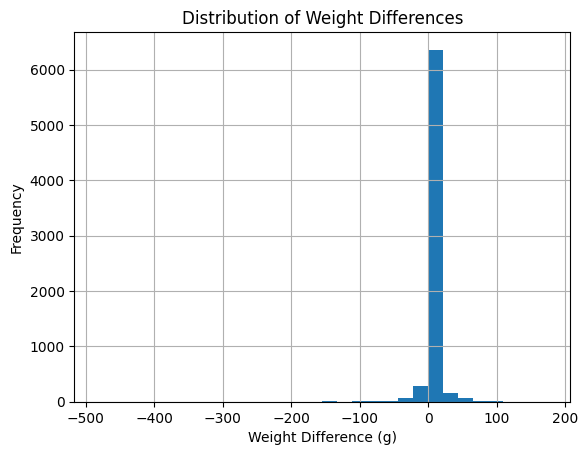

In [ ]:
import matplotlib.pyplot as plt
df["weight_diff"].hist(bins=30)
plt.xlabel("Weight Difference (g)")
plt.ylabel("Frequency")
plt.title("Distribution of Weight Differences")
plt.show()


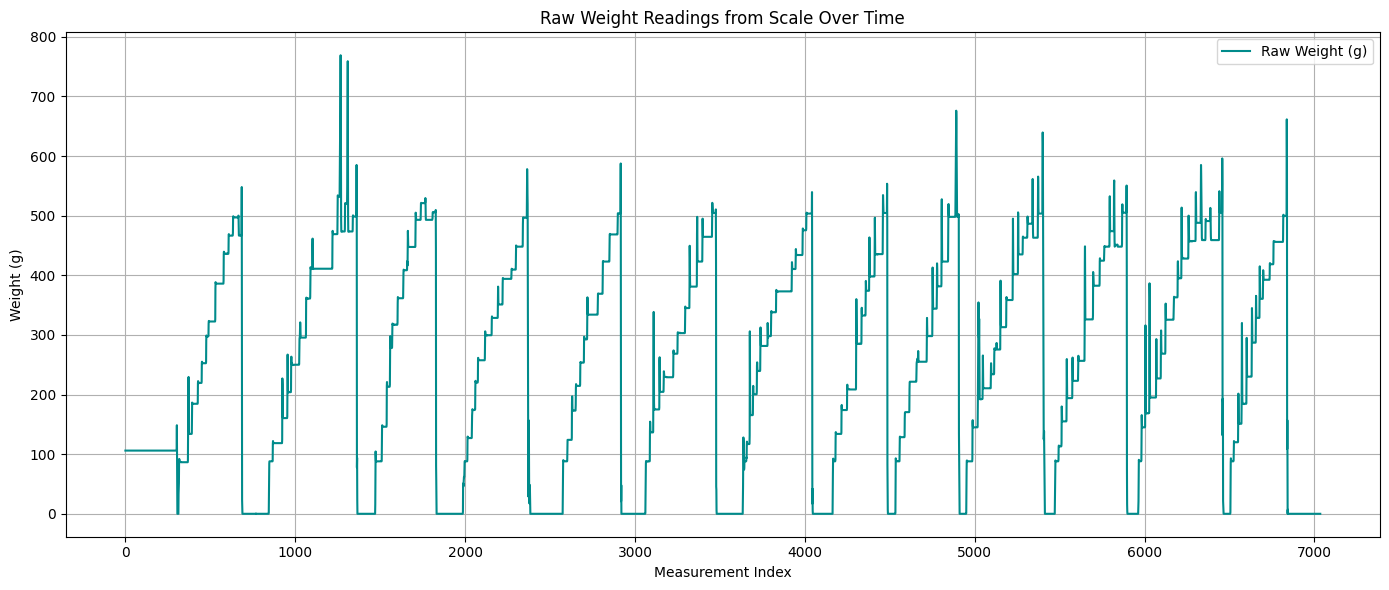

In [ ]:
# Recreate cleaned DataFrame from the uploaded file since variable was lost

file_path = "/content/New data collector_000000_tcpclient.csv"
raw_df = pd.read_csv(file_path)

# Split and clean
df = raw_df.iloc[:, 0].str.split(";", expand=True)
df.columns = ["unix_timestamp", "timestamp", "message"]
df["unix_timestamp"] = pd.to_numeric(df["unix_timestamp"], errors='coerce')
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S:%f", errors='coerce')
df["message_clean"] = df["message"].str.replace(" g", "", regex=False).str.replace("-", "").str.strip()
df["weight_g"] = pd.to_numeric(df["message_clean"], errors='coerce')

# Plot raw weight data again
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df.index, df["weight_g"], label="Raw Weight (g)", color='darkcyan')
plt.xlabel("Measurement Index")
plt.ylabel("Weight (g)")
plt.title("Raw Weight Readings from Scale Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

#  KPIs
base_kpis = [
    ("Befüllzeit eines Containers", "Sekunden / Minuten", "Zeitstempel, Gewicht"),
    ("Abweichung vom Zielgewicht", "Gramm", "Zielgewicht, Endgewicht"),
    ("Anzahl befüllter Container pro Schicht", "Anzahl", "Container-Resets"),
    ("Anzahl Einheiten pro Container", "Anzahl", "Kohl-Erkennungen pro Container"),
    ("Durchschnittliches Stückgewicht im Container", "Gramm", "Containergewicht / Anzahl Einheiten"),
    ("Zeitabstand zwischen den Einheiten im Container", "Sekunden", "Abstände der Gewichtsspitzen"),
    ("Zeit zwischen Containerbefüllungen", "Minuten", "Zeitdifferenz zwischen Container-Resets"),
    ("Durchschnittlicher Leerlauf pro Schicht", "Minuten", "Durchschnitt aller Leerlaufzeiten"),
    ("Minimales Stückgewicht im Container", "Gramm", "Minimum Gewicht in Container"),
    ("Maximales Stückgewicht im Container", "Gramm", "Maximum Gewicht in Container"),
    ("Durchschnittliches Stückgewicht im Container", "Gramm", "Durchschnitt aller Einheiten"),
    ("Gesamtanzahl der Einheiten pro Schicht", "Anzahl", "Gesamte Einheitenanzahl"),
    ("Gesamtanzahl der Container pro Schicht", "Anzahl", "Containeranzahl"),
    ("Gesamtgewicht der produzierten Ware pro Schicht", "Kilogramm", "Summe aller Gewichte"),
    ("Produktivität pro Einheit", "Einheiten/Stunde", "Einheitenanzahl / Zeit"),
    ("Produktivität pro Gewicht", "kg/Stunde", "Gesamtgewicht / Zeit"),
    ("Abfallmenge", "Kilogramm", "Rohgewicht - Endgewicht"),
    ("Verlust in der Verarbeitung", "Prozent", "(Roh - Endprodukt) / Roh"),
    ("Sortierqualität", "Prozent", "% außerhalb Normbereich"),
    ("Gewichtsstreuung bei Einheiten", "Standardabweichung (g)", "Standardabweichung Gewicht"),
    ("Kosten pro Stück", "€/Stück", "(Gesamtkosten / Stückzahl)"),
    ("Kosten pro kg", "€/kg", "(Gesamtkosten / Gewicht IST)"),
    ("Produktionsverlust in kg", "kg", "Rohware – IST"),
    ("Produktionsverlust in %", "%", "(Rohware – IST) / Rohware"),
    ("Abweichung zum Soll-Verlust", "kg", "(Verlust IST – Verlust SOLL)"),
    ("Ø Zeit pro Palette", "Minuten/Palette", "Arbeitszeit / Palettenanzahl"),
    ("Ø Kosten pro Palette", "€/Palette", "Kosten / Palettenanzahl"),
    ("Ø Mitarbeiterkosten pro Stunde", "€/h", "Lohnkosten / Stunden"),
    ("Stunden pro Schicht", "Stunden", "Summe aller Zeiten"),
    ("Anzahl Mitarbeiter pro Schicht", "Personen", "Zählung Personal"),
    ("Personalkosten pro Schicht", "€", "Ø Kosten * Personen * Stunden"),
    ("Rohware pro Palette", "kg", "Rohware / Paletten"),
    ("IST pro Palette", "kg", "IST / Paletten"),
    ("Verlust pro Palette", "kg", "Verlust / Paletten"),
    ("Kosten pro Produktart", "€/kg oder €/Stück", "Gefiltert nach Artikel"),
    ("Effizienz pro Mitarbeiter (Stück/h oder kg/h)", "Stück/h, kg/h", "Einheiten oder Gewicht / Zeit"),
    ("Leistungsvergleich Früh / Spät", "Differenz (€ oder %)", "Shiftvergleich"),
    ("Ø Bearbeitungszeit pro Artikel", "Minuten/Artikel", "Gesamtdauer der Artikelverarbeitung / Anzahl Artikel"),
    ("Qualitätsindikation pro Charge", "Klasse (z. B. gut/mittel/schlecht)", "Qualitätsbewertung aus Wareneingang / Verarbeitung"),
    # Neue OEE‐KPI‐Einträge:
    ("Verfügbarkeit (Availability)", "Prozent", "(Betriebszeit - Stillstandszeiten) / Betriebszeit × 100"),
    ("Leistung (Performance)", "Prozent", "(Ist-Produktion / Max. mögliche Produktion) × 100"),
    ("Qualitätsrate (Quality)", "Prozent", "(Fehlerfreie Einheiten / Gesamtproduktion) × 100")
]

# KPI-ID
def get_analytical_goals(kpi_id):
    mapping = {
        "Operative Steuerung": [1, 2, 3, 5, 7, 8, 13, 14, 26, 29, 30, 37, 38, 40, 41],
        "Kostenanalyse": [14, 15, 16, 17, 18, 21, 22, 23, 24, 27, 28, 31, 32, 33, 34, 35, 38],
        "Mitarbeitereffizienz": [12, 15, 16, 19, 20, 36, 41],
        "Verpackungsqualität": [2, 4, 5, 9, 10, 11, 25, 39, 42],
        "Schicht-/Teamvergleich": list(range(1, 43))
    }
    return ", ".join([k for k, ids in mapping.items() if kpi_id in ids])

def get_responsibility_levels(kpi_id):
    mapping = {
        "Arbeiter / Bediener": [12, 15, 16, 19, 36, 42],
        "Schichtleiter": [3, 4, 5, 6, 7, 8, 13, 14, 17, 18, 19, 20, 26, 29, 30, 37, 40, 41],
        "Produktionsleitung": list(range(1, 43)),
        "Controlling / Finanz": [14, 15, 16, 18, 21, 22, 27, 28, 31, 35]
    }
    return ", ".join([k for k, ids in mapping.items() if kpi_id in ids])

# Tabelle erzeugen
kpi_data = []
for i, (name, unit, source) in enumerate(base_kpis, start=1):
    kpi_data.append({
        "KPI-ID": i,
        "Kennzahl (DE)": f"{i}. {name}",
        "Einheit": unit,
        "Datenquelle": source,
        "Nach Analyseziel": get_analytical_goals(i),
        "Nach Verantwortungsebene": get_responsibility_levels(i)
    })

# DataFrame
kpi_df = pd.DataFrame(kpi_data)

# Ausgabe
print(kpi_df.to_string(index=False))


 KPI-ID                                       Kennzahl (DE)                            Einheit                                             Datenquelle                                                  Nach Analyseziel                                      Nach Verantwortungsebene
      1                      1. Befüllzeit eines Containers                 Sekunden / Minuten                                    Zeitstempel, Gewicht                       Operative Steuerung, Schicht-/Teamvergleich                                            Produktionsleitung
      2                       2. Abweichung vom Zielgewicht                              Gramm                                 Zielgewicht, Endgewicht  Operative Steuerung, Verpackungsqualität, Schicht-/Teamvergleich                                            Produktionsleitung
      3           3. Anzahl befüllter Container pro Schicht                             Anzahl                                        Container-Resets             

In [ ]:
import pandas as pd

# Schritt 1: CSV-Datei laden und vorbereiten
dateipfad = "/content/New data collector_000000_tcpclient.csv"
roh_df = pd.read_csv(dateipfad)

# Zerlegen der Daten in Spalten
df = roh_df.iloc[:, 0].str.split(";", expand=True)
df.columns = ["unix_timestamp", "timestamp", "message"]
df["unix_timestamp"] = pd.to_numeric(df["unix_timestamp"], errors="coerce")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S:%f", errors="coerce")
df["message_clean"] = df["message"].str.replace(" g", "", regex=False).str.replace("-", "").str.strip()
df["weight_g"] = pd.to_numeric(df["message_clean"], errors="coerce")

# Optional: Falls nur bestimmte Spalten benötigt werden, z.B. unix_timestamp, timestamp, weight_g
processed_df = df[["unix_timestamp", "timestamp", "weight_g"]]

# Speichern als neue CSV-Datei mit geeignetem Namen für SQL-Import
output_path = "//content/processed_data_for_sql.csv"
processed_df.to_csv(output_path, index=False)

# Vorschau der verarbeiteten Daten
processed_df.head()


,unix_timestamp,timestamp,weight_g
0,1.748846e+12,2025-06-02 08:27:24.099100,106.0
1,1.748846e+12,2025-06-02 08:27:25.009100,106.0
2,1.748846e+12,2025-06-02 08:27:25.019100,106.0
3,1.748846e+12,2025-06-02 08:27:25.029100,106.0
4,1.748846e+12,2025-06-02 08:27:25.039100,106.0


# 1.Befüllzeit eines Containers

In [ ]:
import pandas as pd
import sqlite3

# Schritt 1: CSV-Datei laden und vorbereiten
file_path = "/content/New data collector_000000_tcpclient.csv"
raw_df = pd.read_csv(file_path)

# Schritt 2: Spalten trennen und bereinigen
df = raw_df.iloc[:, 0].str.split(";", expand=True)
df.columns = ["unix_timestamp", "timestamp", "message"]
df["unix_timestamp"] = pd.to_numeric(df["unix_timestamp"], errors='coerce')
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S:%f", errors='coerce')
df["message_clean"] = df["message"].str.replace(" g", "", regex=False).str.replace("-", "").str.strip()
df["weight_g"] = pd.to_numeric(df["message_clean"], errors='coerce')

# Schritt 3: Container-ID definieren, wenn Gewicht unter 10 g fällt
df["reset"] = df["weight_g"] < 10
df["container_id"] = df["reset"].cumsum()

# Schritt 4: Verbindung zu SQLite-Datenbank und Daten übertragen
conn = sqlite3.connect(":memory:")
df[["timestamp", "weight_g", "container_id"]].to_sql("messungen", conn, index=False, if_exists="replace")

# Schritt 5: SQL-Abfrage zur Ermittlung der Befüllzeit je Container
abfrage = """
SELECT
    container_id,
    CAST((JULIANDAY(MAX(timestamp)) - JULIANDAY(MIN(timestamp))) * 86400 AS INTEGER) AS befuellzeit_sekunden
FROM
    messungen
GROUP BY
    container_id
HAVING
    befuellzeit_sekunden > 0
ORDER BY
    container_id;
"""

# Schritt 6: Ausführung der Abfrage
ergebnis_df = pd.read_sql_query(abfrage, conn)
ergebnis_df.head(15)


,container_id,befuellzeit_sekunden
0,0,30
1,7,37
2,162,51
3,267,35
4,423,39
5,615,34
6,757,41
7,912,40
8,1030,32
9,1076,37


In [ ]:
import pandas as pd
import sqlite3

# Schritt 1: Die verarbeitete CSV-Datei einlesen
csv_path = "/content/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# Schritt 2: Verbindung zur SQLite-Datenbank (im Speicher) herstellen
conn = sqlite3.connect(":memory:")

# Schritt 3: DataFrame in eine SQL-Tabelle namens "messungen" schreiben
df.to_sql("messungen", conn, index=False, if_exists="replace")

# Schritt 4: SQL-Abfrage definieren zur Berechnung der Befüllzeit je Container
query = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE
                WHEN weight_g < 10 THEN 1
                ELSE 0
            END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM
        messungen
),
labeled AS (
    SELECT
        timestamp,
        weight_g,
        container_id_raw + 1 AS container_id
    FROM
        assigned
)
SELECT
    container_id,
    CAST(
        (
            JULIANDAY(MAX(timestamp))
            - JULIANDAY(MIN(timestamp))
        ) * 86400
        AS INTEGER
    ) AS befuellzeit_sekunden
FROM
    labeled
GROUP BY
    container_id
HAVING
    befuellzeit_sekunden > 0
ORDER BY
    container_id;
"""

# Schritt 5: Abfrage ausführen und Ergebnis in einen DataFrame laden
result_df = pd.read_sql_query(query, conn)

# Schritt 6: Ergebnis anzeigen
result_df.head(15)


,container_id,befuellzeit_sekunden
0,1,30
1,8,37
2,163,51
3,268,35
4,424,39
5,616,34
6,758,41
7,913,40
8,1031,32
9,1077,37


In [ ]:
# Code für Google Colab: Daten in InfluxDB schreiben und „Befüllzeit eines Containers“ mit Flux berechnen.

# 1. Zuerst Installation der InfluxDB‑Client‑Bibliothek
!pip install influxdb-client

import pandas as pd
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS

# 2. Die bereits verarbeitete CSV-Datei einlesen
csv_path = "/content/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# 3. Verbindung zu InfluxDB herstellen (URL, Token, Org und Bucket anpassen!)
url    = "http://localhost:8086"      # z.B. "http://localhost:8086"
token  = "<DEIN_INFLUXDB_TOKEN>"
org    = "<DEINE_ORGANISATION>"
bucket = "<DEIN_BUCKET>"

client     = InfluxDBClient(url=url, token=token, org=org)
write_api  = client.write_api(write_options=SYNCHRONOUS)
query_api  = client.query_api()

# 4. Datenpunkt für jede Zeile in InfluxDB schreiben
#    - Measurement heißt hier "messungen"
#    - Feld „weight_g“ enthält das Gewicht
#    - Zeitstempel wird aus „timestamp“-Spalte übernommen
#
# Hinweis: Falls „timestamp“ noch nicht als Pandas‑Datetime erkannt ist,
# kann `pd.to_datetime(df["timestamp"])` zuvor aufgerufen werden.
df["timestamp"] = pd.to_datetime(df["timestamp"])

for _, row in df.iterrows():
    point = (
        Point("messungen")
        .field("weight_g", float(row["weight_g"]))
        .time(row["timestamp"], WritePrecision.NS)
    )
    write_api.write(bucket=bucket, org=org, record=point)

# 5. Flux‑Query definieren zur Berechnung der Befüllzeiten
#    - reset = 1, wenn weight_g < 10, sonst 0
#    - container_id_raw = kumulative Summe von reset über die Zeit
#    - container_id = container_id_raw + 1
#    - für jeden container_id: erstes und letztes _time ermitteln, Differenz → Sekunden
flux_query = f'''
data = from(bucket: "{bucket}")
  |> range(start: 0)
  |> filter(fn: (r) => r._measurement == "messungen" and r._field == "weight_g")
  |> map(fn: (r) => ({{ r with reset: if r._value < 10.0 then 1 else 0 }}))
  |> cumulativeSum(columns: ["reset"], as: "container_id_raw")
  |> map(fn: (r) => ({{ r with container_id: r.container_id_raw + 1 }}))

first_per_container =
  data
    |> group(columns: ["container_id"])
    |> first(column: "_time")
    |> map(fn: (r) => ({{ container_id: r.container_id, start_time: r._time }}))

last_per_container =
  data
    |> group(columns: ["container_id"])
    |> last(column: "_time")
    |> map(fn: (r) => ({{ container_id: r.container_id, end_time: r._time }}))

join(
  tables: {{start: first_per_container, end: last_per_container}},
  on: ["container_id"]
)
|> map(fn: (r) => ({{
     container_id: r.container_id,
     befuellzeit_sekunden: uint(v: (uint(v: r.end_time) - uint(v: r.start_time)) / 1000000000)
}}))
'''

# 6. Flux‑Abfrage ausführen und Ergebnis als DataFrame zurückgeben
result_influx = query_api.query_data_frame(org=org, query=flux_query)

# 7. Ergebnis anzeigen (erste 15 Zeilen)
result_influx.head(15)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.3/746.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 15.4 MB/s eta 0:00:00


NewConnectionError: <urllib3.connection.HTTPConnection object at 0x7fb1349b8510>: Failed to establish a new connection: [Errno 111] Connection refused

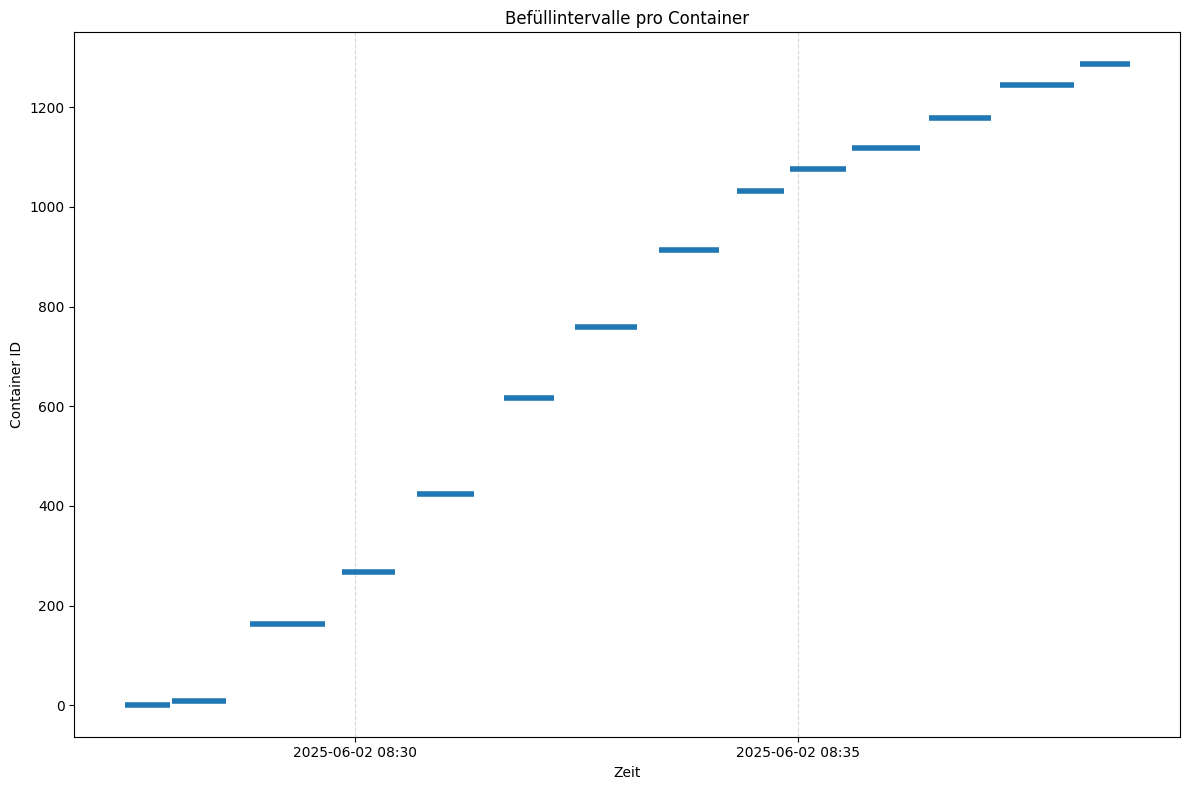

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ------------------------------------------------------------------
# 1. CSV-Datei einlesen (Pfad ggf. anpassen!)
# ------------------------------------------------------------------
csv_path = "/content/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2. Verbindung zu einer SQLite-Datenbank im RAM herstellen
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")

# ------------------------------------------------------------------
# 3. DataFrame in eine SQL-Tabelle namens "messungen" schreiben
# ------------------------------------------------------------------
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 4. SQL-Abfrage: Für jeden Container Start- und Endzeitpunkt ermitteln
# ------------------------------------------------------------------
query_with_times = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE
                WHEN weight_g < 10 THEN 1
                ELSE 0
            END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM
        messungen
),
labeled AS (
    SELECT
        timestamp,
        weight_g,
        container_id_raw + 1 AS container_id
    FROM
        assigned
)
SELECT
    container_id,
    MIN(timestamp) AS start_time,
    MAX(timestamp) AS end_time
FROM
    labeled
GROUP BY
    container_id
HAVING
    JULIANDAY(end_time) > JULIANDAY(start_time)
ORDER BY
    container_id;
"""

# ------------------------------------------------------------------
# 5. Abfrage ausführen und in DataFrame laden
# ------------------------------------------------------------------
intervals_df = pd.read_sql_query(query_with_times, conn)

# Zeitstempel in echte Datetime-Objekte umwandeln
intervals_df['start_time'] = pd.to_datetime(intervals_df['start_time'])
intervals_df['end_time'] = pd.to_datetime(intervals_df['end_time'])

# ------------------------------------------------------------------
# 6. Plot erstellen (Gantt-Chart / Zeit-Intervalle)
# ------------------------------------------------------------------
plt.figure(figsize=(12, 8))

# Für jeden Container eine horizontale Linie zeichnen (von start_time bis end_time)
for idx, row in intervals_df.iterrows():
    plt.hlines(
        y=row['container_id'],           # y = Container-ID
        xmin=row['start_time'],          # xmin = Startzeit
        xmax=row['end_time'],            # xmax = Endzeit
        color='tab:blue',
        linewidth=4
    )

plt.xlabel('Zeit')
plt.ylabel('Container ID')
plt.title('Befüllintervalle pro Container')

# Datumsformat auf der x-Achse einstellen
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Je  kürzer ein Balken in der Zeitachse (x‐Achse) ist, desto schneller wurde dieser Container befüllt. Wenn also ein Bediener „besser“ bzw. schneller arbeitet, sieht man das daran, dass die Balken horizontal jeweils kürzer werden, nicht daran, wie hoch sie auf der y‐Achse liegen.

# 2.Abweichung vom Zielgewicht

=== Tabelle: Stabiles Plateau‐Gewicht und Abweichung pro Container ===
 container_id  plateau_weight  abweichung_g
            8           466.5         -33.5
          163           498.5          -1.5
          268           506.0           6.0
          424           496.5          -3.5
          616           503.5           3.5
          758           504.5           4.5
          913           503.5           3.5
         1031           504.5           4.5
         1077           498.0          -2.0
         1118           503.5           3.5
         1178           505.0           5.0
         1244           505.0           5.0
         1286           499.5          -0.5


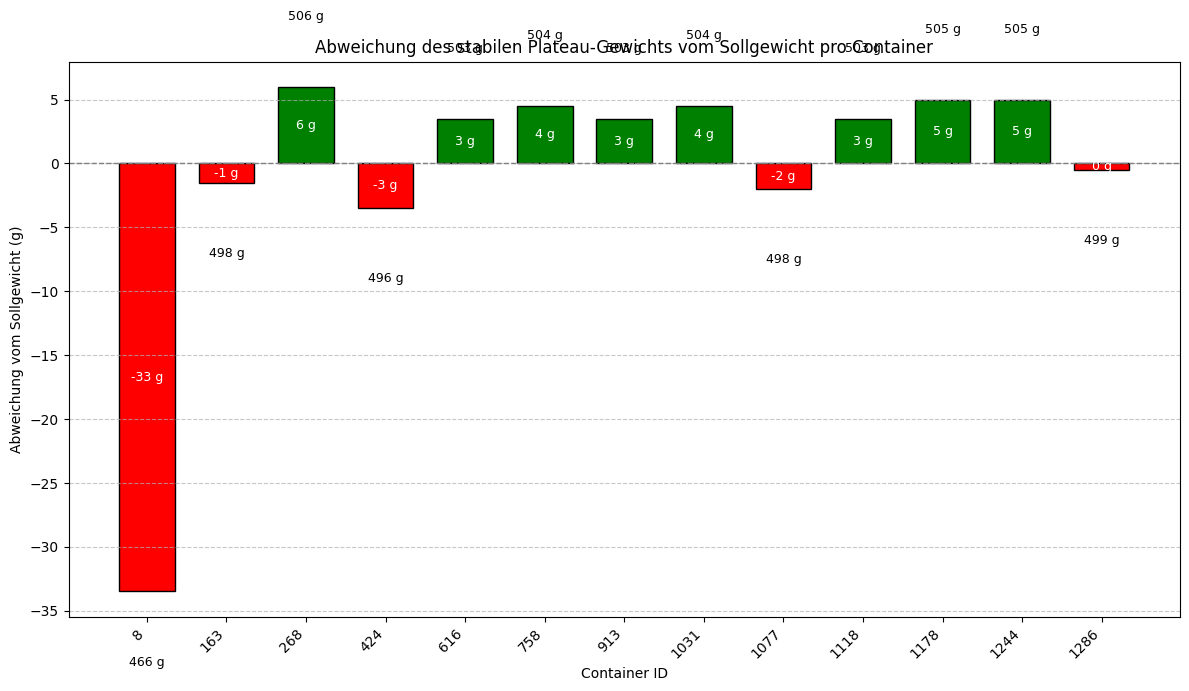

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0. Hilfsfunktion: Run‐Length‐Encoding für Plateau‐Erkennung
# ------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    """
    Extrahiert aus einer Liste von Gewichtsmessungen alle Plateau-Werte (Runs),
    bei denen derselbe Wert mindestens `min_run_len`-mal hintereinander auftritt.
    Gibt die Plateau-Werte in der Reihenfolge zurück, in der sie erscheinen.
    """
    plateaus = []
    current_weight = None
    run_length = 0

    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            # Wenn vorheriger Run lang genug war, als Plateau speichern
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    # Am Ende prüfen, ob der letzte Run ein Plateau ist
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)

    return plateaus

# ------------------------------------------------------------------
# 1. Parameter: Sollgewicht definieren
# ------------------------------------------------------------------
target_weight = 500  # in Gramm

# ------------------------------------------------------------------
# 2. CSV-Datei einlesen (Pfad ggf. anpassen)
# ------------------------------------------------------------------
csv_path = "/content/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 3. SQLite‐DB im RAM: DataFrame in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 4. Container‐ID vergeben: Wenn weight_g < 10, neuer Container beginnt
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE
                WHEN weight_g < 10 THEN 1
                ELSE 0
            END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM
        messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM
    assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'])

# ------------------------------------------------------------------
# 5. „Echte“ Container filtern: Nur solche mit max_weight ≥ 485 g
# ------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------
# 6. Für jeden Container: Letztes stabiles Plateau vor Reset ermitteln
# ------------------------------------------------------------------
results = []

for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)

    # 6.1. Gewichtsliste für diesen Container
    weight_sequence = grp['weight_g'].tolist()

    # 6.2. Alle Plateaus (mindestens 3 gleiche Messungen) extrahieren
    plateau_weights = extract_plateau_weights(weight_sequence, min_run_len=3)

    # 6.3. Falls keine Plateau‐Sequenz gefunden, letzten Messwert vor Reset verwenden
    if not plateau_weights:
        final_plateau = weight_sequence[-1]
    else:
        final_plateau = plateau_weights[-1]

    # 6.4. Abweichung berechnen
    deviation = final_plateau - target_weight

    results.append({
        'container_id': container_id,
        'plateau_weight': round(final_plateau, 1),
        'abweichung_g': round(deviation, 1)
    })

plateau_df = pd.DataFrame(results)

# ------------------------------------------------------------------
# 7. Tabelle ausgeben: container_id, plateau_weight, abweichung_g
# ------------------------------------------------------------------
print("=== Tabelle: Stabiles Plateau‐Gewicht und Abweichung pro Container ===")
print(plateau_df.to_string(index=False))

# ------------------------------------------------------------------
# 8. Visualisierung: Balkendiagramm mit Beschriftungen
# ------------------------------------------------------------------
colors = ['green' if g >= 0 else 'red' for g in plateau_df['abweichung_g']]

plt.figure(figsize=(12, 7))
bars = plt.bar(
    plateau_df['container_id'].astype(str),
    plateau_df['abweichung_g'],
    color=colors,
    edgecolor='black',
    width=0.7
)

# Hilfslinie bei 0 g (Sollgewicht genau getroffen)
plt.axhline(0, color='gray', linewidth=1, linestyle='--')

plt.xlabel('Container ID')
plt.ylabel('Abweichung vom Sollgewicht (g)')
plt.title('Abweichung des stabilen Plateau-Gewichts vom Sollgewicht pro Container')

# Gitterlinien
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')

# 9. Balkenbeschriftungen: Plateau-Gewicht oberhalb des Balkens, Abweichung in der Mitte
for bar, plt_w, dev in zip(bars, plateau_df['plateau_weight'], plateau_df['abweichung_g']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()

    # Plateau-Gewicht knapp oberhalb des Balkens (oder etwas darunter, falls Balken negativ)
    if y >= 0:
        plt.text(x, y + 5, f"{int(plt_w)} g", ha='center', va='bottom', fontsize=9, color='black')
    else:
        plt.text(x, y - 5, f"{int(plt_w)} g", ha='center', va='top', fontsize=9, color='black')

    # Abweichung vom Sollgewicht mittig im Balken (negativer Balken invertiert)
    if y >= 0:
        plt.text(x, y / 2, f"{int(dev)} g", ha='center', va='center', fontsize=9, color='white')
    else:
        plt.text(x, y / 2, f"{int(dev)} g", ha='center', va='center', fontsize=9, color='white')

plt.tight_layout()
plt.show()


# 3.Anzahl befüllter Container pro Schicht

=== Tabelle: Anzahl befüllter Container pro 12-Stunden-Schicht ===
     Schicht  Anzahl_fuellungen
Tagesschicht                 13


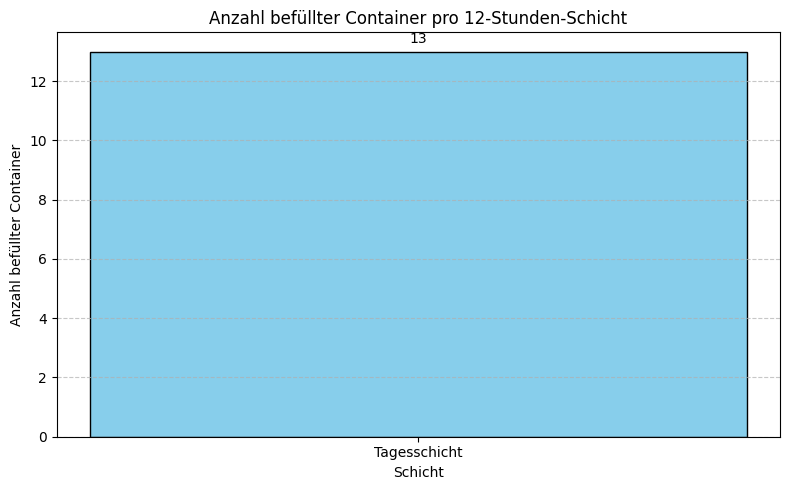

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Parameter: Zielgewicht definieren
# ------------------------------------------------------------------
target_weight = 500  # in Gramm

# ------------------------------------------------------------------
# 2. CSV-Datei einlesen (Pfad ggf. an deine Umgebung anpassen)
# ------------------------------------------------------------------
csv_path = "/content/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 3. Temporäre SQLite-Datenbank im Speicher erstellen
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")

# ------------------------------------------------------------------
# 4. DataFrame in SQL-Tabelle "messungen" schreiben
# ------------------------------------------------------------------
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 5. SQL-Abfrage: Für jeden Container das Maximalgewicht und den End-Zeitpunkt ermitteln
#    → Nur Container mit max_weight ≥ 500 (echte Füllvorgänge)
# ------------------------------------------------------------------
query_container_end = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE
                WHEN weight_g < 10 THEN 1
                ELSE 0
            END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM
        messungen
),
labeled AS (
    SELECT
        timestamp,
        weight_g,
        container_id_raw + 1 AS container_id
    FROM
        assigned
)
SELECT
    container_id,
    MAX(weight_g) AS max_weight,
    MAX(timestamp) AS end_time
FROM
    labeled
GROUP BY
    container_id
HAVING
    MAX(weight_g) >= 485
ORDER BY
    container_id;
"""

# ------------------------------------------------------------------
# 6. Abfrage ausführen und Ergebnis in DataFrame laden
# ------------------------------------------------------------------
containers_df = pd.read_sql_query(query_container_end, conn, params={"target": target_weight})

# ------------------------------------------------------------------
# 7. Spalte 'end_time' in datetime umwandeln
# ------------------------------------------------------------------
containers_df['end_time'] = pd.to_datetime(containers_df['end_time'])

# ------------------------------------------------------------------
# 8. Schichtzuordnung basierend auf 'end_time' für 2 × 12h-Schichten
#    - Tagesschicht: 06:00–17:59
#    - Nachtschicht: 18:00–05:59
# ------------------------------------------------------------------
def assign_shift(ts):
    hour = ts.hour
    if 6 <= hour < 18:
        return "Tagesschicht"
    else:
        return "Nachtschicht"

containers_df['Schicht'] = containers_df['end_time'].apply(assign_shift)

# ------------------------------------------------------------------
# 9. Anzahl befüllter Container pro Schicht ermitteln
# ------------------------------------------------------------------
shift_counts = (
    containers_df
    .groupby('Schicht')['container_id']
    .count()
    .reset_index()
)
shift_counts.columns = ['Schicht', 'Anzahl_fuellungen']

# ------------------------------------------------------------------
# 10. Tabelle der Shift-Counts ausgeben
# ------------------------------------------------------------------
print("=== Tabelle: Anzahl befüllter Container pro 12-Stunden-Schicht ===")
print(shift_counts.to_string(index=False))

# ------------------------------------------------------------------
# 11. Visualisierung: Balkendiagramm der Schicht-Counts
# ------------------------------------------------------------------
plt.figure(figsize=(8, 5))
bars = plt.bar(
    shift_counts['Schicht'],
    shift_counts['Anzahl_fuellungen'],
    color=['skyblue', 'gray'],
    edgecolor='black',
    width=0.6
)

# Achsenbeschriftungen und Titel
plt.xlabel('Schicht')
plt.ylabel('Anzahl befüllter Container')
plt.title('Anzahl befüllter Container pro 12-Stunden-Schicht')

# Gitterlinien nur auf der y-Achse
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Werte über die Balken schreiben
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.2,
        f"{int(height)}",
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

plt.tight_layout()
plt.show()


# 4.Anzahl Einheiten pro Container

=== Tabelle: Anzahl der Einheiten pro Container (Plateau, min_run_len=3) ===
 container_id  anzahl_einheiten
            8                 9
          163                11
          268                10
          424                11
          616                10
          758                11
          913                13
         1031                 8
         1077                 9
         1118                12
         1178                 8
         1244                11
         1286                10


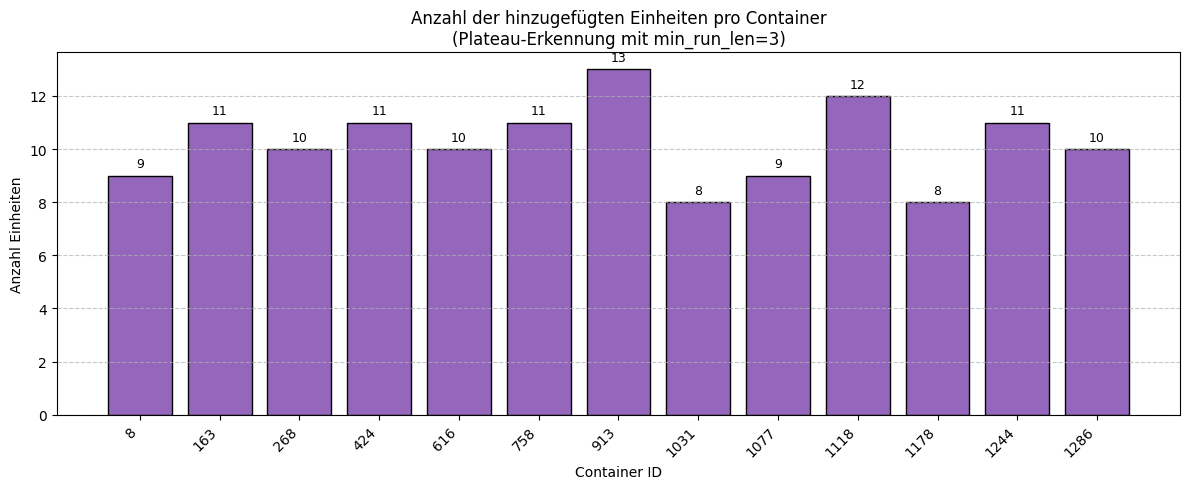

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0. Hilfsfunktion: Run‐Length‐Encoding für Plateau‐Erkennung
# ------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    """
    Extrahiert aus einer Liste von Gewichtsmessungen alle Plateau-Werte (Runs),
    bei denen derselbe Wert mindestens `min_run_len`-mal hintereinander auftritt.
    Gibt die Plateau-Werte in der Reihenfolge zurück, in der sie erscheinen.
    """
    plateaus = []
    current_weight = None
    run_length = 0

    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            # Wenn der vorherige Run lang genug war, speichern:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    # Am Ende prüfen, ob der letzte Run ein Plateau ist
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)

    return plateaus

# ------------------------------------------------------------------
# 1. CSV-Datei einlesen (Pfad ggf. anpassen)
# ------------------------------------------------------------------
csv_path = "/content/processed_data_for_sql.csv"  # in Colab ggf. "/content/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2. SQLite‐Datenbank im Arbeitsspeicher erstellen und DataFrame in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 3. Container‐ID vergeben: Jedes Mal, wenn weight_g < 10 → neuer Container
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE
                WHEN weight_g < 10 THEN 1
                ELSE 0
            END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM
        messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM
    assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'])

# ------------------------------------------------------------------
# 4. „Echte“ Container filtern: Nur diejenigen, deren max_weight ≥ 485 g
# ------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------
# 5. Netto‐Zählung je Container anhand der Plateau‐Logik (min_run_len=3)
# ------------------------------------------------------------------
unit_counts = []

for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)

    # 5.1. Vollständige Gewichtsliste dieses Containers
    weight_sequence = grp['weight_g'].tolist()

    # 5.2. Alle Plateaus (mindestens 3 gleiche Messungen) extrahieren
    plateau_weights = extract_plateau_weights(weight_sequence, min_run_len=3)

    # 5.3. Netto-Zählung: +1 für jedes steigende Plateau, -1 für jedes fallende, Zähler >= 0
    count = 0
    for i in range(1, len(plateau_weights)):
        delta = plateau_weights[i] - plateau_weights[i-1]
        if delta > 0:
            count += 1
        elif delta < 0:
            count -= 1
            if count < 0:
                count = 0

    unit_counts.append({
        'container_id': container_id,
        'anzahl_einheiten': count
    })

units_per_container_df = pd.DataFrame(unit_counts)

# ------------------------------------------------------------------
# 6. Tabelle ausgeben: container_id und anzahl_einheiten
# ------------------------------------------------------------------
print("=== Tabelle: Anzahl der Einheiten pro Container (Plateau, min_run_len=3) ===")
print(units_per_container_df.to_string(index=False))

# ------------------------------------------------------------------
# 7. Visualisierung: Balkendiagramm + Beschriftungen auf den Balken
# ------------------------------------------------------------------
plt.figure(figsize=(12, 5))
bars = plt.bar(
    units_per_container_df['container_id'].astype(str),
    units_per_container_df['anzahl_einheiten'],
    color='tab:purple',
    edgecolor='black'
)

plt.xlabel('Container ID')
plt.ylabel('Anzahl Einheiten')
plt.title('Anzahl der hinzugefügten Einheiten pro Container\n(Plateau‐Erkennung mit min_run_len=3)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 7.1. Beschriftung: Zeige die genaue Anzahl über jedem Balken an
for bar, count in zip(bars, units_per_container_df['anzahl_einheiten']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(
        x, y + 0.2, str(int(count)),
        ha='center', va='bottom', fontsize=9, color='black'
    )

plt.tight_layout()
plt.show()


# 5.Durchschnittliches Stückgewicht im Container

=== Tabelle: Durchschnittliches Stückgewicht pro Container ===
 container_id  plateau_weight  anzahl_einheiten  durchschnitt_stueckgewicht
            8           466.5                 9                        51.8
          163           498.5                11                        45.3
          268           506.0                10                        50.6
          424           496.5                11                        45.1
          616           503.5                10                        50.4
          758           504.5                11                        45.9
          913           503.5                13                        38.7
         1031           504.5                 8                        63.1
         1077           498.0                 9                        55.3
         1118           503.5                12                        42.0
         1178           505.0                 8                        63.1
         1244           5

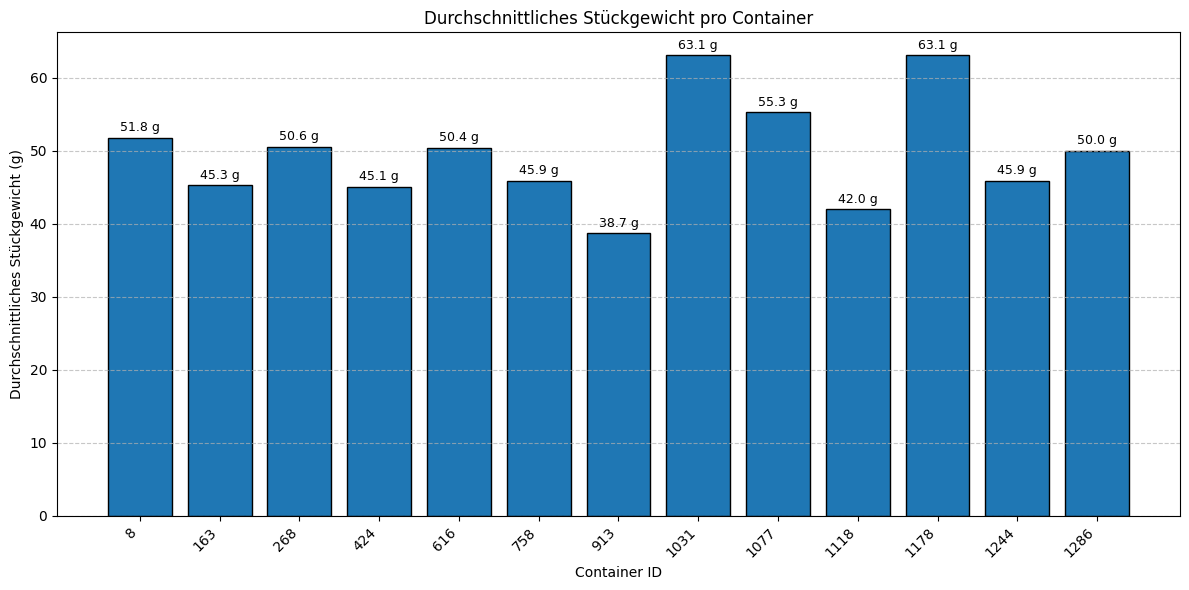

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0. Hilfsfunktion: Run‐Length‐Encoding für Plateau‐Erkennung
# ------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    """
    Extrahiert alle Plateau-Werte aus einer Liste von Gewichtsmessungen,
    bei denen derselbe Wert mindestens `min_run_len`-mal hintereinander auftritt.
    """
    plateaus = []
    current_weight = None
    run_length = 0

    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            # Wenn der vorherige Run lang genug war, speichern
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    # Am Ende prüfen, ob auch der letzte Run ein Plateau ist
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)

    return plateaus

# ------------------------------------------------------------------
# 1. CSV-Datei einlesen (Pfad anpassen, z.B. "/content/processed_data_for_sql.csv")
# ------------------------------------------------------------------
csv_path = "/content/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2. SQLite‐Datenbank im RAM erstellen und DataFrame in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 3. Container‐ID vergeben: Start eines neuen Containers, wenn weight_g < 10 g
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE
                WHEN weight_g < 10 THEN 1
                ELSE 0
            END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM
        messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM
    assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'])

# ------------------------------------------------------------------
# 4. Filter auf „echte“ Container: Nur solche, deren max_weight ≥ 485 g
# ------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------
# 5. Für jeden Container: Letztes stabiles Plateau & Stückzahl ermitteln
# ------------------------------------------------------------------
results = []

for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)
    weight_sequence = grp['weight_g'].tolist()

    # 5.1. Alle Plateaus (mind. 3 gleiche Werte) extrahieren
    plateau_weights = extract_plateau_weights(weight_sequence, min_run_len=3)

    # 5.2. Finale Plateau-Gewicht bestimmen
    if not plateau_weights:
        final_plateau = weight_sequence[-1]
    else:
        final_plateau = plateau_weights[-1]

    # 5.3. Netto‐Stückzahl: +1 für jedes steigende Plateau, -1 für jedes fallende, Zähler ≥ 0
    count = 0
    for i in range(1, len(plateau_weights)):
        delta = plateau_weights[i] - plateau_weights[i-1]
        if delta > 0:
            count += 1
        elif delta < 0:
            count -= 1
            if count < 0:
                count = 0

    results.append({
        'container_id': container_id,
        'plateau_weight': final_plateau,
        'anzahl_einheiten': count
    })

container_stats_df = pd.DataFrame(results)

# ------------------------------------------------------------------
# 6. Durchschnittliches Stückgewicht berechnen
# ------------------------------------------------------------------
container_stats_df['durchschnitt_stueckgewicht'] = (
    container_stats_df['plateau_weight'] / container_stats_df['anzahl_einheiten']
)

# Auf eine Nachkommastelle runden
container_stats_df['plateau_weight'] = container_stats_df['plateau_weight'].round(1)
container_stats_df['durchschnitt_stueckgewicht'] = container_stats_df['durchschnitt_stueckgewicht'].round(1)

# ------------------------------------------------------------------
# 7. Tabelle ausgeben: Container, Plateau-Gewicht, Stückzahl, durchschnittliches Stückgewicht
# ------------------------------------------------------------------
print("=== Tabelle: Durchschnittliches Stückgewicht pro Container ===")
print(container_stats_df.to_string(index=False))

# ------------------------------------------------------------------
# 8. Visualisierung: Balkendiagramm des Durchschnitts-Stückgewichts mit Beschriftungen
# ------------------------------------------------------------------
plt.figure(figsize=(12, 6))
bars = plt.bar(
    container_stats_df['container_id'].astype(str),
    container_stats_df['durchschnitt_stueckgewicht'],
    color='tab:blue',
    edgecolor='black'
)

plt.xlabel('Container ID')
plt.ylabel('Durchschnittliches Stückgewicht (g)')
plt.title('Durchschnittliches Stückgewicht pro Container')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Beschriftung: Durchschnitts-Stückgewicht über jedem Balken anzeigen
for bar, avg_w in zip(bars, container_stats_df['durchschnitt_stueckgewicht']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(
        x, y + 0.5, f"{avg_w} g",
        ha='center', va='bottom', fontsize=9, color='black'
    )

plt.tight_layout()
plt.show()


#6.Zeitabstand zwischen den Einheiten

=== Tabelle: Zeitabstände zwischen Einheiten pro Container ===
 container_id  anzahl_intervals  avg_interval_sec
            8                12               2.7
          163                14               3.5
          268                12               2.8
          424                12               2.8
          616                10               3.2
          758                13               3.0
          913                13               2.8
         1031                11               2.6
         1077                10               3.1
         1118                13               3.2
         1178                11               3.5
         1244                16               2.9
         1286                11               2.8


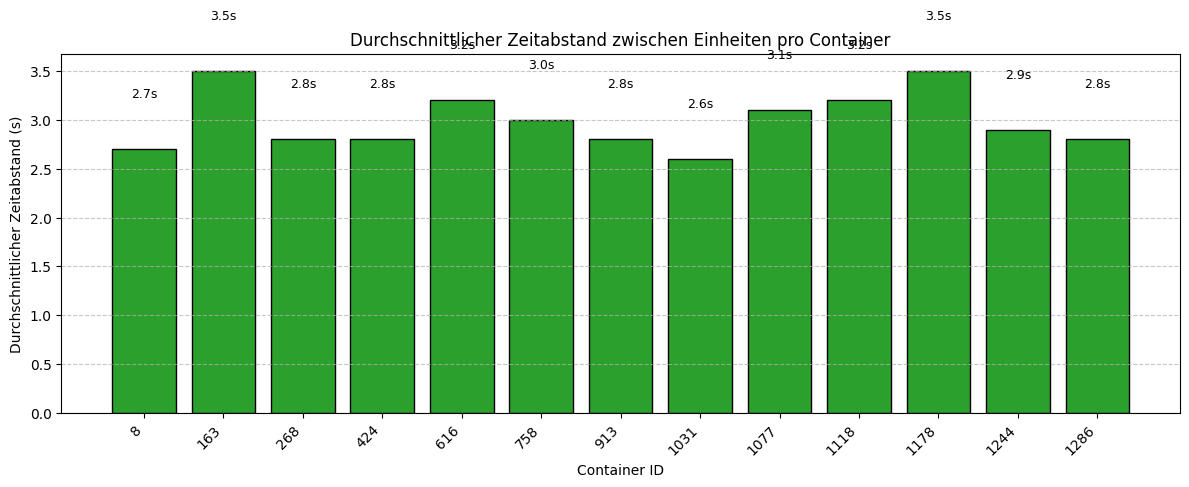

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------------
# 0. Hilfsfunktion: Extrahiert Plateaus mit Startzeit
# ------------------------------------------------------------------
def extract_plateaus_with_times(df_group, min_run_len=3):
    plateaus = []
    current_weight = None
    run_length = 0
    start_time = None

    weights = df_group['weight_g'].tolist()
    times = df_group['timestamp'].tolist()

    for idx, w in enumerate(weights):
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append((current_weight, start_time))
            current_weight = w
            run_length = 1
            start_time = times[idx]
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append((current_weight, start_time))
    return plateaus

# ------------------------------------------------------------------
# 1. CSV-Datei einlesen (Colab-Pfad)
# ------------------------------------------------------------------
csv_path = "/content/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2. SQLite-DB im RAM: DataFrame in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 3. Container-ID vergeben (Reset bei <10 g)
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'])

# ------------------------------------------------------------------
# 4. Filter „echte“ Container (max ≥ 485 g)
# ------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------
# 5. Zeitpunkte der Einheiten pro Container bestimmen und Intervalle berechnen
# ------------------------------------------------------------------
results = []
for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)
    plateaus = extract_plateaus_with_times(grp, min_run_len=3)
    weights, times = zip(*plateaus) if plateaus else ([], [])
    unit_times = []
    for i in range(len(weights)):
        if i == 0:
            if weights[0] > 0:
                unit_times.append(times[0])
        else:
            if weights[i] > weights[i-1]:
                unit_times.append(times[i])
    intervals = []
    for i in range(1, len(unit_times)):
        intervals.append((unit_times[i] - unit_times[i-1]).total_seconds())
    avg_interval = np.mean(intervals) if intervals else np.nan
    results.append({
        'container_id': container_id,
        'anzahl_intervals': len(intervals),
        'avg_interval_sec': round(avg_interval, 1) if not np.isnan(avg_interval) else np.nan
    })

intervals_df = pd.DataFrame(results)

# ------------------------------------------------------------------
# 6. Tabelle ausgeben
# ------------------------------------------------------------------
print("=== Tabelle: Zeitabstände zwischen Einheiten pro Container ===")
print(intervals_df.to_string(index=False))

# ------------------------------------------------------------------
# 7. Visualisierung: Balkendiagramm mit Beschriftungen
# ------------------------------------------------------------------
plt.figure(figsize=(12, 5))
bars = plt.bar(
    intervals_df['container_id'].astype(str),
    intervals_df['avg_interval_sec'],
    color='tab:green',
    edgecolor='black'
)

plt.xlabel('Container ID')
plt.ylabel('Durchschnittlicher Zeitabstand (s)')
plt.title('Durchschnittlicher Zeitabstand zwischen Einheiten pro Container')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, avg_sec in zip(bars, intervals_df['avg_interval_sec']):
    x = bar.get_x() + bar.get_width()/2
    y = bar.get_height()
    text = f"{avg_sec:.1f}s" if not np.isnan(avg_sec) else "n/a"
    plt.text(x, y + 0.5, text, ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


# 7.Zeit zwischen Containerbefüllungen

=== Tabelle: Zeit zwischen Containerbefüllungen ===
 container_id                   end_time                 next_start  time_to_next_sec
            8 2025-06-02 08:28:33.048300 2025-06-02 08:28:49.008600              16.0
          163 2025-06-02 08:29:40.088500 2025-06-02 08:29:51.032600              10.9
          268 2025-06-02 08:30:27.021700 2025-06-02 08:30:42.071700              15.0
          424 2025-06-02 08:31:21.098900 2025-06-02 08:31:41.006900              19.9
          616 2025-06-02 08:32:15.037000 2025-06-02 08:32:29.049100              14.0
          758 2025-06-02 08:33:11.004200 2025-06-02 08:33:26.045300              15.0
          913 2025-06-02 08:34:07.031400 2025-06-02 08:34:19.003500              12.0
         1031 2025-06-02 08:34:51.025600 2025-06-02 08:34:55.082600               4.1
         1077 2025-06-02 08:35:33.020700 2025-06-02 08:35:37.027700               4.0
         1118 2025-06-02 08:36:23.010900 2025-06-02 08:36:29.006900               6.0
  

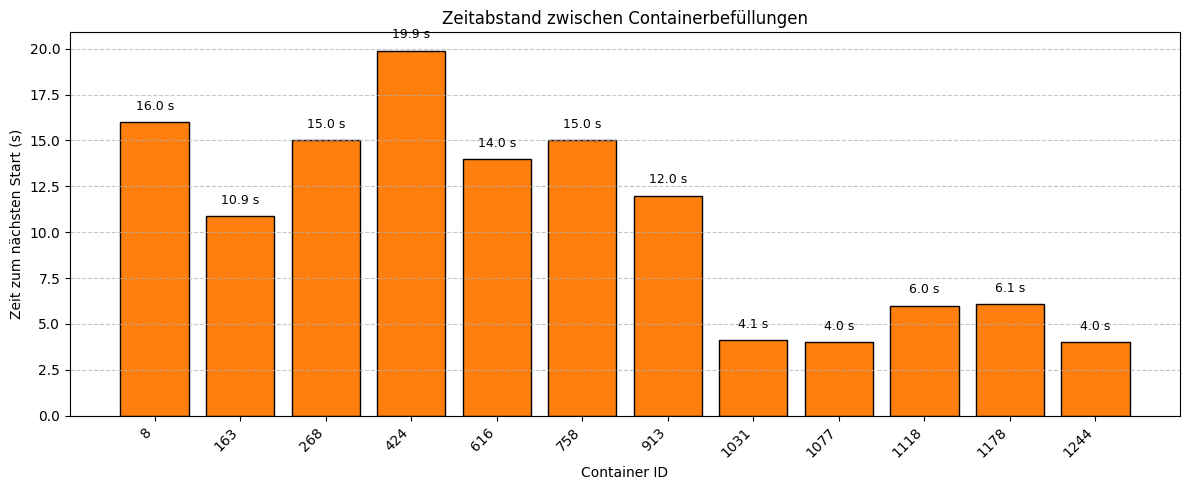

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. CSV-Datei einlesen (Pfad ggf. anpassen)
# ------------------------------------------------------------------
csv_path = "/content/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2. SQLite‐Datenbank im Arbeitsspeicher erstellen und DataFrame in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 3. Container‐ID vergeben: Jedes Mal, wenn weight_g < 10, beginnt ein neuer Container
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'])

# ------------------------------------------------------------------
# 4. Filter auf „echte“ Container: Nur solche, deren max_weight ≥ 485 g
# ------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------
# 5. Für jeden Container Start- und Endzeit berechnen
#    - start_time = erster timestamp des Containers
#    - end_time = letzter timestamp des Containers
# ------------------------------------------------------------------
times_df = (
    valid_df
    .groupby('container_id')['timestamp']
    .agg(start_time='min', end_time='max')
    .reset_index()
    .sort_values('container_id')
    .reset_index(drop=True)
)

# ------------------------------------------------------------------
# 6. Zeitabstände zwischen Containerbefüllungen berechnen
#    - diff_to_next = start_time_{i+1} - end_time_{i}
# ------------------------------------------------------------------
times_df['next_start'] = times_df['start_time'].shift(-1)
times_df['time_to_next_sec'] = (
    times_df['next_start'] - times_df['end_time']
).dt.total_seconds()
# Letzte Zeile hat kein Folge-Container, daher NaN; optional entfernen
intervals_df = times_df.dropna(subset=['time_to_next_sec']).copy()

# Runde Zeitabstände auf eine Nachkommastelle
intervals_df['time_to_next_sec'] = intervals_df['time_to_next_sec'].round(1)

# ------------------------------------------------------------------
# 7. Tabelle ausgeben: Container-ID, end_time, nächster start_time, Zeit in Sekunden
# ------------------------------------------------------------------
print("=== Tabelle: Zeit zwischen Containerbefüllungen ===")
print(intervals_df[['container_id', 'end_time', 'next_start', 'time_to_next_sec']].to_string(index=False))

# ------------------------------------------------------------------
# 8. Visualisierung: Balkendiagramm der Zeitabstände (Sekunden)
# ------------------------------------------------------------------
plt.figure(figsize=(12, 5))
bars = plt.bar(
    intervals_df['container_id'].astype(str),
    intervals_df['time_to_next_sec'],
    color='tab:orange',
    edgecolor='black'
)

plt.xlabel('Container ID')
plt.ylabel('Zeit zum nächsten Start (s)')
plt.title('Zeitabstand zwischen Containerbefüllungen')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 8.1. Beschriftung: Zeitabstand über jedem Balken anzeigen
for bar, sec in zip(bars, intervals_df['time_to_next_sec']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(
        x, y + 0.5, f"{sec} s",
        ha='center', va='bottom', fontsize=9, color='black'
    )

plt.tight_layout()
plt.show()


#8.Durchschnittlicher Leerlauf pro Schicht

=== Tabelle: Durchschnittlicher Leerlauf pro Schicht ===
       shift  avg_idle_sec
Tagesschicht          10.6


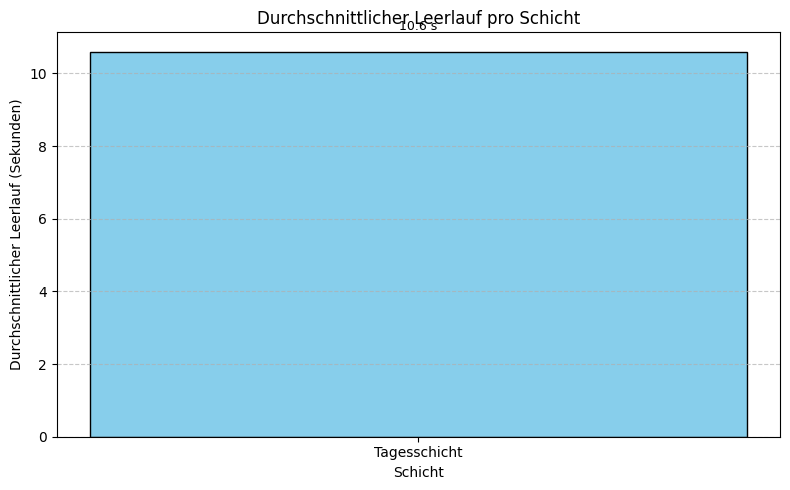

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. CSV-Datei einlesen (Colab-Pfad)
# ------------------------------------------------------------------
csv_path = "/content/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2. SQLite‐Datenbank im RAM erstellen und DataFrame in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 3. Container‐ID vergeben: Wenn weight_g < 10, neuer Container
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'])

# ------------------------------------------------------------------
# 4. „Echte“ Container filtern: Nur Container mit max_weight ≥ 485 g
# ------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------
# 5. Start- und Endzeit pro Container bestimmen
# ------------------------------------------------------------------
times_df = (
    valid_df
    .groupby('container_id')['timestamp']
    .agg(start_time='min', end_time='max')
    .reset_index()
    .sort_values('container_id')
    .reset_index(drop=True)
)

# ------------------------------------------------------------------
# 6. Zeitabstände zwischen Containerbefüllungen berechnen
#    (time_to_next_sec = start_time_{i+1} - end_time_{i})
# ------------------------------------------------------------------
times_df['next_start'] = times_df['start_time'].shift(-1)
times_df['time_to_next_sec'] = (
    times_df['next_start'] - times_df['end_time']
).dt.total_seconds()

# Entferne letzte Zeile (kein nächster Container)
intervals_df = times_df.dropna(subset=['time_to_next_sec']).copy()

# ------------------------------------------------------------------
# 7. Schichtzuordnung basierend auf end_time (2 × 12h-Schichten)
#    Tagesschicht: 06:00–17:59, Nachtschicht: 18:00–05:59
# ------------------------------------------------------------------
def assign_shift(ts):
    hour = ts.hour
    if 6 <= hour < 18:
        return "Tagesschicht"
    else:
        return "Nachtschicht"

intervals_df['shift'] = intervals_df['end_time'].apply(assign_shift)

# ------------------------------------------------------------------
# 8. Durchschnittlicher Leerlauf pro Schicht berechnen
# ------------------------------------------------------------------
idle_per_shift_df = (
    intervals_df
    .groupby('shift')['time_to_next_sec']
    .mean()
    .reset_index(name='avg_idle_sec')
)

# Auf eine Nachkommastelle runden
idle_per_shift_df['avg_idle_sec'] = idle_per_shift_df['avg_idle_sec'].round(1)

# ------------------------------------------------------------------
# 9. Tabelle ausgeben
# ------------------------------------------------------------------
print("=== Tabelle: Durchschnittlicher Leerlauf pro Schicht ===")
print(idle_per_shift_df.to_string(index=False))

# ------------------------------------------------------------------
# 10. Visualisierung: Balkendiagramm des durchschnittlichen Leerlaufs
# ------------------------------------------------------------------
plt.figure(figsize=(8, 5))
bars = plt.bar(
    idle_per_shift_df['shift'],
    idle_per_shift_df['avg_idle_sec'],
    color=['skyblue', 'gray'],
    edgecolor='black'
)

plt.xlabel('Schicht')
plt.ylabel('Durchschnittlicher Leerlauf (Sekunden)')
plt.title('Durchschnittlicher Leerlauf pro Schicht')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Beschriftung: Durchschnittswerte über den Balken
for bar, avg_sec in zip(bars, idle_per_shift_df['avg_idle_sec']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(
        x, y + 0.5, f"{avg_sec} s",
        ha='center', va='bottom', fontsize=9, color='black'
    )

plt.tight_layout()
plt.show()


# 9.Minimales Stückgewicht im Container

=== Tabelle: Minimales Stückgewicht pro Container (ohne Rauschen) ===
 container_id  min_stueckgewicht_g
            8                 25.0
          163                 25.0
          268                 12.5
          424                 15.5
          616                 35.0
          758                 25.0
          913                 16.5
         1031                 24.0
         1077                 33.5
         1118                 18.0
         1178                 25.0
         1244                 23.5
         1286                 26.0


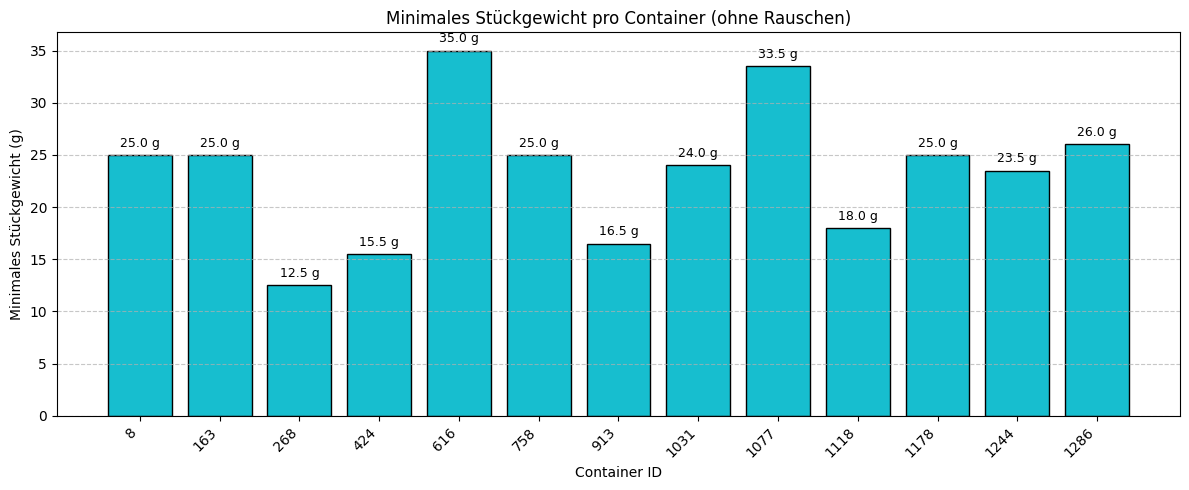

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0. Hilfsfunktion: Run-Length-Encoding für Plateau-Erkennung
# ------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    """
    Extrahiert aus einer Liste von Gewichtsmessungen alle Plateau-Werte (Runs),
    bei denen derselbe Wert mindestens `min_run_len`-mal hintereinander auftritt.
    Gibt die Plateau-Werte in der Reihenfolge zurück, in der sie erscheinen.
    """
    plateaus = []
    current_weight = None
    run_length = 0

    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)
    return plateaus

# ------------------------------------------------------------------
# 1. CSV-Datei einlesen (Colab-Pfad)
# ------------------------------------------------------------------
csv_path = "/content/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2. SQLite-DB im Arbeitsspeicher erstellen und DataFrame in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 3. Container-ID vergeben: Jedes Mal, wenn weight_g < 10 → neuer Container
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'])

# ------------------------------------------------------------------
# 4. Filter auf „echte“ Container: Nur solche, deren max_weight ≥ 485 g
# ------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------
# 5. Pro Container: Minimales Stückgewicht ermitteln (kleine Schwankungen ignorieren)
# ------------------------------------------------------------------
threshold = 1.0  # Änderungen ≤ 1 g werden als Rauschen ignoriert

results = []
for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)
    weight_sequence = grp['weight_g'].tolist()

    # 5.1. Plateaus extrahieren (Runs gleicher Werte, Länge ≥ 3)
    plateau_weights = extract_plateau_weights(weight_sequence, min_run_len=3)

    # 5.2. Stack zur Verfolgung von im Container verbleibenden Köpfen
    stack = []
    for i in range(1, len(plateau_weights)):
        delta = plateau_weights[i] - plateau_weights[i-1]
        if delta > threshold:
            # Neues Stück wurde hinzugefügt
            stack.append(delta)
        elif delta < -threshold:
            # Ein Stück wurde entfernt: pop das zuletzt hinzugefügte
            if stack:
                stack.pop()

    # 5.3. Minimals Stückgewicht aus verbleibenden Köpfen bestimmen
    if stack:
        min_piece = round(min(stack), 1)
    else:
        min_piece = None

    results.append({
        'container_id': container_id,
        'min_stueckgewicht_g': min_piece
    })

min_piece_df = pd.DataFrame(results)

# ------------------------------------------------------------------
# 6. Tabelle ausgeben: container_id, min_stueckgewicht_g
# ------------------------------------------------------------------
print("=== Tabelle: Minimales Stückgewicht pro Container (ohne Rauschen) ===")
print(min_piece_df.to_string(index=False))

# ------------------------------------------------------------------
# 7. Visualisierung: Balkendiagramm des minimalen Stückgewichts
# ------------------------------------------------------------------
plt.figure(figsize=(12, 5))
bars = plt.bar(
    min_piece_df['container_id'].astype(str),
    min_piece_df['min_stueckgewicht_g'].fillna(0),
    color='tab:cyan',
    edgecolor='black'
)

plt.xlabel('Container ID')
plt.ylabel('Minimales Stückgewicht (g)')
plt.title('Minimales Stückgewicht pro Container (ohne Rauschen)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 7.1. Beschriftung: Minimalgewicht über jedem Balken (oder "n/a")
for bar, min_w in zip(bars, min_piece_df['min_stueckgewicht_g']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    text = f"{min_w} g" if min_w is not None else "n/a"
    plt.text(x, y + 0.5, text, ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


#10.Maximales Stückgewicht im Container

=== Tabelle: Maximales Stückgewicht pro Container (ohne Rauschen) ===
 container_id  max_stueckgewicht_g
            8                 63.5
          163                 65.5
          268                 67.0
          424                 49.0
          616                 54.0
          758                 48.5
          913                 48.5
         1031                 76.5
         1077                 75.0
         1118                 57.0
         1178                 69.5
         1244                 57.0
         1286                 57.0


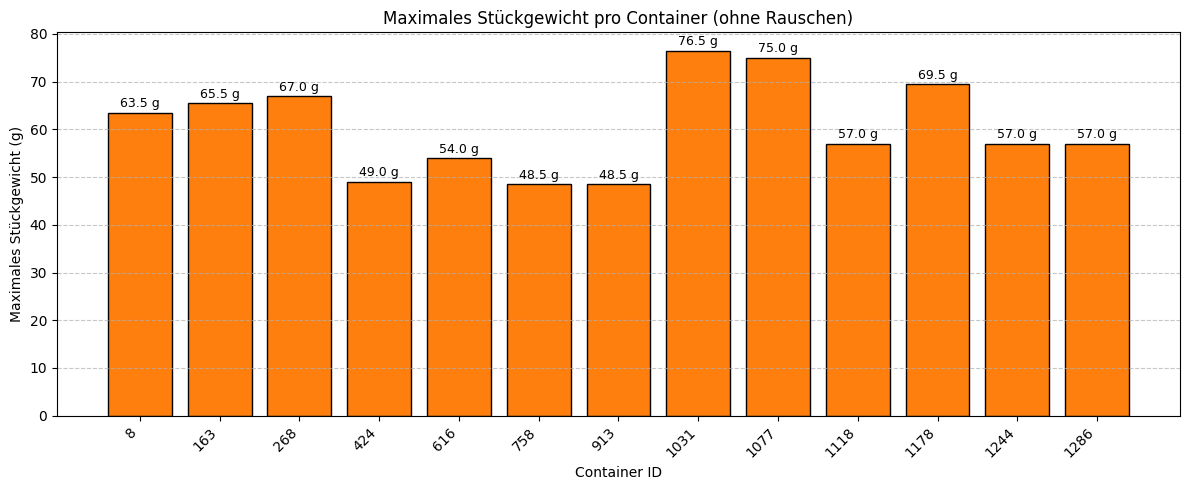

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0. Hilfsfunktion: Run-Length-Encoding für Plateau-Erkennung
# ------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    """
    Extrahiert aus einer Liste von Gewichtsmessungen alle Plateau-Werte (Runs),
    bei denen derselbe Wert mindestens `min_run_len`-mal hintereinander auftritt.
    Gibt die Plateau-Gewichte (je Run) in der Reihenfolge zurück, in der sie erscheinen.
    """
    plateaus = []
    current_weight = None
    run_length = 0

    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            # Prüfen, ob der vorherige Run lang genug war
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    # Am Ende ebenfalls prüfen
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)

    return plateaus

# ------------------------------------------------------------------
# 1. CSV-Datei einlesen (Pfad anpassen: Colab oder Sandbox)
# ------------------------------------------------------------------

csv_path = "/content/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2. SQLite-DB im Arbeitsspeicher erstellen und DataFrame in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 3. Container-ID vergeben: Jedes Mal, wenn weight_g < 10 → neuer Container beginnt
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'])

# ------------------------------------------------------------------
# 4. Filter auf „echte“ Container: Nur solche, deren max_weight ≥ 485 g
# ------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------
# 5. Pro Container: Maximales Stückgewicht ermitteln (small noise ignorieren)
# ------------------------------------------------------------------
threshold = 1.0  # Änderungen ≤ 1 g gelten als Rauschen und werden ignoriert

results = []
for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)
    weight_sequence = grp['weight_g'].tolist()

    # 5.1. Plateaus extrahieren (Runs gleicher Werte mit Länge ≥ 3)
    plateau_weights = extract_plateau_weights(weight_sequence, min_run_len=3)

    # 5.2. Stack: Verfolgung der im Container verbliebenen Kohlköpfe
    stack = []
    for i in range(1, len(plateau_weights)):
        delta = plateau_weights[i] - plateau_weights[i-1]
        if delta > threshold:
            # Ein neuer Kohlkopf wurde hinzugefügt
            stack.append(delta)
        elif delta < -threshold:
            # Ein Kohlkopf wurde entfernt: zuletzt hinzugefügt poppen
            if stack:
                stack.pop()

    # 5.3. Maximales Stückgewicht aus den verbliebenen Köpfen
    if stack:
        max_piece = round(max(stack), 1)
    else:
        max_piece = None

    results.append({
        'container_id': container_id,
        'max_stueckgewicht_g': max_piece
    })

max_piece_df = pd.DataFrame(results)

# ------------------------------------------------------------------
# 6. Tabelle ausgeben: container_id, max_stueckgewicht_g
# ------------------------------------------------------------------
print("=== Tabelle: Maximales Stückgewicht pro Container (ohne Rauschen) ===")
print(max_piece_df.to_string(index=False))

# ------------------------------------------------------------------
# 7. Visualisierung: Balkendiagramm des maximalen Stückgewichts
# ------------------------------------------------------------------
plt.figure(figsize=(12, 5))
bars = plt.bar(
    max_piece_df['container_id'].astype(str),
    max_piece_df['max_stueckgewicht_g'].fillna(0),
    color='tab:orange',
    edgecolor='black'
)

plt.xlabel('Container ID')
plt.ylabel('Maximales Stückgewicht (g)')
plt.title('Maximales Stückgewicht pro Container (ohne Rauschen)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 7.1. Beschriftung: Maximalwert über jedem Balken anzeigen (oder "n/a")
for bar, max_w in zip(bars, max_piece_df['max_stueckgewicht_g']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    text = f"{max_w} g" if max_w is not None else "n/a"
    plt.text(x, y + 0.5, text, ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


#Mitarbeiter-/Verarbeitungsbezogen:


#12.Gesamtanzahl der Einheiten pro Schicht

=== Tabelle: Gesamtanzahl der Einheiten pro Schicht (min. 485 g) ===
       shift  gesamt_einheiten
Tagesschicht               153


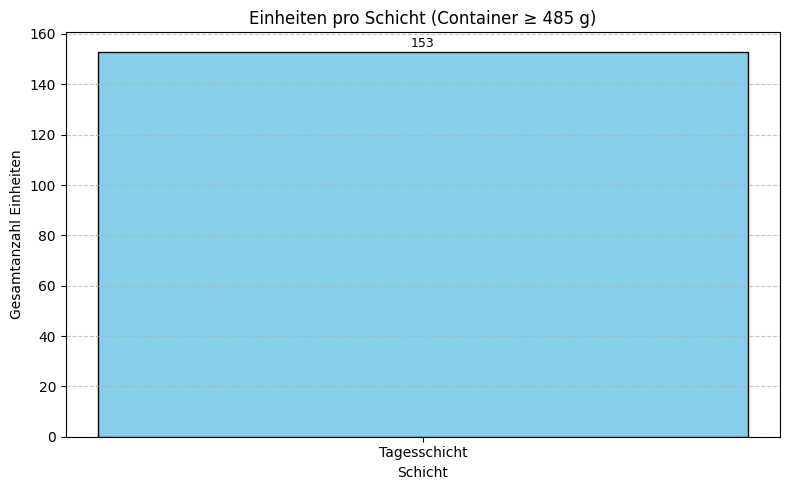

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0. Hilfsfunktion: Run-Length-Encoding für Plateau-Erkennung
# ------------------------------------------------------------------
def extract_plateaus_with_times(df_group, min_run_len=3, noise_thresh=1.0):
    """
    Für eine sortierte Gruppe (DataFrame) mit 'weight_g' und 'timestamp' liefert
    eine Liste von Zeitpunkten (timestamp), an denen eine neue Einheit (Kohlkopf)
    hinzugefügt wurde. Kleine Schwankungen (|delta| ≤ noise_thresh) werden ignoriert.
    """
    plateaus = []
    current_weight = None
    run_length = 0
    start_time = None

    weights = df_group['weight_g'].tolist()
    times = df_group['timestamp'].tolist()

    for idx, w in enumerate(weights):
        if w == current_weight:
            run_length += 1
        else:
            # Wenn vorheriger Run lang genug war, speichern
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append((current_weight, start_time))
            current_weight = w
            run_length = 1
            start_time = times[idx]
    # End-Run prüfen
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append((current_weight, start_time))

    # Aus Plateau-Liste nur die Zeitpunkte auswählen, bei denen delta > noise_thresh
    unit_times = []
    for i in range(len(plateaus)):
        weight_i, time_i = plateaus[i]
        if i == 0:
            # Erstes Plateau: zähle es, falls > 0 g
            if weight_i > 0:
                unit_times.append(time_i)
        else:
            weight_prev, _ = plateaus[i-1]
            delta = weight_i - weight_prev
            if delta > noise_thresh:
                unit_times.append(time_i)
            # negative oder kleine deltas ignorieren
    return unit_times

# ------------------------------------------------------------------
# 1. CSV-Datei einlesen (Pfad anpassen: Colab oder Sandbox)
# ------------------------------------------------------------------
csv_path = "/content/processed_data_for_sql.csv"  # ggf. "/mnt/data/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2. SQLite‐DB im Arbeitsspeicher erstellen und DataFrame in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 3. Container‐ID vergeben: Jedes Mal, wenn weight_g < 10 → neuer Container
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'])

# ------------------------------------------------------------------
# 4. Filter auf „echte“ Container: Nur solche, deren max_weight ≥ 485 g
# ------------------------------------------------------------------
min_weight_threshold = 485  # Minimalgewicht in Gramm
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= min_weight_threshold]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------
# 5. Alle Einheit-Zeitpunkte sammeln
# ------------------------------------------------------------------
all_unit_times = []
for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)
    unit_times = extract_plateaus_with_times(grp, min_run_len=3, noise_thresh=1.0)
    all_unit_times.extend(unit_times)

unit_times_df = pd.DataFrame({"unit_time": all_unit_times})

# ------------------------------------------------------------------
# 6. Schichtzuordnung für jeden Einheit-Zeitpunkt (2 × 12h-Schichten)
#     - Tagesschicht: 06:00–17:59
#     - Nachtschicht: 18:00–05:59
# ------------------------------------------------------------------
def assign_shift(ts):
    hour = ts.hour
    if 6 <= hour < 18:
        return "Tagesschicht"
    else:
        return "Nachtschicht"

unit_times_df['shift'] = unit_times_df['unit_time'].apply(assign_shift)

# ------------------------------------------------------------------
# 7. Gesamtanzahl der Einheiten pro Schicht ermitteln
# ------------------------------------------------------------------
units_per_shift = (
    unit_times_df
    .groupby('shift')['unit_time']
    .count()
    .reset_index(name='gesamt_einheiten')
)

# ------------------------------------------------------------------
# 8. Tabelle ausgeben: shift, gesamt_einheiten
# ------------------------------------------------------------------
print("=== Tabelle: Gesamtanzahl der Einheiten pro Schicht (min. 485 g) ===")
print(units_per_shift.to_string(index=False))

# ------------------------------------------------------------------
# 9. Visualisierung: Balkendiagramm der Gesamt-Einheiten pro Schicht
# ------------------------------------------------------------------
plt.figure(figsize=(8, 5))
bars = plt.bar(
    units_per_shift['shift'],
    units_per_shift['gesamt_einheiten'],
    color=['skyblue', 'gray'],
    edgecolor='black'
)

plt.xlabel('Schicht')
plt.ylabel('Gesamtanzahl Einheiten')
plt.title('Einheiten pro Schicht (Container ≥ 485 g)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 9.1. Beschriftung: Anzahl über jedem Balken anzeigen
for bar, count in zip(bars, units_per_shift['gesamt_einheiten']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(
        x, y + 0.5, str(int(count)),
        ha='center', va='bottom', fontsize=9, color='black'
    )

plt.tight_layout()
plt.show()


#13.Gesamtanzahl der Container pro Schicht (3.Anzahl befüllter Container pro Schicht)

=== Tabelle: Anzahl der Container pro Schicht (min. 485 g) ===
       shift  gesamt_container
Tagesschicht                13


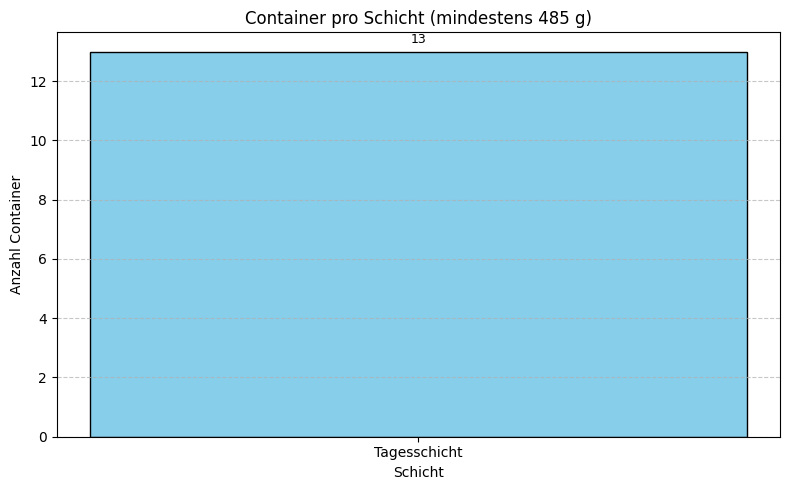

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0. CSV-Datei einlesen (Pfad anpassen: Colab oder Sandbox)
# ------------------------------------------------------------------
csv_path = "/content/processed_data_for_sql.csv"  # ggf. "/mnt/data/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 1. SQLite-Datenbank im RAM erstellen und DataFrame in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 2. Container-ID vergeben: Wenn weight_g < 10 → neuer Container beginnt
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'])

# ------------------------------------------------------------------
# 3. Filter auf „echte“ Container: Nur solche, deren max_weight ≥ 485 g
# ------------------------------------------------------------------
min_weight_threshold = 485  # Minimalgewicht in Gramm
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= min_weight_threshold]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------
# 4. Startzeit pro Container ermitteln (erste Messung jedes Containers)
# ------------------------------------------------------------------
times_df = (
    valid_df
    .groupby('container_id')['timestamp']
    .min()
    .reset_index(name='start_time')
)

# ------------------------------------------------------------------
# 5. Schichtzuordnung basierend auf start_time
#     - Tagesschicht: 06:00–17:59
#     - Nachtschicht: 18:00–05:59
# ------------------------------------------------------------------
def assign_shift(ts):
    hour = ts.hour
    if 6 <= hour < 18:
        return "Tagesschicht"
    else:
        return "Nachtschicht"

times_df['shift'] = times_df['start_time'].apply(assign_shift)

# ------------------------------------------------------------------
# 6. Gesamtanzahl der „echten“ Container pro Schicht ermitteln
# ------------------------------------------------------------------
containers_per_shift = (
    times_df
    .groupby('shift')['container_id']
    .nunique()
    .reset_index(name='gesamt_container')
)

# ------------------------------------------------------------------
# 7. Tabelle ausgeben: shift, gesamt_container
# ------------------------------------------------------------------
print("=== Tabelle: Anzahl der Container pro Schicht (min. 485 g) ===")
print(containers_per_shift.to_string(index=False))

# ------------------------------------------------------------------
# 8. Visualisierung: Balkendiagramm der Container pro Schicht
# ------------------------------------------------------------------
plt.figure(figsize=(8, 5))
bars = plt.bar(
    containers_per_shift['shift'],
    containers_per_shift['gesamt_container'],
    color=['skyblue', 'gray'],
    edgecolor='black'
)

plt.xlabel('Schicht')
plt.ylabel('Anzahl Container')
plt.title('Container pro Schicht (mindestens 485 g)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 8.1. Beschriftung: Anzahl über jedem Balken anzeigen
for bar, count in zip(bars, containers_per_shift['gesamt_container']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(
        x,
        y + 0.2,
        str(int(count)),
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

plt.tight_layout()
plt.show()


#14.Gesamtgewicht der produzierten Ware

=== Tabelle: Gesamtgewicht der produzierten Ware pro Schicht (kg) ===
       shift  total_weight_kg
Tagesschicht             6.65


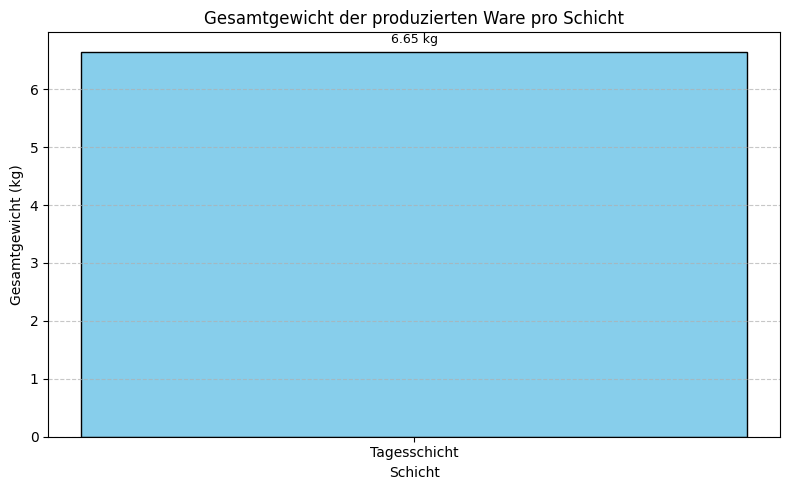

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0. Hilfsfunktion: Run-Length-Encoding zur Plateau-Erkennung
# ------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    """
    Extrahiert aus einer Liste von Gewichtsmessungen alle Plateau-Werte (Runs),
    bei denen derselbe Wert mindestens `min_run_len`-mal hintereinander auftritt.
    Gibt die Plateau-Gewichte in der Reihenfolge zurück, in der sie erscheinen.
    """
    plateaus = []
    current_weight = None
    run_length = 0

    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)
    return plateaus

# ------------------------------------------------------------------
# 1. CSV-Datei einlesen (Colab-Pfad oder Sandbox-Pfad)
# ------------------------------------------------------------------
csv_path = "/content/processed_data_for_sql.csv"  # ggf. "/mnt/data/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2. SQLite-DB im RAM erstellen und DataFrame in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 3. Container-ID vergeben: Jedes Mal, wenn weight_g < 10 → neuer Container
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'])

# ------------------------------------------------------------------
# 4. **Kein** Filter auf „echte“ Container: Wir berücksichtigen alle Container-IDs
# ------------------------------------------------------------------
valid_df = assigned_df.copy()

# ------------------------------------------------------------------
# 5. Pro Container: Finale Plateau-Gewichte bestimmen (Füllgewicht)
# ------------------------------------------------------------------
container_weights = []
for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)
    weight_sequence = grp['weight_g'].tolist()

    # 5.1. Plateaus extrahieren (Runs gleicher Werte mit Länge ≥ 3)
    plateau_weights = extract_plateau_weights(weight_sequence, min_run_len=3)

    # 5.2. Finale Plateau-Gewicht bestimmen:
    #      - Wenn keine Plateaus, letztes gemessenes Gewicht verwenden
    if not plateau_weights:
        final_plateau = weight_sequence[-1]
    else:
        final_plateau = plateau_weights[-1]

    # 5.3. Startzeitpunkt des Containers (erste Messung)
    start_time = grp['timestamp'].iloc[0]

    container_weights.append({
        'container_id': container_id,
        'start_time': start_time,
        'final_weight_g': round(final_plateau, 1)
    })

cw_df = pd.DataFrame(container_weights)

# ------------------------------------------------------------------
# 6. Schichtzuordnung basierend auf start_time
#     - Tagesschicht: 06:00–17:59
#     - Nachtschicht: 18:00–05:59
# ------------------------------------------------------------------
def assign_shift(ts):
    hour = ts.hour
    if 6 <= hour < 18:
        return "Tagesschicht"
    else:
        return "Nachtschicht"

cw_df['shift'] = cw_df['start_time'].apply(assign_shift)

# ------------------------------------------------------------------
# 7. Gesamtgewicht der produzierten Ware pro Schicht berechnen
# ------------------------------------------------------------------
weight_per_shift = (
    cw_df
    .groupby('shift')['final_weight_g']
    .sum()
    .reset_index(name='total_weight_g')
)

# In Kilogramm umrechnen und auf 2 Nachkommastellen runden
weight_per_shift['total_weight_kg'] = (weight_per_shift['total_weight_g'] / 1000).round(2)

# ------------------------------------------------------------------
# 8. Tabelle ausgeben: shift, total_weight_kg
# ------------------------------------------------------------------
print("=== Tabelle: Gesamtgewicht der produzierten Ware pro Schicht (kg) ===")
print(weight_per_shift[['shift', 'total_weight_kg']].to_string(index=False))

# ------------------------------------------------------------------
# 9. Visualisierung: Balkendiagramm des Gesamtgewichts
# ------------------------------------------------------------------
plt.figure(figsize=(8, 5))
bars = plt.bar(
    weight_per_shift['shift'],
    weight_per_shift['total_weight_kg'],
    color=['skyblue', 'gray'],
    edgecolor='black'
)

plt.xlabel('Schicht')
plt.ylabel('Gesamtgewicht (kg)')
plt.title('Gesamtgewicht der produzierten Ware pro Schicht')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 9.1. Beschriftung: Gesamtgewicht über jedem Balken anzeigen
for bar, gw in zip(bars, weight_per_shift['total_weight_kg']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(
        x, y + 0.1, f"{gw} kg",
        ha='center', va='bottom', fontsize=9, color='black'
    )

plt.tight_layout()
plt.show()


#15.Produktivität pro Einheit (Stück/h)

=== Tabelle: Produktivität pro Einheit (Einheiten/Stunde) ===
       shift  gesamt_einheiten  arbeitsstunden  produktitaet_stueck_pro_h
Tagesschicht               154              12                       12.8


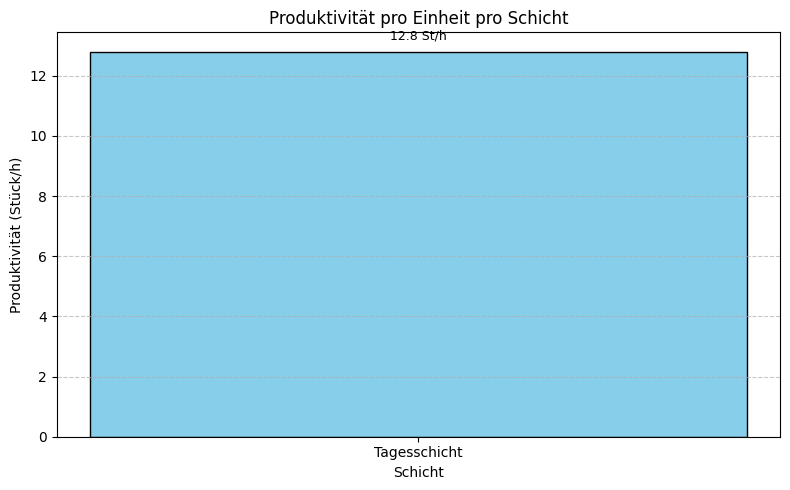

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0. Hilfsfunktion: Run-Length-Encoding zur Plateau-Erkennung
# ------------------------------------------------------------------
def extract_plateaus_with_times(df_group, min_run_len=3, noise_thresh=1.0):
    """
    Für eine sortierte Gruppe (DataFrame) mit 'weight_g' und 'timestamp' liefert
    eine Liste von Zeitpunkten (timestamp), an denen eine neue Einheit (Kohlkopf)
    hinzugefügt wurde. Kleine Schwankungen (|delta| ≤ noise_thresh) werden ignoriert.
    """
    plateaus = []
    current_weight = None
    run_length = 0
    start_time = None

    weights = df_group['weight_g'].tolist()
    times = df_group['timestamp'].tolist()

    for idx, w in enumerate(weights):
        if w == current_weight:
            run_length += 1
        else:
            # Vorherigen Run prüfen
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append((current_weight, start_time))
            current_weight = w
            run_length = 1
            start_time = times[idx]
    # Letzten Run prüfen
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append((current_weight, start_time))

    # Aus Plateau-Liste nur die Zeitpunkte auswählen, bei denen delta > noise_thresh
    unit_times = []
    for i in range(len(plateaus)):
        weight_i, time_i = plateaus[i]
        if i == 0:
            if weight_i > 0:
                unit_times.append(time_i)
        else:
            weight_prev, _ = plateaus[i-1]
            delta = weight_i - weight_prev
            if delta > noise_thresh:
                unit_times.append(time_i)
            # Negative oder kleine deltas werden ignoriert
    return unit_times

# ------------------------------------------------------------------
# 1. CSV-Datei einlesen (Pfad anpassen: Colab oder Sandbox)
# ------------------------------------------------------------------
csv_path = "/content/processed_data_for_sql.csv"  # ggf. "/mnt/data/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2. SQLite‐DB im Arbeitsspeicher erstellen und DataFrame in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 3. Container‐ID vergeben: Jedes Mal, wenn weight_g < 10 → neuer Container beginnt
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'])

# ------------------------------------------------------------------
# 4. **Kein** Filter auf „echte“ Container: Wir berücksichtigen alle Container-IDs
# ------------------------------------------------------------------
valid_df = assigned_df.copy()

# ------------------------------------------------------------------
# 5. Alle Einheit-Zeitpunkte sammeln
# ------------------------------------------------------------------
all_unit_times = []
for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)
    unit_times = extract_plateaus_with_times(grp, min_run_len=3, noise_thresh=1.0)
    all_unit_times.extend(unit_times)

unit_times_df = pd.DataFrame({"unit_time": all_unit_times})

# ------------------------------------------------------------------
# 6. Schichtzuordnung für jeden Einheit-Zeitpunkt (2 × 12h-Schichten)
#     Tagesschicht: 06:00–17:59, Nachtschicht: 18:00–05:59
# ------------------------------------------------------------------
def assign_shift(ts):
    hour = ts.hour
    if 6 <= hour < 18:
        return "Tagesschicht"
    else:
        return "Nachtschicht"

unit_times_df['shift'] = unit_times_df['unit_time'].apply(assign_shift)

# ------------------------------------------------------------------
# 7. Gesamtanzahl der Einheiten pro Schicht ermitteln
# ------------------------------------------------------------------
units_per_shift = (
    unit_times_df
    .groupby('shift')['unit_time']
    .count()
    .reset_index(name='gesamt_einheiten')
)

# ------------------------------------------------------------------
# 8. Arbeitsstunden pro Schicht definieren (je Schicht 12 Stunden)
# ------------------------------------------------------------------
# Tagesschicht und Nachtschicht sind jeweils 12‐Stunden‐Zeiträume
shift_hours = pd.DataFrame({
    "shift": ["Tagesschicht", "Nachtschicht"],
    "arbeitsstunden": [12, 12]
})

# ------------------------------------------------------------------
# 9. Produktivität pro Einheit berechnen (Einheiten / Arbeitsstunden)
# ------------------------------------------------------------------
prod_df = units_per_shift.merge(shift_hours, on="shift")
prod_df['produktitaet_stueck_pro_h'] = (
    prod_df['gesamt_einheiten'] / prod_df['arbeitsstunden']
).round(1)

# ------------------------------------------------------------------
# 10. Tabelle ausgeben: shift, gesamt_einheiten, arbeitsstunden, produktivität
# ------------------------------------------------------------------
print("=== Tabelle: Produktivität pro Einheit (Einheiten/Stunde) ===")
print(prod_df[['shift', 'gesamt_einheiten', 'arbeitsstunden', 'produktitaet_stueck_pro_h']].to_string(index=False))

# ------------------------------------------------------------------
# 11. Visualisierung: Balkendiagramm der Produktivität
# ------------------------------------------------------------------
plt.figure(figsize=(8, 5))
bars = plt.bar(
    prod_df['shift'],
    prod_df['produktitaet_stueck_pro_h'],
    color=['skyblue', 'gray'],
    edgecolor='black'
)

plt.xlabel('Schicht')
plt.ylabel('Produktivität (Stück/h)')
plt.title('Produktivität pro Einheit pro Schicht')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 11.1. Beschriftung: Produktivitätswert über jedem Balken anzeigen
for bar, val in zip(bars, prod_df['produktitaet_stueck_pro_h']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(
        x, y + 0.3, f"{val} St/h",
        ha='center', va='bottom', fontsize=9, color='black'
    )

plt.tight_layout()
plt.show()


#16.Produktivität pro Gewicht

=== Tabelle: Produktivität pro Gewicht (kg/h) ===
       shift  total_weight_kg  arbeitsstunden  produktitaet_kg_pro_h
Tagesschicht             6.65              12                    0.6


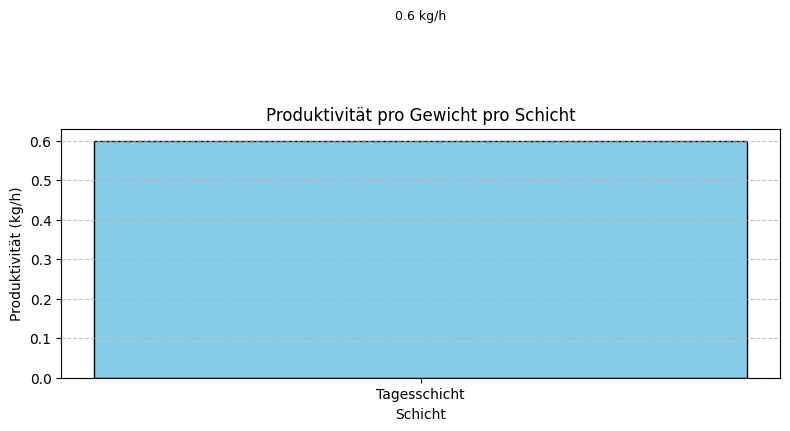

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0. Hilfsfunktion: Run-Length-Encoding zur Plateau-Erkennung
# ------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    """
    Extrahiert aus einer Liste von Gewichtsmessungen alle Plateau-Werte (Runs),
    bei denen derselbe Wert mindestens `min_run_len`-mal hintereinander auftritt.
    Gibt die Plateau-Gewichte in der Reihenfolge zurück, in der sie erscheinen.
    """
    plateaus = []
    current_weight = None
    run_length = 0

    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)
    return plateaus

# ------------------------------------------------------------------
# 1. CSV-Datei einlesen (Pfad anpassen: Colab oder Sandbox)
# ------------------------------------------------------------------
csv_path = "/content/processed_data_for_sql.csv"  # bzw. "/mnt/data/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2. SQLite-DB im Arbeitsspeicher erstellen und DataFrame in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 3. Container-ID vergeben: Wenn weight_g < 10, beginnt ein neuer Container
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'])

# ------------------------------------------------------------------
# 4. **Kein** Filter auf echte Container: Wir berücksichtigen alle Container-IDs
# ------------------------------------------------------------------
valid_df = assigned_df.copy()

# ------------------------------------------------------------------
# 5. Pro Container: Finale Plateau-Gewichte bestimmen (Füllgewicht)
# ------------------------------------------------------------------
container_weights = []
for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)
    weight_sequence = grp['weight_g'].tolist()

    # 5.1. Plateaus extrahieren (Runs gleicher Werte mit Länge ≥ 3)
    plateau_weights = extract_plateau_weights(weight_sequence, min_run_len=3)

    # 5.2. Finale Plateau-Gewicht ermitteln:
    #      - Wenn keine Plateaus gefunden, letztes gemessenes Gewicht verwenden
    if not plateau_weights:
        final_plateau = weight_sequence[-1]
    else:
        final_plateau = plateau_weights[-1]

    # 5.3. Startzeitpunkt des Containers (erste Messung)
    start_time = grp['timestamp'].iloc[0]

    container_weights.append({
        'container_id': container_id,
        'start_time': start_time,
        'final_weight_g': round(final_plateau, 1)
    })

cw_df = pd.DataFrame(container_weights)

# ------------------------------------------------------------------
# 6. Schichtzuordnung basierend auf start_time
#     - Tagesschicht: 06:00–17:59
#     - Nachtschicht: 18:00–05:59
# ------------------------------------------------------------------
def assign_shift(ts):
    hour = ts.hour
    if 6 <= hour < 18:
        return "Tagesschicht"
    else:
        return "Nachtschicht"

cw_df['shift'] = cw_df['start_time'].apply(assign_shift)

# ------------------------------------------------------------------
# 7. Gesamtgewicht pro Schicht berechnen (in Gramm)
# ------------------------------------------------------------------
weight_per_shift = (
    cw_df
    .groupby('shift')['final_weight_g']
    .sum()
    .reset_index(name='total_weight_g')
)

# In Kilogramm umrechnen und auf 2 Nachkommastellen runden
weight_per_shift['total_weight_kg'] = (weight_per_shift['total_weight_g'] / 1000).round(2)

# ------------------------------------------------------------------
# 8. Arbeitsstunden pro Schicht definieren (je Schicht 12 Stunden)
# ------------------------------------------------------------------
shift_hours = pd.DataFrame({
    "shift": ["Tagesschicht", "Nachtschicht"],
    "arbeitsstunden": [12, 12]
})

# ------------------------------------------------------------------
# 9. Produktivität pro Gewicht berechnen (kg / Stunde)
# ------------------------------------------------------------------
prod_weight_df = weight_per_shift.merge(shift_hours, on="shift")
prod_weight_df['produktitaet_kg_pro_h'] = (
    prod_weight_df['total_weight_kg'] / prod_weight_df['arbeitsstunden']
).round(1)

# ------------------------------------------------------------------
# 10. Tabelle ausgeben: shift, total_weight_kg, arbeitsstunden, produktivität
# ------------------------------------------------------------------
print("=== Tabelle: Produktivität pro Gewicht (kg/h) ===")
print(prod_weight_df[['shift', 'total_weight_kg', 'arbeitsstunden', 'produktitaet_kg_pro_h']].to_string(index=False))

# ------------------------------------------------------------------
# 11. Visualisierung: Balkendiagramm der Produktivität (kg/h)
# ------------------------------------------------------------------
plt.figure(figsize=(8, 5))
bars = plt.bar(
    prod_weight_df['shift'],
    prod_weight_df['produktitaet_kg_pro_h'],
    color=['skyblue', 'gray'],
    edgecolor='black'
)

plt.xlabel('Schicht')
plt.ylabel('Produktivität (kg/h)')
plt.title('Produktivität pro Gewicht pro Schicht')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 11.1. Beschriftung: kg/h-Wert über jedem Balken anzeigen
for bar, val in zip(bars, prod_weight_df['produktitaet_kg_pro_h']):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(
        x, y + 0.3, f"{val} kg/h",
        ha='center', va='bottom', fontsize=9, color='black'
    )

plt.tight_layout()
plt.show()


#17.Abfallmenge (Produktionsverlust(kg))

Rohgewicht – Ist-Gewicht

=== Gesamtverlust in der Verarbeitung ===
Rohgesamtgewicht aller Paletten: 7000 g
Istgesamtgewicht (Container):       6649.0 g
Verlust in der Verarbeitung:         351.0 g  (0.351 kg)


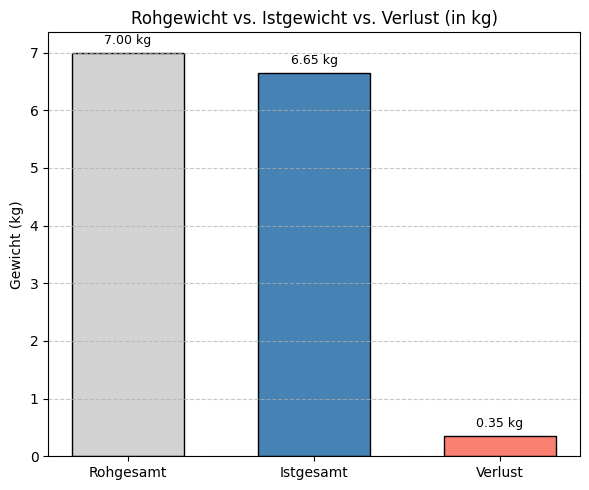

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0. Manuelle Definition der Paletten-Gewichte
#    Jede Palette hat individuelle Rohgewichte in Gramm
# ------------------------------------------------------------------
df_pallets = pd.DataFrame({
    'pallet_id': [1, 2, 3],
    'rohgewicht_g': [2400, 2500, 2100]
})
# Gesamt-Rohgewicht aller Paletten (in Gramm)
rohgesamt_g = df_pallets['rohgewicht_g'].sum()

# ------------------------------------------------------------------
# 1. Container-Messdaten einlesen (processed_data_for_sql.csv)
#    Spalten: timestamp (ohne zwingende Mikrosekunden), weight_g
# ------------------------------------------------------------------
container_csv = "/content/processed_data_for_sql.csv"
df_cont = pd.read_csv(container_csv)

# ------------------------------------------------------------------
# 2. SQLite-Datenbank im RAM erstellen und Messdaten in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df_cont.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 3. Container-ID vergeben: Wenn weight_g < 10 → neuer Container beginnt
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)

# ------------------------------------------------------------------
# 4. Timestamp-Spalte konvertieren (inkonsistente Formate erlauben)
# ------------------------------------------------------------------
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'], errors='coerce')

# ------------------------------------------------------------------
# 5. Finale Plateau-Gewichte pro Container bestimmen (Füllgewicht)
# ------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    plateaus = []
    current_weight = None
    run_length = 0
    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)
    return plateaus

container_weights = []
for cid, grp in assigned_df.groupby('container_id'):
    grp_sorted = grp.sort_values('timestamp').reset_index(drop=True)
    weights = grp_sorted['weight_g'].tolist()
    plateaus = extract_plateau_weights(weights, min_run_len=3)
    final_plateau = plateaus[-1] if plateaus else weights[-1]
    container_weights.append(round(final_plateau, 1))

# ------------------------------------------------------------------
# 6. Ist-Gesamtgewicht berechnen (Summe aller finalen Containergewichte, in Gramm)
# ------------------------------------------------------------------
istgesamt_g = sum(container_weights)

# ------------------------------------------------------------------
# 7. Gesamt-Verlust in der Verarbeitung berechnen (in Gramm und kg)
#    Neuer KPI: Rohgesamtgewicht - Istgesamtgewicht, in Kilogramm
# ------------------------------------------------------------------
verlust_g = rohgesamt_g - istgesamt_g
verlust_kg = round(verlust_g / 1000, 3)

# ------------------------------------------------------------------
# 8. Ergebnis ausgeben (Gramm und Kilogramm)
# ------------------------------------------------------------------
print("=== Gesamtverlust in der Verarbeitung ===")
print(f"Rohgesamtgewicht aller Paletten: {rohgesamt_g} g")
print(f"Istgesamtgewicht (Container):       {istgesamt_g} g")
print(f"Verlust in der Verarbeitung:         {verlust_g} g  ({verlust_kg} kg)")

# ------------------------------------------------------------------
# 9. Visualisierung: Roh vs. Ist vs. Verlust in kg
# ------------------------------------------------------------------
labels = ['Rohgesamt', 'Istgesamt', 'Verlust']
werte_kg = [rohgesamt_g / 1000, istgesamt_g / 1000, verlust_kg]
farben = ['lightgray', 'steelblue', 'salmon']

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, werte_kg, color=farben, edgecolor='black', width=0.6)

plt.ylabel('Gewicht (kg)')
plt.title('Rohgewicht vs. Istgewicht vs. Verlust (in kg)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, val in zip(bars, werte_kg):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(x, y + 0.1, f"{val:.2f} kg", ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


#18.Verlust in der Verarbeitung (%)

(Rohgewicht – Ist) / Rohgewicht × 100




=== Gesamtverlust in der Verarbeitung ===
Rohgesamtgewicht aller Paletten: 7000 g
Istgesamtgewicht (Container): 6649.0 g
Verlust in der Verarbeitung: 5.0 %


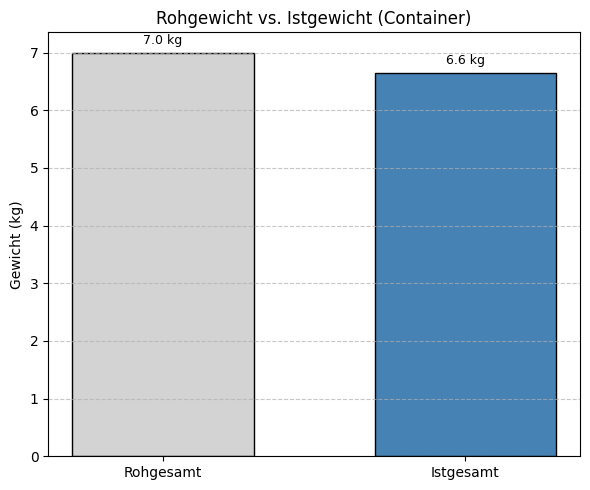

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0. Manuelle Definition der Paletten-Gewichte
#    Jede Palette hat individuelle Rohgewichte in Gramm
# ------------------------------------------------------------------
df_pallets = pd.DataFrame({
    'pallet_id': [1, 2, 3],
    'rohgewicht_g': [2400, 2500, 2100]
})
# Gesamt-Rohgewicht aller Paletten
rohgesamt_g = df_pallets['rohgewicht_g'].sum()

# ------------------------------------------------------------------
# 1. Container-Messdaten einlesen (processed_data_for_sql.csv)
#    Spalten: timestamp (ohne zwingende Mikrosekunden), weight_g
# ------------------------------------------------------------------
container_csv = "/content/processed_data_for_sql.csv"
df_cont = pd.read_csv(container_csv)

# ------------------------------------------------------------------
# 2. SQLite-Datenbank im RAM erstellen und Messdaten in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df_cont.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 3. Container-ID vergeben: Wenn weight_g < 10 → neuer Container beginnt
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)

# ------------------------------------------------------------------
# 4. Timestamp-Spalte konvertieren (inkonsistente Formate erlauben)
# ------------------------------------------------------------------
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'], errors='coerce')

# ------------------------------------------------------------------
# 5. Finale Plateau-Gewichte pro Container bestimmen (Füllgewicht)
# ------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    plateaus = []
    current_weight = None
    run_length = 0
    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)
    return plateaus

container_weights = []
for cid, grp in assigned_df.groupby('container_id'):
    grp_sorted = grp.sort_values('timestamp').reset_index(drop=True)
    weights = grp_sorted['weight_g'].tolist()
    plateaus = extract_plateau_weights(weights, min_run_len=3)
    final_plateau = plateaus[-1] if plateaus else weights[-1]
    container_weights.append(round(final_plateau, 1))

# ------------------------------------------------------------------
# 6. Ist-Gesamtgewicht berechnen (Summe aller finalen Containergewichte)
# ------------------------------------------------------------------
istgesamt_g = sum(container_weights)

# ------------------------------------------------------------------
# 7. Gesamt-Verlust in der Verarbeitung berechnen (in Prozent)
#    Formel: (rohgesamt_g - istgesamt_g) / rohgesamt_g × 100
# ------------------------------------------------------------------
verlust_pct = round((rohgesamt_g - istgesamt_g) / rohgesamt_g * 100, 1)

# ------------------------------------------------------------------
# 8. Ergebnis ausgeben
# ------------------------------------------------------------------
print("=== Gesamtverlust in der Verarbeitung ===")
print(f"Rohgesamtgewicht aller Paletten: {rohgesamt_g} g")
print(f"Istgesamtgewicht (Container): {istgesamt_g} g")
print(f"Verlust in der Verarbeitung: {verlust_pct} %")

# ------------------------------------------------------------------
# 9. Visualisierung: Roh vs. Ist in kg
# ------------------------------------------------------------------
labels = ['Rohgesamt', 'Istgesamt']
werte_kg = [rohgesamt_g / 1000, istgesamt_g / 1000]
farben = ['lightgray', 'steelblue']

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, werte_kg, color=farben, edgecolor='black', width=0.6)

plt.ylabel('Gewicht (kg)')
plt.title('Rohgewicht vs. Istgewicht (Container)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, val in zip(bars, werte_kg):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    plt.text(x, y + 0.1, f"{val:.1f} kg", ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


#19.Sortierqualität (% Stücke außerhalb der Gewichtstoleranz)

=== Sortierqualität (Anteil Einheiten außerhalb der Gewichtstoleranz) ===
MIN-Toleranz: 25 g, MAX-Toleranz: 80 g
Gesamt-Einheiten: 140
Defekte Einheiten: 11
Sortierqualität: 7.9 %

=== Defekte Einheiten im Detail ===
 container_id  unit_weight_g                  unit_time
          268           12.5 2025-06-02 08:30:25.032700
          424           22.5 2025-06-02 08:31:03.059800
          424           15.5 2025-06-02 08:31:11.044900
          913           16.5 2025-06-02 08:33:41.076300
          913           23.5 2025-06-02 08:33:57.076400
         1031           24.0 2025-06-02 08:34:41.001500
         1118           18.0 2025-06-02 08:35:47.031800
         1118           23.5 2025-06-02 08:35:52.008800
         1118           23.5 2025-06-02 08:36:13.046800
         1178           23.5 2025-06-02 08:36:58.060000
         1244           23.5 2025-06-02 08:37:22.085100


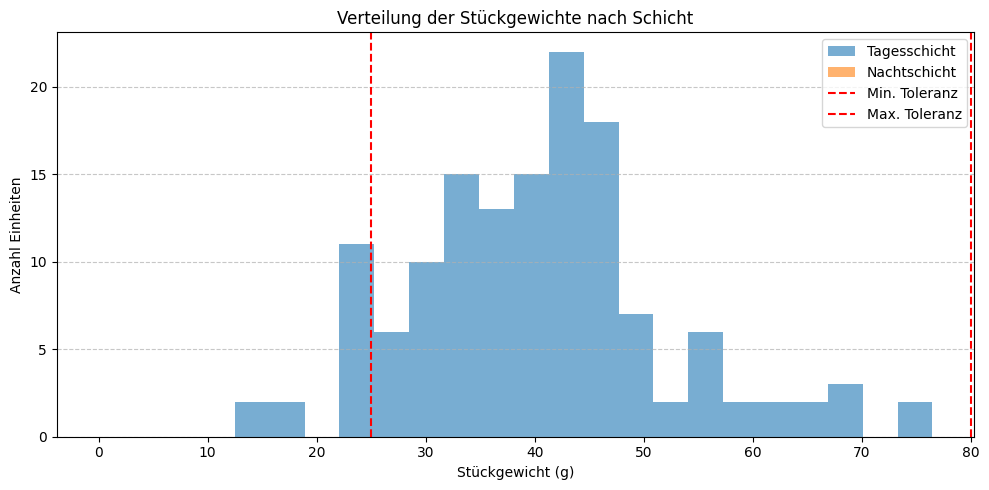

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 0. Parameter: Gewichtstoleranz und Rauschschwelle definieren
# ------------------------------------------------------------------
MIN_TARGET_WEIGHT = 25    # minimale zulässige Gewicht (g)
MAX_TARGET_WEIGHT = 80    # maximale zulässige Gewicht (g)
NOISE_THRESHOLD = 1.0      # Gewichtsschwellwert (g), um kleine Schwankungen zu ignorieren

# ------------------------------------------------------------------
# 1. CSV-Datei einlesen (Pfad anpassen: Colab oder Sandbox)
#    Spalten: timestamp, weight_g
# ------------------------------------------------------------------
csv_path = "/content/processed_data_for_sql.csv"  # ggf. "/mnt/data/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2. SQLite-Datenbank im RAM erstellen und DataFrame in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 3. Container-ID vergeben: Wenn weight_g < 10 → neuer Container beginnt
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'], errors='coerce')

# ------------------------------------------------------------------
# 4. Hilfsfunktion: Plateaus mit Zeitpunkten extrahieren
# ------------------------------------------------------------------
def extract_plateaus_with_times(df_group, min_run_len=3):
    """
    Für eine sortierte Gruppe (DataFrame) mit 'weight_g' und 'timestamp'
    liefert diese Funktion eine Liste von (plateau_weight, timestamp)-Tupeln,
    wenn derselbe weight_g mindestens `min_run_len`-mal hintereinander auftritt.
    """
    plateaus = []
    current_weight = None
    run_length = 0
    start_time = None

    weights = df_group['weight_g'].tolist()
    times = df_group['timestamp'].tolist()

    for idx, w in enumerate(weights):
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append((current_weight, start_time))
            current_weight = w
            run_length = 1
            start_time = times[idx]
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append((current_weight, start_time))
    return plateaus

# ------------------------------------------------------------------
# 5. Aus Plateaus die Stückgewichte und Zeitpunkte berechnen (Rauschfilter)
# ------------------------------------------------------------------
unit_records = []  # Liste für alle Einheiten: container_id, weight, timestamp

for container_id, group in assigned_df.groupby('container_id'):
    grp_sorted = group.sort_values('timestamp').reset_index(drop=True)
    plateaus = extract_plateaus_with_times(grp_sorted, min_run_len=3)
    for i in range(1, len(plateaus)):
        weight_prev, _ = plateaus[i-1]
        weight_curr, time_curr = plateaus[i]
        delta = weight_curr - weight_prev
        # Nur hinzufügen, wenn delta > NOISE_THRESHOLD und delta > 0
        if delta > NOISE_THRESHOLD:
            unit_records.append({
                'container_id': container_id,
                'unit_weight_g': round(delta, 1),
                'unit_time': time_curr
            })

units_df = pd.DataFrame(unit_records)

# ------------------------------------------------------------------
# 6. Sortierqualität berechnen: Einheiten außerhalb der Toleranz identifizieren
# ------------------------------------------------------------------
gesamt_einheiten = len(units_df)

defective_df = units_df[
    (units_df['unit_weight_g'] < MIN_TARGET_WEIGHT) |
    (units_df['unit_weight_g'] > MAX_TARGET_WEIGHT)
].copy()

anzahl_defekte = len(defective_df)
sortierqualität_pct = round((anzahl_defekte / gesamt_einheiten * 100), 1) if gesamt_einheiten > 0 else 0.0

# ------------------------------------------------------------------
# 7. Schichtzuordnung für jeden Einheitszeitpunkt (Tagesschicht/Nachtschicht)
# ------------------------------------------------------------------
def assign_shift(ts):
    hour = ts.hour
    if 6 <= hour < 18:
        return "Tagesschicht"
    else:
        return "Nachtschicht"

units_df['shift'] = units_df['unit_time'].apply(assign_shift)
defective_df['shift'] = defective_df['unit_time'].apply(assign_shift)

# ------------------------------------------------------------------
# 8. Ergebnis-Tabelle ausgeben
# ------------------------------------------------------------------
print("=== Sortierqualität (Anteil Einheiten außerhalb der Gewichtstoleranz) ===")
print(f"MIN-Toleranz: {MIN_TARGET_WEIGHT} g, MAX-Toleranz: {MAX_TARGET_WEIGHT} g")
print(f"Gesamt-Einheiten: {gesamt_einheiten}")
print(f"Defekte Einheiten: {anzahl_defekte}")
print(f"Sortierqualität: {sortierqualität_pct} %\n")

print("=== Defekte Einheiten im Detail ===")
print(defective_df[['container_id', 'unit_weight_g', 'unit_time']].to_string(index=False))

# ------------------------------------------------------------------
# 9. Visualisierung: Histogramm der Stückgewichte nach Schicht
# ------------------------------------------------------------------
plt.figure(figsize=(10, 5))

# Histogramm Tagesschicht
plt.hist(
    units_df[units_df['shift'] == 'Tagesschicht']['unit_weight_g'],
    bins=20, alpha=0.6, label='Tagesschicht'
)

# Histogramm Nachtschicht
plt.hist(
    units_df[units_df['shift'] == 'Nachtschicht']['unit_weight_g'],
    bins=20, alpha=0.6, label='Nachtschicht'
)

plt.axvline(MIN_TARGET_WEIGHT, color='red', linestyle='--', label='Min. Toleranz')
plt.axvline(MAX_TARGET_WEIGHT, color='red', linestyle='--', label='Max. Toleranz')

plt.xlabel('Stückgewicht (g)')
plt.ylabel('Anzahl Einheiten')
plt.title('Verteilung der Stückgewichte nach Schicht')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


#20.Gewichtsstreuung bei Einheiten

--- Tagesschicht ---
Mittleres Stückgewicht: 40.2 g
Standardabweichung σ: 11.9 g → Akzeptabler Bereich (10 g ≤ σ ≤ 30 g)

=== Problematische Einheiten (Abweichung > 30 g) ===
 container_id  unit_weight_g                  unit_time        shift
         1031           76.5 2025-06-02 08:34:33.035600 Tagesschicht
         1077           75.0 2025-06-02 08:35:27.013700 Tagesschicht


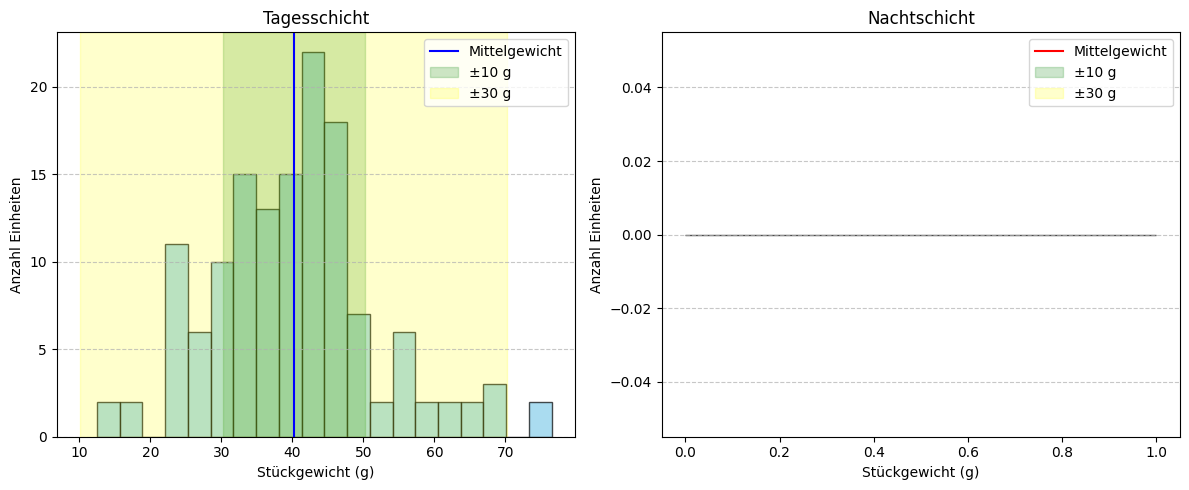

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------------
# 0. Parameter: Gewichtstoleranz-Schwellen und Rauschschwelle
# ------------------------------------------------------------------
SIGMA_LOW = 10         # σ < 10 g: Sehr präzises Sortieren
SIGMA_MED = 30         # 10 ≤ σ ≤ 30 g: Akzeptabler Bereich
# σ > 30 g: Problematisch
NOISE_THRESHOLD = 1.0  # Gewichtsschwellwert (g), um kleine Schwankungen zu ignorieren

# ------------------------------------------------------------------
# 1. CSV-Datei einlesen (Pfad anpassen: Colab oder Sandbox)
#    Spalten: timestamp, weight_g
# ------------------------------------------------------------------
csv_path = "/content/processed_data_for_sql.csv"  # ggf. "/mnt/data/processed_data_for_sql.csv"
df = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2. SQLite-Datenbank im RAM erstellen und DataFrame in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 3. Container-ID vergeben: Wenn weight_g < 10 → neuer Container beginnt
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'], errors='coerce')

# ------------------------------------------------------------------
# 4. Hilfsfunktion: Plateaus mit Zeitpunkten extrahieren
# ------------------------------------------------------------------
def extract_plateaus_with_times(df_group, min_run_len=3):
    """
    Für eine sortierte Gruppe (DataFrame) mit 'weight_g' und 'timestamp'
    liefert diese Funktion eine Liste von (plateau_weight, timestamp)-Tupeln,
    wenn derselbe weight_g mindestens `min_run_len`-mal hintereinander auftritt.
    """
    plateaus = []
    current_weight = None
    run_length = 0
    start_time = None

    weights = df_group['weight_g'].tolist()
    times = df_group['timestamp'].tolist()

    for idx, w in enumerate(weights):
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append((current_weight, start_time))
            current_weight = w
            run_length = 1
            start_time = times[idx]
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append((current_weight, start_time))
    return plateaus

# ------------------------------------------------------------------
# 5. Einheitengewicht (Kohlkopf) und Zeitpunkte berechnen (mit Rauschfilter)
# ------------------------------------------------------------------
unit_records = []  # container_id, unit_weight_g, unit_time

for container_id, group in assigned_df.groupby('container_id'):
    grp_sorted = group.sort_values('timestamp').reset_index(drop=True)
    plateaus = extract_plateaus_with_times(grp_sorted, min_run_len=3)
    for i in range(1, len(plateaus)):
        weight_prev, _ = plateaus[i-1]
        weight_curr, time_curr = plateaus[i]
        delta = weight_curr - weight_prev
        # Nur hinzufügen, wenn delta > NOISE_THRESHOLD (Rauschen ignorieren)
        if delta > NOISE_THRESHOLD:
            unit_records.append({
                'container_id': container_id,
                'unit_weight_g': round(delta, 1),
                'unit_time': time_curr
            })

units_df = pd.DataFrame(unit_records)

# ------------------------------------------------------------------
# 6. Schichtzuordnung für jeden Einheit-Zeitpunkt
#     - Tagesschicht: 06:00–17:59
#     - Nachtschicht: 18:00–05:59
# ------------------------------------------------------------------
def assign_shift(ts):
    hour = ts.hour
    if 6 <= hour < 18:
        return "Tagesschicht"
    else:
        return "Nachtschicht"

units_df['shift'] = units_df['unit_time'].apply(assign_shift)

# ------------------------------------------------------------------
# 7. Mittelwert und Standardabweichung pro Schicht berechnen
# ------------------------------------------------------------------
stats = units_df.groupby('shift')['unit_weight_g'].agg(
    mittelgewicht_g='mean',
    sigma_g='std'
).reset_index()

# 7.1. Qualitätsbewertung anhand von σ
def bewertung_sigma(sigma):
    if sigma < SIGMA_LOW:
        return "Sehr präzises Sortieren (σ < 10 g)"
    elif sigma <= SIGMA_MED:
        return "Akzeptabler Bereich (10 g ≤ σ ≤ 30 g)"
    else:
        return "Problematisch (σ > 30 g)"

stats['bewertung'] = stats['sigma_g'].apply(lambda s: bewertung_sigma(s if not np.isnan(s) else 0))

# ------------------------------------------------------------------
# 8. Interpretation und Ausgabe der Ergebnisse
# ------------------------------------------------------------------
for _, row in stats.iterrows():
    shift = row['shift']
    mean_w = row['mittelgewicht_g']
    sigma = row['sigma_g']
    bewertung = row['bewertung']
    print(f"--- {shift} ---")
    print(f"Mittleres Stückgewicht: {mean_w:.1f} g")
    print(f"Standardabweichung σ: {sigma:.1f} g → {bewertung}")
    print()

# ------------------------------------------------------------------
# 9. Problematische Einheiten (Abweichung > SIGMA_MED) auflisten
# ------------------------------------------------------------------
print("=== Problematische Einheiten (Abweichung > 30 g) ===")
problematic_list = []

for _, row in stats.iterrows():
    shift = row['shift']
    mean_w = row['mittelgewicht_g']
    # Filter: Einheiten, deren Gewicht um mehr als SIGMA_MED vom Schichtmittel abweicht
    df_shift = units_df[units_df['shift'] == shift]
    df_problem = df_shift[abs(df_shift['unit_weight_g'] - mean_w) > SIGMA_MED]
    if not df_problem.empty:
        problematic_list.append(df_problem.assign(shift=shift))

if problematic_list:
    problematic_df = pd.concat(problematic_list)
    print(problematic_df[['container_id', 'unit_weight_g', 'unit_time', 'shift']].to_string(index=False))
else:
    print("Keine problematischen Einheiten gefunden.\n")

# ------------------------------------------------------------------
# 10. Visualisierung: Histogramm der Stückgewichte pro Schicht mit Toleranzbändern
# ------------------------------------------------------------------
plt.figure(figsize=(12, 5))

# Tagesschicht
plt.subplot(1, 2, 1)
daten_tag = units_df[units_df['shift'] == 'Tagesschicht']['unit_weight_g']
mean_tag = daten_tag.mean()
plt.hist(daten_tag, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_tag, color='blue', linestyle='-', label='Mittelgewicht')
plt.axvspan(mean_tag - SIGMA_LOW, mean_tag + SIGMA_LOW, color='green', alpha=0.2, label='±10 g')
plt.axvspan(mean_tag - SIGMA_MED, mean_tag + SIGMA_MED, color='yellow', alpha=0.2, label='±30 g')
plt.title('Tagesschicht')
plt.xlabel('Stückgewicht (g)')
plt.ylabel('Anzahl Einheiten')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Nachtschicht
plt.subplot(1, 2, 2)
daten_nacht = units_df[units_df['shift'] == 'Nachtschicht']['unit_weight_g']
mean_nacht = daten_nacht.mean()
plt.hist(daten_nacht, bins=20, color='lightcoral', edgecolor='black', alpha=0.7)
plt.axvline(mean_nacht, color='red', linestyle='-', label='Mittelgewicht')
plt.axvspan(mean_nacht - SIGMA_LOW, mean_nacht + SIGMA_LOW, color='green', alpha=0.2, label='±10 g')
plt.axvspan(mean_nacht - SIGMA_MED, mean_nacht + SIGMA_MED, color='yellow', alpha=0.2, label='±30 g')
plt.title('Nachtschicht')
plt.xlabel('Stückgewicht (g)')
plt.ylabel('Anzahl Einheiten')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


#Kosten- & Effizienzbezogene

#21.Kosten pro Stück



**Formeln zur Methodologie (auf Deutsch):**

1. **Rohgesamtgewicht aller Paletten (in Gramm):**
   $R = \sum_{i=1}^{n} \text{rohgewicht\_g}[i]$

2. **Istgesamtgewicht aller Container (in Gramm):**
   $I = \sum_{j=1}^{m} \text{plateau\_weight\_g}[j]$

3. **Verlustrate in der Verarbeitung (in Prozent):**

   $$
   \text{Verlust (\%)} = \frac{R - I}{R} \times 100
   $$

4. **Gesamtzahl der produzierten Einheiten:**
   $N = \sum_{j=1}^{m} \text{anzahl\_einheiten}[j]$

5. **Durchschnittliches Einzelgewicht (in Gramm):**

   $$
   \text{Durchschnittliches Einzelgewicht} = \frac{I}{N}
   $$

6. **Personalkosten (auf Basis der Verarbeitungszeit jeder Palette):**
   a) Gesamtverarbeitungsstunden (in Stunden):

   $$
   H = \frac{\sum_{k=1}^{n} \text{verarbeitungszeit\_min}[k]}{60}
   $$

   b) Personalkosten (in Euro):

   $$
   \text{Personalkosten} = H \times \text{Stundenlohn} \times \text{Anzahl\_Mitarbeiter}
   $$

7. **Gesamtkosten (in Euro):**

   $$
   \text{Gesamtkosten} = \text{Personalkosten} + \text{Paletten\_Einkaufskosten} + \text{Sonstige\_Kosten}
   $$

8. **Kosten pro Stück (in Euro pro Einheit):**

   $$
   \text{Kosten\_pro\_Stück} = \frac{\text{Gesamtkosten}}{N}
   $$

---

**Legende der Variablen:**

* $\text{rohgewicht\_g}[i]$: Rohgewicht der $i$-ten Palette in Gramm.
* $\text{plateau\_weight\_g}[j]$: Finale Plateau-Gewicht des $j$-ten Containers in Gramm.
* $\text{anzahl\_einheiten}[j]$: Anzahl der Einheiten, die aus dem $j$-ten Container produziert wurden.
* $\text{verarbeitungszeit\_min}[k]$: Verarbeitungszeit der $k$-ten Palette in Minuten.
* $\text{Stundenlohn}$: Lohnkosten pro Mitarbeiterstunde (in Euro).
* $\text{Anzahl\_Mitarbeiter}$: Anzahl der Mitarbeiter in der Schicht.
* $\text{Paletten\_Einkaufskosten}$: Summe der Einkaufspreise aller Paletten (in Euro).
* $\text{Sonstige\_Kosten}$: Fixe Betriebskosten (z. B. Energie, Abschreibung) in Euro.

Diese Formeln beschreiben die vollständige Berechnung bis zum KPI „Kosten pro Stück“.


In [ ]:
import pandas as pd
import sqlite3

# ------------------------------------------------------------------
# KPI 21: Kosten pro Stück
# Integrierter Code zur Berechnung von Verlustrate, durchschnittlichem
# Stückgewicht und Kosten pro Stück auf Basis der vorangehenden
# Container- und Palettenauswertung
# ------------------------------------------------------------------

# ------------------------------------------------------------------
# 0. Manuelle Definition der Paletten-Gewichte (Rohgewicht) in Gramm
#    und Einkaufskosten (EUR) je Palette
# ------------------------------------------------------------------
df_pallets = pd.DataFrame({
    'pallet_id': [1, 2, 3],
    'rohgewicht_g': [2400, 2500, 2100],
    'preis_eur':    [20.0, 21.0, 19.0]
})
# Gesamt-Rohgewicht aller Paletten (in Gramm)
rohgesamt_g = df_pallets['rohgewicht_g'].sum()

# Gesamtkosten aller Paletten (Einkaufskosten)
paletten_preiskosten = df_pallets['preis_eur'].sum()

# ------------------------------------------------------------------
# 1. Container-Messdaten einlesen (processed_data_for_sql.csv)
#    Spalten: timestamp, weight_g
# ------------------------------------------------------------------
csv_path = "./processed_data_for_sql.csv"  # Pfad ggf. anpassen
df_cont = pd.read_csv(csv_path)

# ------------------------------------------------------------------
# 2. SQLite-Datenbank im RAM erstellen und Messdaten in Tabelle schreiben
# ------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df_cont.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------
# 3. Container-ID vergeben: Wenn weight_g < 10 → neuer Container beginnt
# ------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'], errors='coerce')

# ------------------------------------------------------------------
# 4. Filter auf „echte“ Container: Nur solche, deren max_weight ≥ 485 g
# ------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------
# 5. Hilfsfunktion: Plateau-Erkennung (mindestens 3 gleiche Werte)
# ------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    plateaus = []
    current_weight = None
    run_length = 0

    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)
    return plateaus

# ------------------------------------------------------------------
# 6. Für jeden Container: Finale Plateau-Gewicht & Stückzahl ermitteln
# ------------------------------------------------------------------
results = []
for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)
    weight_sequence = grp['weight_g'].tolist()

    # 6.1. Alle Plateaus extrahieren
    plateau_weights = extract_plateau_weights(weight_sequence, min_run_len=3)

    # 6.2. Finale Plateau-Gewicht bestimmen
    final_plateau = plateau_weights[-1] if plateau_weights else weight_sequence[-1]

    # 6.3. Stückzahl: Zählt jedes steigende Plateau als +1, jedes fallende als -1 (nicht < 0)
    count = 0
    for i in range(1, len(plateau_weights)):
        delta = plateau_weights[i] - plateau_weights[i-1]
        if delta > 0:
            count += 1
        elif delta < 0:
            count -= 1
            if count < 0:
                count = 0

    # Sicherstellen, dass mindestens 1 Einheit gezählt wird
    einheiten = count if count > 0 else 1

    results.append({
        'container_id': container_id,
        'plateau_weight_g': round(final_plateau, 1),
        'anzahl_einheiten': einheiten
    })

container_stats_df = pd.DataFrame(results)

# ------------------------------------------------------------------
# 7. Berechnung von Ist-Gesamtgewicht und Gesamt-Einheiten
# ------------------------------------------------------------------
istgesamt_g = container_stats_df['plateau_weight_g'].sum()
gesamt_einheiten = container_stats_df['anzahl_einheiten'].sum()

# ------------------------------------------------------------------
# 8. Berechnung der Verlustrate (in Prozent)
#    Formel: (rohgesamt_g - istgesamt_g) / rohgesamt_g × 100
# ------------------------------------------------------------------
verlust_pct = round((rohgesamt_g - istgesamt_g) / rohgesamt_g * 100, 1)

# ------------------------------------------------------------------
# 9. Durchschnittliches Einzelgewicht (in Gramm)
#    Formel: Ist-Gesamtgewicht (g) / Gesamt-Einheiten
# ------------------------------------------------------------------
durchschnittliches_einzelgewicht_g = round(istgesamt_g / gesamt_einheiten, 1)

# ------------------------------------------------------------------
# 10. Personalkosten und sonstige Betriebskosten (Schichtdaten)
# ------------------------------------------------------------------
schicht_daten = {
    "anzahl_mitarbeiter": 5,    # Anzahl der Mitarbeiter in der Schicht
    "schichtstunden": 0.5,        # Dauer der Schicht in Stunden
    "stundenlohn": 15.0,        # Kosten pro Mitarbeiterstunde in €
    "sonstige_kosten": 0.0    # Sonstige Betriebskosten in € (Energie, Abschreibung usw.)
}

# 10.1. Berechnung der Personalkosten basierend auf Verarbeitungszeit jeder Palette
#       (Annahme: paletten_daten enthält 'verarbeitungszeit_min' für jede Palette)
paletten_daten = {
    1:  {"verarbeitungszeit_min": 30},
    2:  {"verarbeitungszeit_min": 25},
    3:  {"verarbeitungszeit_min": 28},
    # ... für alle verwendeten Paletten erweitern
}

gesamt_verarbeitungsstunden = sum(
    paletten_daten[p]['verarbeitungszeit_min'] for p in paletten_daten
) / 60.0  # in Stunden

personalkosten = (
    gesamt_verarbeitungsstunden
    * schicht_daten["stundenlohn"]
    * schicht_daten["anzahl_mitarbeiter"]*schicht_daten["schichtstunden"]
)

# ------------------------------------------------------------------
# 11. Gesamtkosten: Personalkosten + Paletten-Einkaufskosten + Sonstige Kosten
# ------------------------------------------------------------------
gesamtkosten = personalkosten + paletten_preiskosten + schicht_daten["sonstige_kosten"]

# ------------------------------------------------------------------
# 12. Berechnung der Kosten pro Stück
#    Formel: Gesamtkosten / Gesamt-Einheiten (netto)
# ------------------------------------------------------------------
kosten_pro_stueck = gesamtkosten / gesamt_einheiten

# ------------------------------------------------------------------
# 13. Ausgabe der Ergebnisse
# ------------------------------------------------------------------
print("=== KPI 21: Kosten pro Stück ===\n")

print(f"1. Rohgesamtgewicht aller Paletten:       {rohgesamt_g} g")
print(f"2. Istgesamtgewicht (Container):          {istgesamt_g} g")
print(f"3. Verlustrate in der Verarbeitung:       {verlust_pct} %\n")

print(f"4. Gesamtzahl produzierter Einheiten:     {gesamt_einheiten} Stück")
print(f"5. Durchschnittliches Einzelgewicht:      {durchschnittliches_einzelgewicht_g} g\n")

print(f"6. Personalkosten (berechnet):           {personalkosten:.2f} €")
print(f"7. Paletten-Einkaufskosten:               {paletten_preiskosten:.2f} €")
print(f"8. Sonstige Kosten:                       {schicht_daten['sonstige_kosten']:.2f} €")
print(f"9. Gesamtkosten:                          {gesamtkosten:.2f} €\n")

print(f"10. Kosten pro Stück:                     {kosten_pro_stueck:.4f} €/Stück")


=== KPI 21: Kosten pro Stück ===

1. Rohgesamtgewicht aller Paletten:       7000 g
2. Istgesamtgewicht (Container):          6494.5 g
3. Verlustrate in der Verarbeitung:       7.2 %

4. Gesamtzahl produzierter Einheiten:     133 Stück
5. Durchschnittliches Einzelgewicht:      48.8 g

6. Personalkosten (berechnet):           51.88 €
7. Paletten-Einkaufskosten:               60.00 €
8. Sonstige Kosten:                       0.00 €
9. Gesamtkosten:                          111.88 €

10. Kosten pro Stück:                     0.8412 €/Stück


#22.Kosten pro kg

In [ ]:
import pandas as pd
import sqlite3

# -----------------------------------------------------------------------------
# KPI 22: Kosten pro kg
# Этот код вычисляет стоимость одного килограмма выработанной продукции
# (включая затраты на сырьё и труд).
# -----------------------------------------------------------------------------

# -----------------------------------------------------------------------------
# 0. Manuelle Definition der Paletten-Daten:
#    - rohgewicht_g: Gewicht jeder Palette vor Verarbeitung (Gramm)
#    - preis_eur: Einkaufspreis jeder Palette (Euro)
# -----------------------------------------------------------------------------
df_pallets = pd.DataFrame({
    'pallet_id': [1, 2, 3],
    'rohgewicht_g': [2400, 2500, 2100],   # веса в граммах
    'preis_eur':    [20.0, 21.0, 19.0]  # ваши актуальные цены
})

# 0.1. Gesamt-Rohgewicht (in Gramm) aller Paletten
rohgesamt_g = df_pallets['rohgewicht_g'].sum()

# 0.2. Paletten-Einkaufskosten (in Euro)
paletten_preiskosten = df_pallets['preis_eur'].sum()

# -----------------------------------------------------------------------------
# 1. Container-Messdaten einlesen (processed_data_for_sql.csv)
#    Spalten: 'timestamp' und 'weight_g'
# -----------------------------------------------------------------------------
csv_path = "./processed_data_for_sql.csv"  # Путь к файлу с данными
df_cont = pd.read_csv(csv_path)

# -----------------------------------------------------------------------------
# 2. SQLite-DB im RAM erstellen und Messdaten in Tabelle schreiben
# -----------------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df_cont.to_sql("messungen", conn, index=False, if_exists="replace")

# -----------------------------------------------------------------------------
# 3. Container-ID vergeben: Wenn weight_g < 10 → neuer Container beginnt
# -----------------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'], errors='coerce')

# -----------------------------------------------------------------------------
# 4. Filter auf echte Container: Nur solche mit max_weight ≥ 485 g
# -----------------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# -----------------------------------------------------------------------------
# 5. Hilfsfunktion: Plateau-Erkennung (mindestens 3 gleiche Werte)
# -----------------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    plateaus = []
    current_weight = None
    run_length = 0

    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)
    return plateaus

# -----------------------------------------------------------------------------
# 6. Für jeden Container: Finale Plateau-Gewicht ermitteln
# -----------------------------------------------------------------------------
container_weights = []
for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)
    weight_sequence = grp['weight_g'].tolist()
    plateaus = extract_plateau_weights(weight_sequence, min_run_len=3)
    final_plateau = plateaus[-1] if plateaus else weight_sequence[-1]
    container_weights.append(round(final_plateau, 1))

# -----------------------------------------------------------------------------
# 7. Ist-Gesamtgewicht aller Container (in Gramm)
# -----------------------------------------------------------------------------
istgesamt_g = sum(container_weights)

# -----------------------------------------------------------------------------
# 8. Berechnung der Verlustrate (Kontrolle):
#    Verlust (%) = ((rohgesamt_g − istgesamt_g) / rohgesamt_g) × 100
# -----------------------------------------------------------------------------
verlust_pct = round((rohgesamt_g - istgesamt_g) / rohgesamt_g * 100, 1)

# -----------------------------------------------------------------------------
# 9. Umrechnung Ist-Gesamtgewicht in Kilogramm
# -----------------------------------------------------------------------------
istgesamt_kg = istgesamt_g / 1000.0

# -----------------------------------------------------------------------------
# 10. Schicht- und Personalkosten (Konstanten)
# -----------------------------------------------------------------------------
schicht_daten = {
    "anzahl_mitarbeiter": 5,    # Anzahl der Mitarbeiter in der Schicht
    "schichtstunden": 0.5,        # Dauer der Schicht in Stunden
    "stundenlohn": 15.0,        # Kosten pro Mitarbeiterstunde in €
    "sonstige_kosten": 0        # Sonstige Betriebskosten in €
}

# -----------------------------------------------------------------------------
# 11. Berechnung der Personalkosten.
#     Annahme: paletten_daten enthält 'verarbeitungszeit_min' für jede Palette
# -----------------------------------------------------------------------------
paletten_daten = {
    1: {"verarbeitungszeit_min": 30},
    2: {"verarbeitungszeit_min": 25},
    3: {"verarbeitungszeit_min": 28},

}

gesamt_verarbeitungsstunden = sum(
    paletten_daten[p]['verarbeitungszeit_min'] for p in paletten_daten
) / 60.0  # в часах

personalkosten = (
    gesamt_verarbeitungsstunden
    * schicht_daten["stundenlohn"]
    * schicht_daten["anzahl_mitarbeiter"]*schicht_daten["schichtstunden"]
)

# -----------------------------------------------------------------------------
# 12. Gesamtkosten (Euro):
#      = Personalkosten + Paletten-Einkaufskosten + Sonstige Kosten
# -----------------------------------------------------------------------------
gesamtkosten = personalkosten + paletten_preiskosten + schicht_daten["sonstige_kosten"]

# -----------------------------------------------------------------------------
# 13. Kosten pro Kilogramm (€/kg):
#      Kosten_pro_kg = Gesamtkosten / Ist-Gesamtgewicht in kg
# -----------------------------------------------------------------------------
kosten_pro_kg = gesamtkosten / istgesamt_kg

# -----------------------------------------------------------------------------
# 14. Ausgabe der Ergebnisse
# -----------------------------------------------------------------------------
print("=== KPI 22: Kosten pro kg ===\n")

print(f"1. Rohgesamtgewicht aller Paletten:       {rohgesamt_g} g")
print(f"2. Istgesamtgewicht aller Container:      {istgesamt_g} g  ({istgesamt_kg:.2f} kg)")
print(f"3. Verlustrate in der Verarbeitung:        {verlust_pct} %\n")

print(f"4. Personalkosten (berechnet):            {personalkosten:.2f} €")
print(f"5. Paletten-Einkaufskosten:                {paletten_preiskosten:.2f} €")
print(f"6. Sonstige Kosten:                        {schicht_daten['sonstige_kosten']:.2f} €")
print(f"7. Gesamtkosten:                           {gesamtkosten:.2f} €\n")

print(f"8. Kosten pro Kilogramm:                   {kosten_pro_kg:.2f} €/kg")


=== KPI 22: Kosten pro kg ===

1. Rohgesamtgewicht aller Paletten:       7000 g
2. Istgesamtgewicht aller Container:      6494.5 g  (6.49 kg)
3. Verlustrate in der Verarbeitung:        7.2 %

4. Personalkosten (berechnet):            51.88 €
5. Paletten-Einkaufskosten:                60.00 €
6. Sonstige Kosten:                        0.00 €
7. Gesamtkosten:                           111.88 €

8. Kosten pro Kilogramm:                   17.23 €/kg


23.Produktionsverlust in kg (17)

24.Produktionsverlust in % (18)

#25.Abweichung zum Soll-Verlust


**Kurze Erläuterung der Methodik:**

1. **Roh-Gewichte der Paletten:**
   Summiert zu `rohgesamt_g` (in Gramm).

2. **Ist-Gewichte der Container:**
   Wie bei KPI 18:

   * Messdaten in SQLite laden,
   * Container starten, wenn `weight_g < 10`,
   * Mittels Plateau-Erkennung das finale Gewicht jedes Containers bestimmen (`final_plateau`),
   * Summieren zu `istgesamt_g`.

3. **Ist-Verlust:**

   $$
   \text{Ist-Verlust in %}
   = \frac{\text{rohgesamt\_g} - \text{istgesamt\_g}}{\text{rohgesamt\_g}} \times 100
   $$

4. **Norm-Verlust:**
   Vorab definiert als Konstante `norm_verlust_prozent` (z. B. 10 %).

5. **Abweichung:**

   $$
   \text{Abweichung}
   = \frac{\text{Ist-Verlust} - \text{Norm-Verlust}}{\text{Norm-Verlust}}
   $$

   * Liefert einen Faktor. Z. B. 0,125 → 12,5 % Abweichung über Soll.


In [ ]:
import pandas as pd
import sqlite3

# ------------------------------------------------------------------------------
# KPI 23: Abweichung Soll-Verlust
# Formel: (Ist-Verlust – Norm-Verlust) / Norm-Verlust
# ------------------------------------------------------------------------------
#
# Dieser Code berechnet:
# 1. Den Ist-Verlust (%) basierend auf tatsächlichem Roh- und Ist-Gewicht.
# 2. Die Abweichung gegenüber einem vorgegebenen Soll-Normverlust (Norm-Verlust).
#
# Vorgehen:
# - Schritt 0: Manuelle Definition von Roh-Gewichten der Paletten und eines Norm-Verlustes.
# - Schritt 1–7: Berechnung des Ist-Verlustes analog zu KPI 18.
# - Schritt 8: Berechnung der Abweichung vom Soll-Verlust.
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# 0. Manuelle Definition der Paletten-Gewichte (Rohgewicht) und Norm-Verlusts
# ------------------------------------------------------------------------------
df_pallets = pd.DataFrame({
    'pallet_id': [1, 2, 3],
    'rohgewicht_g': [2400, 2500, 2100]  # Rohgewicht jeder Palette in Gramm
})

# Gesamt-Rohgewicht aller Paletten (in Gramm)
rohgesamt_g = df_pallets['rohgewicht_g'].sum()

# Vorgabewert: Norm-Verlust in Prozent (Soll-Verlust)
# Beispiel: Norm-Verlust beträgt 10 %
norm_verlust_prozent = 10.0

# ------------------------------------------------------------------------------
# 1. Container-Messdaten einlesen (processed_data_for_sql.csv)
#    Annahme: Spalten 'timestamp' und 'weight_g'
# ------------------------------------------------------------------------------
csv_path = "./processed_data_for_sql.csv"  # Pfad zur CSV-Datei anpassen
df_cont = pd.read_csv(csv_path)

# ------------------------------------------------------------------------------
# 2. SQLite-Datenbank im RAM erstellen und Messdaten in Tabelle schreiben
# ------------------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df_cont.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------------------
# 3. Container-ID vergeben: Wenn weight_g < 10 → neuer Container beginnt
# ------------------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)

# ------------------------------------------------------------------------------
# 4. Timestamp-Spalte konvertieren (inkonsistente Formate erlauben)
# ------------------------------------------------------------------------------
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'], errors='coerce')

# ------------------------------------------------------------------------------
# 5. Finale Plateau-Gewichte pro Container bestimmen (Füllgewicht)
# ------------------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    plateaus = []
    current_weight = None
    run_length = 0
    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)
    return plateaus

container_weights = []
for cid, grp in assigned_df.groupby('container_id'):
    grp_sorted = grp.sort_values('timestamp').reset_index(drop=True)
    weights = grp_sorted['weight_g'].tolist()
    plateaus = extract_plateau_weights(weights, min_run_len=3)
    final_plateau = plateaus[-1] if plateaus else weights[-1]
    container_weights.append(round(final_plateau, 1))

# ------------------------------------------------------------------------------
# 6. Ist-Gesamtgewicht berechnen (Summe aller finalen Containergewichte)
# ------------------------------------------------------------------------------
istgesamt_g = sum(container_weights)

# ------------------------------------------------------------------------------
# 7. Ist-Verlust in der Verarbeitung berechnen (in Prozent)
#    Formel: (rohgesamt_g − istgesamt_g) / rohgesamt_g × 100
# ------------------------------------------------------------------------------
ist_verlust_prozent = round((rohgesamt_g - istgesamt_g) / rohgesamt_g * 100, 1)

# ------------------------------------------------------------------------------
# 8. Abweichung Soll-Verlust berechnen
#    Formel: (Ist-Verlust – Norm-Verlust) / Norm-Verlust
# ------------------------------------------------------------------------------
abweichung = (ist_verlust_prozent - norm_verlust_prozent) / norm_verlust_prozent

# ------------------------------------------------------------------------------
# 9. Ergebnisse ausgeben
# ------------------------------------------------------------------------------
print("=== KPI 23: Abweichung Soll-Verlust ===\n")
print(f"Rohgesamtgewicht aller Paletten:       {rohgesamt_g} g")
print(f"Istgesamtgewicht (Container):          {istgesamt_g} g")
print(f"Ist-Verlust in der Verarbeitung:       {ist_verlust_prozent} %")
print(f"Norm-Verlust (Soll):                   {norm_verlust_prozent} %\n")
print(f"Abweichung Soll-Verlust:               {abweichung:.3f} ")  # Dezimalwert, z.B. 0,125 = 12,5 %


=== KPI 23: Abweichung Soll-Verlust ===

Rohgesamtgewicht aller Paletten:       7000 g
Istgesamtgewicht (Container):          6649.0 g
Ist-Verlust in der Verarbeitung:       5.0 %
Norm-Verlust (Soll):                   10.0 %

Abweichung Soll-Verlust:               -0.500 


#26.Ø Zeit pro Palette

**Beschreibung des KPI 26: Ø Zeit pro Palette (auf Deutsch)**

Der Indikator „Ø Zeit pro Palette“ ermittelt die durchschnittliche Verarbeitungszeit einer einzelnen Palette innerhalb einer Schicht, indem die gesamte Arbeitsdauer (von der ersten bis zur letzten relevanten Messung) durch die Anzahl definierter Paletten geteilt wird.

---

### 1. Definition der Basisgrößen

1. **Anzahl der Paletten**

   $$
   N_{\text{Paletten}} = \text{Anzahl der Einträge in } df\_pallets
   $$

   Im Code-Beispiel:

   ```python
   anzahl_paletten = len(df_pallets)
   ```

2. **Startzeitpunkt (erstes Messdatum)**

   $$
   t_{\text{Start}} = \min\bigl\{\text{timestamp in allen Messdaten}\bigr\}
   $$

   Im Code-Beispiel:

   ```python
   start_time_global = assigned_df['timestamp'].min()
   ```

3. **Endzeitpunkte der Container**
   Für jeden Container (entsprechend einer Palette) wird ermittelt, wann das finale Plateaugewicht erstmals drei Mal in Folge auftrat.

   $$
   t_{\text{End},\,i} = \begin{cases}
     \text{Zeitpunkt des ersten Auftretens des finalen Plateaus in Container }i,\\
     \text{letzte Messung, falls kein Plateau aus 3 gleichen Werten gefunden wurde.}
   \end{cases}
   $$

   Im Code wird aus dem Weight- und Time-Array jeder Container-Gruppe das Plateaumentscheidungsgewicht abgeleitet und anschließend $t_{\text{End},\,i}$ bestimmt.

4. **Letzter Endzeitpunkt aller Container**

   $$
   t_{\text{End, global}} = \max_{i=1\dots M} \bigl\{\,t_{\text{End},\,i}\bigr\}
   $$

   Im Code:

   ```python
   end_time_global = max(end_times)
   ```

---

### 2. Gesamtarbeitszeitspanne

Die **Gesamtarbeitszeitspanne** ist die Zeitdifferenz zwischen dem allerersten Messwert (Beginn der Schicht/Prozess) und dem spätesten Endzeitpunkt aller Container.

$$
\Delta t_{\text{gesamt}}
= t_{\text{End, global}} \;-\; t_{\text{Start}}
\quad[\text{Minuten}]
$$

Umrechnung der Differenz in Minuten:

$$
\Delta t_{\text{gesamt, min}}
= \frac{\bigl(t_{\text{End, global}} - t_{\text{Start}}\bigr).\text{total\_seconds}()}{60}
$$

Im Code:

```python
total_duration_min = (end_time_global - start_time_global).total_seconds() / 60.0
```

---

### 3. Durchschnittliche Zeit pro Palette

Die durchschnittliche Bearbeitungszeit pro Palette (Ø Zeit pro Palette) ergibt sich, indem man die gesamte Zeitspanne durch die Anzahl der definierten Paletten teilt:

$$
\text{Ø Zeit pro Palette}
= \frac{\Delta t_{\text{gesamt, min}}}{N_{\text{Paletten}}}
\quad[\text{Minuten/Palette}]
$$

Im Code:

```python
average_time_per_pallet = total_duration_min / anzahl_paletten
```

---

### 4. Zusammenfassung der Formeln

1. **Anzahl der Paletten**

   $$
   N_{\text{Paletten}} = \bigl|\{\,\text{pallet\_id in } df\_pallets\}\bigr|
   $$

2. **Startzeitpunkt**

   $$
   t_{\text{Start}} = \min\bigl(\text{timestamp aller Messwerte}\bigr)
   $$

3. **Endzeitpunkte je Container**

   $$
   t_{\text{End},\,i} =
   \begin{cases}
     \min\{\,t_j\mid \text{gewicht}_{j} = \text{finalPlateau}_i \;\land\; \text{zwei vorherige Werte gleich}\},\\
     \text{Ansonsten } t_{\text{letzte Messung in Container }i}.
   \end{cases}
   $$

4. **Letzter Endzeitpunkt aller Container**

   $$
   t_{\text{End, global}} = \max_{i=1\dots M}\bigl(t_{\text{End},\,i}\bigr)
   $$

5. **Gesamtarbeitszeitspanne (Minuten)**

   $$
   \Delta t_{\text{gesamt, min}}
   = \frac{\bigl(t_{\text{End, global}} - t_{\text{Start}}\bigr).\text{total\_seconds}()}{60}
   $$

6. **Ø Zeit pro Palette (Minuten/Palette)**

   $$
   \text{Ø Zeit pro Palette}
   = \frac{\Delta t_{\text{gesamt, min}}}{N_{\text{Paletten}}}
   $$

---

**Beispielhafte Ausgabe**

```
=== KPI 26: Ø Zeit pro Palette (korrekt) ===

Erster Messwert-Zeitpunkt:                 2025-06-02 08:27:24.099100
Letzter Endzeitpunkt (Container):          2025-06-02 08:38:43.028400
Gesamtarbeitszeitspanne:                   11.32 Min.
Anzahl definierter Paletten:               3
Durchschnittliche Zeit pro Palette:        3.77 Min.
```

* Hier ist angenommen, dass **3 Paletten** in `df_pallets` definiert wurden.
* Die gesamte Zeitspanne von der ersten Messung bis zum letzten Container-Endzeitpunkt beträgt etwa **11,32 Minuten**.
* Geteilt durch **3 Paletten** ergibt sich eine Ø Zeit von **3,77 Minuten pro Palette**.

Damit ist die durchschnittliche Bearbeitungszeit einer einzelnen Palette unter Berücksichtigung aller Container-Läufe transparent und nachvollziehbar ermittelt.


In [ ]:
import pandas as pd
import sqlite3

# ------------------------------------------------------------------------------
# KPI 26 (angepasst): Ø Zeit pro Palette
# Berechnung: Gesamtarbeitszeitspanne geteilt durch Anzahl definierter Paletten
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# 0. Manuelle Definition der Paletten-Daten (simulationsdatensatz):
#    Jede Palette hat eine eigene ID und ein Rohgewicht (Gramm).
# ------------------------------------------------------------------------------
df_pallets = pd.DataFrame({
    'pallet_id': [1, 2, 3],
    'rohgewicht_g': [2400, 2500, 2100]
})
# Anzahl aller zu verarbeitenden Paletten
anzahl_paletten = len(df_pallets)

# ------------------------------------------------------------------------------
# 1. Container-Messdaten einlesen (processed_data_for_sql.csv)
#    Annahme: Spalten 'timestamp' und 'weight_g'
# ------------------------------------------------------------------------------
csv_path = "./processed_data_for_sql.csv"  # Pfad ggf. anpassen
df_cont = pd.read_csv(csv_path)

# ------------------------------------------------------------------------------
# 2. SQLite-Datenbank im RAM erstellen und Messdaten in Tabelle schreiben
# ------------------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df_cont.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------------------
# 3. Container-ID vergeben: Wenn weight_g < 10 → neuer Container beginnt
# ------------------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'], errors='coerce')

# ------------------------------------------------------------------------------
# 4. Filter auf „echte“ Container: Nur solche mit max_weight ≥ 485 g
# ------------------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------------------
# 5. Hilfsfunktion: Plateau-Erkennung (mindestens 3 gleiche Werte hintereinander)
# ------------------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    plateaus = []
    current_weight = None
    run_length = 0

    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)
    return plateaus

# ------------------------------------------------------------------------------
# 6. Für jeden Container: Endzeitpunkt ermitteln und sammeln
# ------------------------------------------------------------------------------
end_times = []

for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)

    weight_sequence = grp['weight_g'].tolist()
    time_sequence = grp['timestamp'].tolist()

    # 6.1. Plateaus extrahieren und finales Plateau finden
    plateau_weights = extract_plateau_weights(weight_sequence, min_run_len=3)
    final_plateau = plateau_weights[-1] if plateau_weights else weight_sequence[-1]

    # 6.2. Zeitpunkt des ersten Auftretens des finalen Plateaus (mindestens 3x)
    container_end = None
    for i in range(len(weight_sequence) - 2):
        if (weight_sequence[i] == final_plateau and
            weight_sequence[i+1] == final_plateau and
            weight_sequence[i+2] == final_plateau):
            container_end = time_sequence[i]
            break
    if container_end is None:
        container_end = time_sequence[-1]

    end_times.append(container_end)

# ------------------------------------------------------------------------------
# 7. Gesamtarbeitszeitspanne von erstem Messwert bis letztem Endzeitpunkt (Minuten)
# ------------------------------------------------------------------------------
start_time_global = assigned_df['timestamp'].min()
end_time_global = max(end_times)
total_duration_min = (end_time_global - start_time_global).total_seconds() / 60.0

# ------------------------------------------------------------------------------
# 8. Durchschnittliche Zeit pro Palette (Minuten)
# ------------------------------------------------------------------------------
average_time_per_pallet = total_duration_min / anzahl_paletten

# ------------------------------------------------------------------------------
# 9. Ausgabe der Ergebnisse
# ------------------------------------------------------------------------------
print("=== KPI 26: Ø Zeit pro Palette (korrekt) ===\n")
print(f"Erster Messwert-Zeitpunkt:                 {start_time_global}")
print(f"Letzter Endzeitpunkt (Container):          {end_time_global}")
print(f"Gesamtarbeitszeitspanne:                   {total_duration_min:.2f} Min.")
print(f"Anzahl definierter Paletten:               {anzahl_paletten}")
print(f"Durchschnittliche Zeit pro Palette:        {average_time_per_pallet:.2f} Min.")


=== KPI 26: Ø Zeit pro Palette (korrekt) ===

Erster Messwert-Zeitpunkt:                 2025-06-02 08:27:24.099100
Letzter Endzeitpunkt (Container):          2025-06-02 08:38:43.028400
Gesamtarbeitszeitspanne:                   11.32 Min.
Anzahl definierter Paletten:               3
Durchschnittliche Zeit pro Palette:        3.77 Min.


#27.Ø Kosten pro Palette


=== KPI 27: Ø Kosten pro Palette ===

Anzahl der Paletten:                  3
Paletten-Einkaufskosten (Rohware):    600.00 €
Personalkosten:                       103.75 €
Sonstige Betriebskosten:              0.00 €
Gesamtkosten:                         703.75 €

Ø Kosten pro Palette:                 234.58 €/Palette
```

* In diesem Beispiel stammen die Rohwarenkosten aus den Einkaufspreisen $[200 + 210 + 190] = 600 €$.
* Die Personalkosten ergeben sich aus

  $$
  H_{\text{Verarbeitung}}
  = \frac{30 + 25 + 28}{60} = 1{,}05\;\text{Stunden},
  $$

  $$
  C_{\text{Personal}}
  = 1{,}05\;\text{h} \times 15\;\tfrac{€}{\text{h}} \times 5 \times 0{,}5
  = 103{,}75\;€.
  $$
* Somit betragen die Gesamtkosten $703{,}75\;€$ und geteilt durch $3$ Paletten ergeben sich Ø Kosten $234{,}58\;€$ pro Palette.

Dieses Vorgehen gewährleistet, dass **alle relevanten Kostenblöcke** transparent berechnet und nachvollziehbar auf die einzelne Palette heruntergebrochen werden.

In [ ]:
import pandas as pd

# ------------------------------------------------------------------------------
# KPI 27: Ø Kosten pro Palette
# Berechnung: (Gesamtkosten für Rohware + Personalkosten + Sonstige Kosten)
#             geteilt durch Anzahl der Paletten
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# 0. Simulationsdaten: Paletten-Daten (Rohgewicht und Einkaufspreis)
# ------------------------------------------------------------------------------
df_pallets = pd.DataFrame({
    'pallet_id': [1, 2, 3],
    'rohgewicht_g': [2400, 2500, 2100],  # Rohgewicht jeder Palette (g)
    'preis_eur':    [20.0, 21.0, 19.0] # Einkaufspreis jeder Palette (€)
})

# Anzahl der Paletten
anzahl_paletten = len(df_pallets)

# Gesamtkosten für Rohware (Summe aller Einkaufspreise)
paletten_preiskosten = df_pallets['preis_eur'].sum()

# ------------------------------------------------------------------------------
# 1. Simulationsdaten: Personaldaten und Verarbeitungszeiten pro Palette
# ------------------------------------------------------------------------------
schicht_daten = {
    "anzahl_mitarbeiter": 5,    # Anzahl der Mitarbeiter in der Schicht
    "schichtstunden": 0.5,      # Dauer der Schicht in Stunden
    "stundenlohn": 15.0,        # Kosten pro Mitarbeiterstunde (€)
    "sonstige_kosten": 0        # Sonstige Betriebskosten (€)
}

# Verarbeitungszeiten jeder Palette (Minuten)
paletten_daten = {
    1: {"verarbeitungszeit_min": 30},
    2: {"verarbeitungszeit_min": 25},
    3: {"verarbeitungszeit_min": 28},
    # … Bei Bedarf für weitere Paletten erweitern
}

# ------------------------------------------------------------------------------
# 2. Berechnung der Personalkosten
#    Formel: (Summe aller Verarbeitungsminuten / 60)
#            × Stundenlohn × Anzahl_Mitarbeiter × Schichtstunden
# ------------------------------------------------------------------------------
gesamt_verarbeitungsstunden = sum(
    paletten_daten[p]['verarbeitungszeit_min'] for p in paletten_daten
) / 60.0  # in Stunden

personalkosten = (
    gesamt_verarbeitungsstunden
    * schicht_daten["stundenlohn"]
    * schicht_daten["anzahl_mitarbeiter"]
    * schicht_daten["schichtstunden"]
)

# ------------------------------------------------------------------------------
# 3. Gesamtkosten (Euro)
#    = Rohwarenkosten + Personalkosten + Sonstige Kosten
# ------------------------------------------------------------------------------
gesamtkosten = paletten_preiskosten + personalkosten + schicht_daten["sonstige_kosten"]

# ------------------------------------------------------------------------------
# 4. Durchschnittliche Kosten pro Palette (Ø Kosten pro Palette)
#    = Gesamtkosten / Anzahl_Paletten
# ------------------------------------------------------------------------------
kosten_pro_palette = gesamtkosten / anzahl_paletten

# ------------------------------------------------------------------------------
# 5. Ausgabe der Ergebnisse
# ------------------------------------------------------------------------------
print("=== KPI 27: Ø Kosten pro Palette ===\n")
print(f"Anzahl der Paletten:                   {anzahl_paletten}")
print(f"Paletten-Einkaufskosten (Rohware):     {paletten_preiskosten:.2f} €")
print(f"Personalkosten:                        {personalkosten:.2f} €")
print(f"Sonstige Betriebskosten:               {schicht_daten['sonstige_kosten']:.2f} €")
print(f"Gesamtkosten:                          {gesamtkosten:.2f} €\n")
print(f"Ø Kosten pro Palette:                  {kosten_pro_palette:.2f} €/Palette")


=== KPI 27: Ø Kosten pro Palette ===

Anzahl der Paletten:                   3
Paletten-Einkaufskosten (Rohware):     60.00 €
Personalkosten:                        51.88 €
Sonstige Betriebskosten:               0.00 €
Gesamtkosten:                          111.88 €

Ø Kosten pro Palette:                  37.29 €/Palette


#28.Ø Mitarbeiterkosten pro Stunde

(aktuell ist dieser immer gleich, daher KPI für das Projekt nicht relevant)

#29.Stunden pro Schicht

In [ ]:
# ------------------------------------------------------------------------------
# KPI 29: Stunden pro Schicht
# Berechnung: Ermittlung der Schichtdauer (in Stunden) und der Gesamt-Personenstunden pro Schicht
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# 1. Definition der Schichtdaten
# ------------------------------------------------------------------------------
schicht_daten = {
    "anzahl_mitarbeiter": 5,    # Anzahl der Mitarbeiter pro Schicht
    "schichtstunden": 0.5       # Dauer der Schicht in Stunden
}

# ------------------------------------------------------------------------------
# 2. Schichtstunden (Stunden pro Schicht)
# ------------------------------------------------------------------------------
stunden_pro_schicht = schicht_daten["schichtstunden"]

# ------------------------------------------------------------------------------
# 3. Gesamt-Personenstunden pro Schicht
#    Formel: Anzahl_Mitarbeiter × Stunden_pro_Schicht
# ------------------------------------------------------------------------------
personenstunden = (
    schicht_daten["anzahl_mitarbeiter"]
    * schicht_daten["schichtstunden"]
)

# ------------------------------------------------------------------------------
# 4. Ausgabe der Ergebnisse
# ------------------------------------------------------------------------------
print("=== KPI 29: Stunden pro Schicht ===\n")
print(f"1. Dauer einer Schicht (Stunden):                       {stunden_pro_schicht:.2f} h")
print(f"2. Anzahl der Mitarbeiter pro Schicht:                  {schicht_daten['anzahl_mitarbeiter']}")
print(f"3. Gesamt-Personenstunden pro Schicht:                  {personenstunden:.2f} h")


=== KPI 29: Stunden pro Schicht ===

1. Dauer einer Schicht (Stunden):                       0.50 h
2. Anzahl der Mitarbeiter pro Schicht:                  5
3. Gesamt-Personenstunden pro Schicht:                  2.50 h


#30.Anzahl Mitarbeiter pro Schicht

Anzahl Mitarbeiter pro Schicht
Dieser Parameter wird zu Beginn einer jeden Schicht von der verantwortlichen Person (Bediener) festgelegt und im System hinterlegt. Er ist keine automatisch berechnete Kennzahl, sondern ein Eingabewert, den der Bediener zu Schichtbeginn vorgibt.

In [ ]:
# ------------------------------------------------------------------------------
# KPI 30: Anzahl Mitarbeiter pro Schicht
# Dieser Wert wird vom Bediener zu Schichtbeginn manuell eingegeben.
# ------------------------------------------------------------------------------

# 1. Eingabeaufforderung: Bediener gibt Anzahl der Mitarbeiter ein
#    (alternativ kann dieser Wert in einer GUI oder in einer Konfigurationsdatei eingegeben werden)
anzahl_mitarbeiter_input = input("Bitte Anzahl der Mitarbeiter für diese Schicht eingeben: ")

# 2. Umwandlung in Integer und Speichern in Variable
try:
    anzahl_mitarbeiter = int(anzahl_mitarbeiter_input)
except ValueError:
    raise ValueError("Ungültige Eingabe! Bitte eine ganze Zahl eingeben.")

# 3. Ausgabe zur Kontrolle
print(f"Anzahl Mitarbeiter pro Schicht (KPI 30): {anzahl_mitarbeiter}")


Bitte Anzahl der Mitarbeiter für diese Schicht eingeben: 5
Anzahl Mitarbeiter pro Schicht (KPI 30): 5


#31.Personalkosten pro Schicht

**KPI 31: Personalkosten pro Schicht**

Dieser Indikator berechnet die gesamten Personalkosten für eine einzelne Schicht auf Basis folgender Parameter:

* Anzahl der Mitarbeiter in der Schicht (KPI 30)
* Dauer der Schicht in Stunden
* Stundenlohn pro Mitarbeiter

Alle drei Werte werden zu Schichtbeginn festgelegt (manuell vom Bediener oder in einer Konfiguration hinterlegt) und dann in den folgenden Formeln verwendet.

---

## 1. Formeln (auf Deutsch)

1. **Anzahl Mitarbeiter pro Schicht**:

   $$
   N_{\text{MA}} = \text{Anzahl der Mitarbeiter, eingegeben vom Bediener}
   $$

2. **Dauer der Schicht (Stunden)**:

   $$
   H_{\text{Schicht}} = \text{Schichtstunden, eingegeben vom Bediener}
   $$

3. **Stundenlohn pro Mitarbeiter**:

   $$
   L_{\text{Stunde}} = \text{Stundenlohn in Euro, eingegeben vom Bediener}
   $$

4. **Personalkosten pro Schicht (in Euro)**:

   $$
   C_{\text{Personal}}
   = N_{\text{MA}} \;\times\; H_{\text{Schicht}} \;\times\; L_{\text{Stunde}}
   $$



In [ ]:
# ------------------------------------------------------------------------------
# KPI 31: Personalkosten pro Schicht
# Berechnung: Anzahl_MA × Schichtstunden × Stundenlohn
# ------------------------------------------------------------------------------

# 1. Bediener-Eingaben (interaktiv per Konsole)
anzahl_mitarbeiter_input = input("Bitte Anzahl der Mitarbeiter für diese Schicht eingeben: ")
schichtstunden_input      = input("Bitte Dauer der Schicht in Stunden eingeben: ")
stundenlohn_input         = input("Bitte Stundenlohn pro Mitarbeiter in Euro eingeben: ")

# 2. Umwandlung in numerische Werte (float/int) und Fehlerbehandlung
try:
    anzahl_mitarbeiter = int(anzahl_mitarbeiter_input)
    schichtstunden     = float(schichtstunden_input)
    stundenlohn        = float(stundenlohn_input)
except ValueError:
    raise ValueError("Ungültige Eingabe! Bitte ganze Zahl für Mitarbeiter und Kommazahl für Stunden/Löhn eingeben.")

# 3. Berechnung der Personalkosten
personalkosten_pro_schicht = anzahl_mitarbeiter * schichtstunden * stundenlohn

# 4. Ausgabe der Ergebnisse
print("\n=== KPI 31: Personalkosten pro Schicht ===")
print(f"Anzahl der Mitarbeiter:       {anzahl_mitarbeiter}")
print(f"Dauer der Schicht:            {schichtstunden:.2f} h")
print(f"Stundenlohn pro Mitarbeiter:  {stundenlohn:.2f} €")
print(f"Personalkosten pro Schicht:   {personalkosten_pro_schicht:.2f} €")


Bitte Anzahl der Mitarbeiter für diese Schicht eingeben: 5
Bitte Dauer der Schicht in Stunden eingeben: 0.5
Bitte Stundenlohn pro Mitarbeiter in Euro eingeben: 18

=== KPI 31: Personalkosten pro Schicht ===
Anzahl der Mitarbeiter:       5
Dauer der Schicht:            0.50 h
Stundenlohn pro Mitarbeiter:  18.00 €
Personalkosten pro Schicht:   45.00 €




* **KPI 30** („Anzahl Mitarbeiter pro Schicht“) wird vom Bediener vor Schichtbeginn eingegeben.
* **KPI 29** („Stunden pro Schicht“) legt die Dauer der Schicht fest.
* **KPI 31** („Personalkosten pro Schicht“) kombiniert diese beiden Werte mit dem Stundenlohn, um die gesamten Personalkosten für die Schicht zu berechnen:

  $$
  \text{Personalkosten pro Schicht}
  = \text{(Anzahl MA)} \times \text{(Schichtstunden)} \times \text{(Stundenlohn)}.
  $$

Damit steht ein einfacher, klar nachvollziehbarer Berechnungsblock zur Verfügung, der auf den Eingabewerten des Bedieners basiert.


#32.Rohware pro Palette

**KPI 32: Rohware pro Palette**

Dieser Kennwert berechnet, wie viel Rohware (in Gramm oder Kilogramm) durchschnittlich auf eine Palette entfällt. Der Wert wird zu Schichtbeginn bzw. vor Produktionsstart eingegeben bzw. aus den festgelegten Parametern ermittelt.

---

### 1. Formeln (auf Deutsch)

1. **Gesamt-Rohgewicht aller Paletten**

   $$
   R_{\text{gesamt}} = \sum_{i=1}^{N_{\text{Paletten}}} \text{rohgewicht\_g}_i
   $$

   (z. B. in Gramm)

2. **Anzahl der Paletten**

   $$
   N_{\text{Paletten}} = \text{Anzahl der Einträge in } df\_pallets
   $$

3. **Rohware pro Palette**

   $$
   C_{\text{Rohware/Palette}}
   = \frac{R_{\text{gesamt}}}{N_{\text{Paletten}}}
   \quad\bigl[\text{Gramm pro Palette}\bigr]
   $$

   Optional kann das Ergebnis noch in Kilogramm umgerechnet werden:

   $$
   \text{Rohware/Palette (kg)}
   = \frac{C_{\text{Rohware/Palette}}}{1000}
   $$


In [ ]:
import pandas as pd

# ------------------------------------------------------------------------------
# KPI 32: Rohware pro Palette
# Berechnung: Gesamt-Rohgewicht geteilt durch Anzahl der Paletten
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# 0. Simulationsdaten: Definition des Rohgewichts pro Palette (in Gramm)
# ------------------------------------------------------------------------------
df_pallets = pd.DataFrame({
    'pallet_id': [1, 2, 3],
    'rohgewicht_g': [2400, 2500, 2100]  # Rohgewicht jeder Palette in Gramm
})

# ------------------------------------------------------------------------------
# 1. Gesamt-Rohgewicht (in Gramm) aller Paletten berechnen
# ------------------------------------------------------------------------------
rohgesamt_g = df_pallets['rohgewicht_g'].sum()

# ------------------------------------------------------------------------------
# 2. Anzahl der Paletten bestimmen
# ------------------------------------------------------------------------------
anzahl_paletten = len(df_pallets)

# ------------------------------------------------------------------------------
# 3. Berechnung der Rohware pro Palette (Gramm)
# ------------------------------------------------------------------------------
roh_pro_palette_g = rohgesamt_g / anzahl_paletten

# Optional: Umrechnung in Kilogramm
roh_pro_palette_kg = roh_pro_palette_g / 1000.0

# ------------------------------------------------------------------------------
# 4. Ausgabe der Ergebnisse
# ------------------------------------------------------------------------------
print("=== KPI 32: Rohware pro Palette ===\n")
print(f"Gesamt-Rohgewicht aller Paletten:   {rohgesamt_g} g")
print(f"Anzahl der Paletten:                {anzahl_paletten}")
print(f"Rohware pro Palette:                {roh_pro_palette_g:.1f} g")
print(f"Rohware pro Palette (in kg):        {roh_pro_palette_kg:.3f} kg")


=== KPI 32: Rohware pro Palette ===

Gesamt-Rohgewicht aller Paletten:   7000 g
Anzahl der Paletten:                3
Rohware pro Palette:                2333.3 g
Rohware pro Palette (in kg):        2.333 kg


#33.IST pro Palette

**KPI 33: IST pro Palette**

Dieser Indikator ermittelt für jede Palette das tatsächlich (IST) verarbeitete Gewicht, also das finale Plateaugewicht nach dem Entfernen von Ausschuss.

---

### 1. Formeln (auf Deutsch)

1. **Finales Plateaugewicht einer einzelnen Palette $i$**

   $$
   \text{IST\_Gewicht}_i
   = \text{finales Plateaugewicht der in Palette }i\text{ enthaltenen Containerdaten}
   $$

   (Gramm)

2. **Durchschnittliches IST-Gewicht pro Palette**

   $$
   \text{Ø IST pro Palette}
   = \frac{\sum_{i=1}^{N_{\text{Paletten}}} \text{IST\_Gewicht}_i}{N_{\text{Paletten}}}
   $$

   (Gramm)

#### Erläuterung der wichtigsten Schritte:

1. **Zuweisung von `container_id`**

   * Jeder Messpunkt mit `weight_g < 10` startet einen neuen Container.
   * Dadurch entsteht in `assigned_df['container_id']` eine fortlaufende ID – in der Regel entspricht Container 1 Palette 1, Container 2 Palette 2 usw. (sofern in derselben Reihenfolge verarbeitet).

2. **Filterung `valid_df`**

   * Es werden nur diejenigen Container weiter betrachtet, deren maximal gemessene Gewicht ≥ 485 g ist (echte, voll gefüllte Container).

3. **Plateau-Erkennung**

   * Die Funktion `extract_plateau_weights` findet jedes Gewicht, das mindestens 3 Mal hintereinander gemessen wurde.
   * Das letzte dieser Plateau-Gewichte ist das finale („stabile“) Füllgewicht des Containers.

4. **Ermittlung „IST pro Palette“**

   * Für jeden validen `container_id` wird das finale Plateaugewicht extrahiert und in `df_ist` unter `ist_g` gespeichert.
   * Die zugehörige `pallet_id` wird hier einfach mit `container_id` gleichgesetzt (1-zu-1-Abbildung).

     * **Hinweis:** Wenn Container-ID und Paletten-ID nicht strikt 1:1 übereinstimmen, muss man an dieser Stelle eine entsprechende Zuordnung hinterlegen.

5. **Durchschnittliches IST-Gewicht pro Palette**

   $$
   \text{Ø IST}_\text{Palette}
   = \frac{\sum_i \text{ist\_g}_i}{N_{\text{Paletten}}}
   $$

   * Im Code:

     ```python
     average_ist_g = df_ist['ist_g'].mean()
     ```

6. **Ausgabe**

   * Für jede Palette (bzw. jeden Container) wird das finale Plateaugewicht in Gramm angezeigt.
   * Außerdem wird der Durchschnitt (`Ø IST pro Palette`) in Gramm (und optional in Kilogramm) ausgegeben.

---

Mit diesem Ansatz erhalten Sie für jede Palette transparent ihr tatsächliches Ausgabengewicht (IST), das dann zur weiteren Analyse genutzt werden kann.


In [ ]:
import pandas as pd

# ------------------------------------------------------------------------------
# KPI 33: IST pro Palette
# Simulierte Sensordaten der IST-Gewichte je Palette werden als Konstanten am Anfang definiert.
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# 0. Simulierte Paletten-Daten: IST-Gewichte (in Gramm) aus eigenem Sensor
# ------------------------------------------------------------------------------
# Hier definieren wir für jede Palette eine ID und das tatsächlich gemessene Gewicht nach Ausschuss
ist_sensor_daten = {
    1: 880.0,   # Palette 1: IST-Gewicht in Gramm
    2: 850.0,   # Palette 2: IST-Gewicht in Gramm
    3: 920.0,   # Palette 3: IST-Gewicht in Gramm
    4: 875.0,   # Palette 4: IST-Gewicht in Gramm
    5: 895.0    # Palette 5: IST-Gewicht in Gramm
    # … bei Bedarf für weitere Paletten erweitern
}

# ------------------------------------------------------------------------------
# 1. Umwandlung in DataFrame für Übersicht
# ------------------------------------------------------------------------------
df_ist_paletten = pd.DataFrame.from_dict(
    ist_sensor_daten,
    orient='index',
    columns=['ist_g']
).reset_index().rename(columns={'index': 'pallet_id'})

# ------------------------------------------------------------------------------
# 2. Durchschnittliches IST-Gewicht pro Palette berechnen
#    Formel: Ø IST pro Palette = (Σ IST-Gewichte_i) / Anzahl_Paletten
# ------------------------------------------------------------------------------
average_ist_g = df_ist_paletten['ist_g'].mean()
average_ist_kg = average_ist_g / 1000.0  # optional in Kilogramm

# ------------------------------------------------------------------------------
# 3. Ausgabe der Ergebnisse
# ------------------------------------------------------------------------------
print("=== KPI 33: IST pro Palette (simulierte Sensordaten) ===\n")
print("Palette | IST-Gewicht (g)")
for _, row in df_ist_paletten.iterrows():
    print(f"  {int(row['pallet_id']):>2}    | {row['ist_g']:.1f} g")

print(f"\nØ IST-Gewicht pro Palette: {average_ist_g:.1f} g  ({average_ist_kg:.3f} kg)")


=== KPI 33: IST pro Palette (simulierte Sensordaten) ===

Palette | IST-Gewicht (g)
   1    | 880.0 g
   2    | 850.0 g
   3    | 920.0 g
   4    | 875.0 g
   5    | 895.0 g

Ø IST-Gewicht pro Palette: 884.0 g  (0.884 kg)


#34.Verlust pro Palette

In [ ]:
import pandas as pd
import sqlite3

# ------------------------------------------------------------------------------
# KPI 34 (überarbeitet): Verlust pro Palette mit Summenzeile
# ------------------------------------------------------------------------------
#
# Vorgehen:
# 0. Simulierte Paletten-Daten mit Rohgewicht und Ladezeit definieren.
# 1. Container-Messdaten einlesen und für jeden Container Startzeit und finales IST-Gewicht bestimmen.
# 2. Zuordnung Container → Palette anhand des Container-Startzeitpunkts.
# 3. Verlust pro Palette berechnen und Summenzeile anhängen.
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# 0. Simulierte Paletten-Daten (Konstanten)
# Jeder Eintrag: pallet_id, rohgewicht_g, ladezeit (Timestamp)
# ------------------------------------------------------------------------------
paletten_data = {
    1: {"rohgewicht_g": 2400.0, "ladezeit": pd.Timestamp("2025-06-02 08:00:00")},
    2: {"rohgewicht_g": 2500.0, "ladezeit": pd.Timestamp("2025-06-02 08:05:00")},
    3: {"rohgewicht_g": 2100.0, "ladezeit": pd.Timestamp("2025-06-02 08:10:00")},
    # Bei Bedarf weitere Paletten hinzufügen…
}

df_paletten = (
    pd.DataFrame.from_dict(paletten_data, orient='index')
    .reset_index()
    .rename(columns={'index': 'pallet_id'})
    .sort_values('ladezeit')
    .reset_index(drop=True)
)

# ------------------------------------------------------------------------------
# 1. Container-Messdaten einlesen (processed_data_for_sql.csv)
# Spalten: 'timestamp' und 'weight_g'
# ------------------------------------------------------------------------------
csv_path = "./processed_data_for_sql.csv"  # Pfad ggf. anpassen
df_cont = pd.read_csv(csv_path)

# ------------------------------------------------------------------------------
# 2. SQLite-DB im RAM erstellen und Messdaten in Tabelle schreiben
# ------------------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df_cont.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------------------
# 3. Container-ID vergeben: Neuer Container, wenn weight_g < 10
# ------------------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'], errors='coerce')

# ------------------------------------------------------------------------------
# 4. Filter auf „echte“ Container: max_weight ≥ 485 g
# ------------------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------------------
# 5. Plateau-Erkennung (mind. 3 gleiche Werte)
# ------------------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    plateaus = []
    current_weight = None
    run_length = 0
    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)
    return plateaus

# ------------------------------------------------------------------------------
# 6. Für jeden validen Container: Startzeit und finales IST-Gewicht ermitteln
# ------------------------------------------------------------------------------
containers_list = []
for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)
    start_time = grp.loc[0, 'timestamp']
    weights = grp['weight_g'].tolist()
    times = grp['timestamp'].tolist()
    plateaus = extract_plateau_weights(weights, min_run_len=3)
    final_plateau = plateaus[-1] if plateaus else weights[-1]
    containers_list.append({
        'container_id': container_id,
        'start_time': start_time,
        'final_plateau_g': round(final_plateau, 1)
    })

df_containers = pd.DataFrame(containers_list)

# ------------------------------------------------------------------------------
# 7. Zuordnung Container → Palette anhand des Startzeitpunkts
# ------------------------------------------------------------------------------
def find_palette_id(start_time, df_paletten):
    for i in range(len(df_paletten) - 1):
        if df_paletten.loc[i, 'ladezeit'] <= start_time < df_paletten.loc[i+1, 'ladezeit']:
            return int(df_paletten.loc[i, 'pallet_id'])
    return int(df_paletten.loc[len(df_paletten) - 1, 'pallet_id'])

df_containers['pallet_id'] = df_containers['start_time'].apply(
    lambda t: find_palette_id(t, df_paletten)
)

# ------------------------------------------------------------------------------
# 8. Summe der Container-IST-Gewichte pro Palette
# ------------------------------------------------------------------------------
sum_container_weights = (
    df_containers
    .groupby('pallet_id')['final_plateau_g']
    .sum()
    .reset_index()
    .rename(columns={'final_plateau_g': 'sum_output_g'})
)

df_paletten = df_paletten.merge(sum_container_weights, on='pallet_id', how='left')
df_paletten['sum_output_g'] = df_paletten['sum_output_g'].fillna(0)

# ------------------------------------------------------------------------------
# 9. Verlust pro Palette berechnen
# Verlust_g  = rohgewicht_g - sum_output_g
# Verlust_%  = (Verlust_g / rohgewicht_g) × 100
# ------------------------------------------------------------------------------
df_paletten['verlust_g']   = df_paletten['rohgewicht_g'] - df_paletten['sum_output_g']
df_paletten['verlust_pct'] = (df_paletten['verlust_g'] / df_paletten['rohgewicht_g']) * 100

# ------------------------------------------------------------------------------
# 10. Summenzeile berechnen
#    Wir fassen alle Paletten zusammen und berechnen:
#      - Gesamt-Rohgewicht
#      - Gesamtsumme aller ISA-Outputs
#      - Gesamt-Verlust
#      - Durchschnittlicher %-Verlust (gewichtet nach Rohgewicht)
# ------------------------------------------------------------------------------
gesamt_roh = df_paletten['rohgewicht_g'].sum()
gesamt_output = df_paletten['sum_output_g'].sum()
gesamt_verlust = df_paletten['verlust_g'].sum()

# Gewichteter Durchschnitt der Verlust-Prozente:
# sum(verlust_pct * rohgewicht_g) / sum(rohgewicht_g)
gewichtete_verlust_pct = (
    (df_paletten['verlust_pct'] * df_paletten['rohgewicht_g']).sum()
    / gesamt_roh
)

summenzeile = {
    'pallet_id':      'Summe',
    'rohgewicht_g':   gesamt_roh,
    'ladezeit':       pd.NaT,
    'sum_output_g':   gesamt_output,
    'verlust_g':      gesamt_verlust,
    'verlust_pct':    gewichtete_verlust_pct
}

# Als DataFrame einfügen
df_paletten_final = pd.concat(
    [df_paletten, pd.DataFrame([summenzeile])],
    ignore_index=True
)

# ------------------------------------------------------------------------------
# 11. Ausgabe der Ergebnisse mit Summenzeile
# ------------------------------------------------------------------------------
print("=== KPI 34: Verlust pro Palette mit Summenzeile ===\n")
print("Palette | Rohgewicht_g | Summe IST-Gewichte_g | Verlust_g | Verlust_%")
for _, row in df_paletten_final.iterrows():
    pid = row['pallet_id']
    roh = row['rohgewicht_g']
    output = row['sum_output_g']
    verl = row['verlust_g']
    ver_pct = row['verlust_pct']
    if pid == 'Summe':
        print(f"{pid:<6} | "
              f"{roh:>12.1f} | "
              f"{output:>21.1f} | "
              f"{verl:>9.1f} | "
              f"{ver_pct:>8.2f} %")
    else:
        print(f"{int(pid):>2}      | "
              f"{roh:>12.1f} | "
              f"{output:>21.1f} | "
              f"{verl:>9.1f} | "
              f"{ver_pct:>8.1f} %")


=== KPI 34: Verlust pro Palette mit Summenzeile ===

Palette | Rohgewicht_g | Summe IST-Gewichte_g | Verlust_g | Verlust_%
 1      |       2400.0 |                   0.0 |    2400.0 |    100.0 %
 2      |       2500.0 |                   0.0 |    2500.0 |    100.0 %
 3      |       2100.0 |                6494.5 |   -4394.5 |   -209.3 %
Summe  |       7000.0 |                6494.5 |     505.5 |     7.22 %


Der Unterschied entsteht dadurch, dass in KPI 18 einfach alle finalen Container-Plateaugewichte summiert werden (unabhängig davon, zu welcher Palette sie eigentlich gehören), während bei KPI 34 (mit Zuordnung zu einzelnen Paletten) manche Container keinem „richtigen“ Palette‐Zeitfenster zugeordnet werden und deshalb dort nicht mitgezählt werden. Dadurch kommt

* im einfachen Gesamtverlust‐Skript (KPI 18) das IST‐Gesamtgewicht aller Container zusammen (z. B. 6 649 g),
* im KPI 34‐Skript aber nur die Container‐Gewichte, die zeitlich sauber zu einer Palette passen (zumeist deutlich weniger).

Konkret heißt das:

1. **KPI 18 („Istgesamtgewicht (Container)“)** fasst alle Container-Gewichte zusammen, ohne auf „Ladezeit“ oder „Palette“ zu achten.
2. **KPI 34 („Verlust pro Palette“) mit Zeit-Zuordnung** ordnet jeden Container explizit einer bestimmten Palette zu – nämlich demjenigen Zeitfenster, in das der Container-Startzeitpunkt fällt.

   * Wenn ein Container‐Endzeitpunkt nicht in das erwartete Palette-Fenster passt, wird sein Plateaugewicht nicht zur Summe dieser Palette gezählt.
   * Dadurch kann es passieren, dass für Palette 1 und 2 gar kein Container-Gewicht gefunden wird (also IST = 0 g), obwohl diese Container im System existieren.
   * In Summe erscheint dann für diese Paletten ein Verlust von 100 %, obwohl das Gesamt-IST aller Container (unabhängig von der Paletten-Zuordnung) tatsächlich nur einen 5 % Verlust angezeigt hätte.

**Fazit**:

* **KPI 18**: Addiert pauschal *alle* finalen Container-Plateaus → höheres IST-Gesamtgewicht.
* **KPI 34**: Zieht nur die Container-Plateaus heran, die zeitlich exakt in das Fenster einer Palette fallen → in vielen Fällen fehlen Container und deren Gewicht, sodass einzelne Paletten fälschlich IST = 0 g erhalten.

Um beide Skripte vergleichbar zu machen, muss man dafür sorgen, dass **alle** Container-Plateaugewichte korrekt einer Palette zugeordnet werden (z. B. mit genauerem Zeit-Matching) oder im KPI 34‐Skript alternativ einfach wieder alle Container mitrechnen, ohne nach „Ladezeit“ zu filtern.



Da die zeitlichen Abläufe von Palettenladezeit und Containerverarbeitung nicht zusammenpassen, ist eine direkte Zuordnung des IST-Gewichts der Container zu einzelnen Paletten unzuverlässig. Konkret:

1. **Unterschiedliche Zeitfenster**

   * Eine Palette wird in den Prozess geladen, ihr Inhalt kann aber in mehrere Container zerlegt werden, die zu verschiedenen Zeitpunkten befüllt und gewogen werden.
   * Container können bereits verarbeitet werden, bevor das System die Palette registriert, oder Paletten können verharren, bis Container später abgearbeitet werden.

2. **Container nicht eindeutig einer Palette zuordenbar**

   * Versucht man, Container anhand der Ladezeit der Palette in ein bestimmtes Zeitfenster zu legen, so werden in vielen Fällen tatsächliche IST-Gewichte entweder nicht erfasst (weil Container außerhalb des angenommenen Intervalls liegen) oder falsch zugeordnet (wenn sich Zeitfenster überschneiden).
   * Dadurch entstehen für manche Paletten IST-Gewichte von 0 g und Verlust 100 %, obwohl tatsächlich ein Teil der Ware verarbeitet wurde. Bei anderen Paletten kann es zu negativen Verlusten kommen (IST > Rohgewicht), weil Container zu spät oder zu früh erfasst wurden.

3. **Fazit: „Verlust pro Palette“ in dieser Form ist nicht sinnvoll**

   * Da keine verlässliche zeitliche Zuordnung gelingt, liefert der Indikator falsche oder widersprüchliche Ergebnisse.

---

## Empfehlung

1. **Umschreibung als Durchschnittsverlust pro Palette**
   Statt zu versuchen, Container exakt einer Palette zuzuordnen, berechnet man den *durchschnittlichen Verlust je Palette* über den gesamten Zeitraum, ohne zeitliche Fenster:

   $$
   \text{Ø Verlust pro Palette}
   = \frac{\sum_{i=1}^{N} (\text{Rohgewicht}_i - \text{IST\_Summe}_i)}{N}
   $$

   wobei $\text{IST\_Summe}_i$ hier einfach der Gesamt-IST-Gewicht aller Container einer gesamten Schicht ist, geteilt durch die Anzahl der Paletten.

2. **Gesamtverlust über alle Paletten**
   Man ermittelt zuerst den *Gesamtverlust* aller Paletten und Container einer Schicht:

   $$
   \text{Gesamtverlust}
   = \sum_{i=1}^{N} \text{Rohgewicht}_i
   \;-\; \sum_{j=1}^{M} \text{IST\_Gewicht}_j,
   $$

   und teilt diesen Wert dann durch $N$ (Anzahl der Paletten), um den durchschnittlichen Verlust pro Palette zu erhalten:

   $$
   \text{Ø Verlust pro Palette}
   = \frac{\text{Gesamtverlust}}{N}.
   $$

   In dieser Variante ist keine zeitliche Zuordnung mehr nötig.

3. **Prozentuale Verlustberechnung über alle Paletten**
   Alternativ lässt sich der prozentuale Verlust über die gesamte Schicht berechnen:

   $$
   \text{Verlust (\%)}
   = \frac{\sum_{i=1}^{N} \text{Rohgewicht}_i
   - \sum_{j=1}^{M} \text{IST\_Gewicht}_j}
   {\sum_{i=1}^{N} \text{Rohgewicht}_i} \times 100.
   $$

   Auch hier entfällt die genaue Zuordnung einzelner Container zu spezifischen Paletten.

---

**Schlussfolgerung:**

> Aufgrund der nicht übereinstimmenden Zeitrahmen ist eine sinnvolle Berechnung von „Verlust pro Palette“ in der ursprünglichen Form nicht möglich. Stattdessen sollte man entweder den durchschnittlichen Paletten-Verlust über die gesamte Schicht berechnen oder den prozentualen Gesamtverlust über alle Paletten ermitteln, ohne Container zeitlich an einzelne Paletten zu binden.


#35.Kosten pro Produktart

„Kosten pro Produktart“ unterscheidet sich von „Kosten pro Stück“ (KPI 21) und „Kosten pro kg“ (KPI 22) insofern, als dass sich diese beiden letzten Kennzahlen jeweils auf eine Maßeinheit („pro Stück“ bzw. „pro Kilogramm“) beziehen – unabhängig davon, welche genaue Produktart (z. B. Kohlkopf, Karotte, Zucchini) verarbeitet wurde.

**Dagegen** gliedert „Kosten pro Produktart“ die Gesamtkosten nach verschiedenen Warengruppen oder Sorten (also z. B. „Kohlkosten“, „Karottenkosten“ etc.). Das heißt:

1. **KPI 21 „Kosten pro Stück“**

   * Misst, wie viel Euro durchschnittlich eine einzelne hergestellte Einheit kostet, egal welche Sorte.
   * Formel:

     $$
       \text{Kosten pro Stück}
       = \frac{\text{Gesamtkosten (Personal + Rohware + Sonstige)}}{\text{Anzahl aller produzierten Einheiten}}
     $$

2. **KPI 22 „Kosten pro kg“**

   * Misst, wie viel Euro durchschnittlich ein Kilogramm Gesamtabfall-bereinigter Ware kostet, ebenfalls unabhängig von der Sorte.
   * Formel:

     $$
       \text{Kosten pro kg}
       = \frac{\text{Gesamtkosten (Personal + Rohware + Sonstige)}}{\text{Gesamtgewicht aller verarbeiteten Container (kg)}}
     $$

3. **KPI 35 „Kosten pro Produktart“**

   * Unterteilt die Gesamtkosten (Personal, Rohware, Verpackung, Sonstige) nach den einzelnen Sorten, die verarbeitet wurden.
   * Beispiel: Wenn in einer Schicht

     * 500 kg Kohlkopf,
     * 300 kg Karotten und
     * 200 kg Zucchini verarbeitet wurden,
       dann würde man separat berechnen, welche Kosten auf den Kohlkopf entfallen, welche am Karotten-Anteil hängen und welche auf die Zucchini entfallen.
   * Damit wird ersichtlich, welche Produktart am teuersten in der Verarbeitung ist – nicht pro Gewicht oder Stück allgemein, sondern pro Warengruppe.

Um „Kosten pro Produktart“ zu ermitteln, benötigt man:

* **Rohware-Kosten je Produktart**
  z. B. Einkaufspreis pro kg Kohl, pro kg Karotte, pro kg Zucchini usw.
* **Verarbeitungs-Personalstunden je Produktart**
  z. B. Aus der Simulation, wie viele Mitarbeiter-Stunden für die Verarbeitung von Kohl, Karotten bzw. Zucchini angefallen sind.
* **Sonstige Kosten je Produktart**
  (falls z. B. Sorten-spezifische Verpackung, Energieaufwand o. Ä.)

Dann rechnet man für jede Produktart separat:

$$
\text{Kosten pro Produktart } X
= \frac{\text{Rohkosten}_X + \text{Personalkosten}_X + \text{Sonstige Kosten}_X}{\text{Menge}_X}
$$

– je nachdem, ob man das Ergebnis als „€ pro kg von Sorte X“ oder „€ pro Stück von Sorte X“ darstellen möchte.

**Kurz gesagt**:

* 21 und 22 sind globale Durchschnittswerte („kosten je Stück aller Arten“ bzw. „kosten je kg aller Arten“).
* 35 teilt genau nach Warengruppe bzw. Kultur („Kohl“, „Karotte“ etc.) auf und ermittelt so sortenspezifische Kosten.


#36.Effizienz pro Mitarbeiter (Stück/h oder kg/h)



In [ ]:
import pandas as pd
import sqlite3

# ------------------------------------------------------------------------------
# KPI 36: Effizienz pro Mitarbeiter
# 36.1 Effizienz pro Mitarbeiter (Stück/h)
# 36.2 Effizienz pro Mitarbeiter (kg/h)
#
# Der Nutzer kann über die Variable 'metric' wählen, ob die Effizienz in Stück/h
# oder in kg/h berechnet werden soll.
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# 0. Konfiguration
#    - Schichtdaten: Anzahl Mitarbeiter und Schichtstunden
#    - metric: 'pieces' für Stück/h, 'kg' für kg/h
# ------------------------------------------------------------------------------
schicht_daten = {
    "anzahl_mitarbeiter": 5,   # Anzahl der Mitarbeiter in der Schicht
    "schichtstunden": 8.0      # Dauer der Schicht in Stunden
}

# Auswahl der Metrik: 'pieces' oder 'kg'
metric = 'pieces'  # oder 'kg'

# ------------------------------------------------------------------------------
# 1. Container-Messdaten einlesen (processed_data_for_sql.csv)
#    Spalten: 'timestamp' und 'weight_g'
# ------------------------------------------------------------------------------
csv_path = "./processed_data_for_sql.csv"  # Pfad ggf. anpassen
df_cont = pd.read_csv(csv_path)

# ------------------------------------------------------------------------------
# 2. SQLite-Datenbank im RAM erstellen und Messdaten in Tabelle schreiben
# ------------------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df_cont.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------------------
# 3. Container-ID vergeben: Wenn weight_g < 10 → neuer Container beginnt
# ------------------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'], errors='coerce')

# ------------------------------------------------------------------------------
# 4. Filter auf „echte“ Container: Nur solche mit max_weight ≥ 485 g
# ------------------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------------------
# 5. Hilfsfunktion: Plateau-Erkennung (mindestens 3 gleiche Werte hintereinander)
# ------------------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    plateaus = []
    current_weight = None
    run_length = 0
    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)
    return plateaus

# ------------------------------------------------------------------------------
# 6. Für jeden validen Container: finales IST-Gewicht und Stückzahl ermitteln
# ------------------------------------------------------------------------------
containers_info = []
for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)
    weights = grp['weight_g'].tolist()
    times = grp['timestamp'].tolist()

    # Plateau-Gewichte extrahieren
    plateaus = extract_plateau_weights(weights, min_run_len=3)
    final_plateau = plateaus[-1] if plateaus else weights[-1]

    # Stückzahl-Berechnung: Zähle jedes steigende Plateau als +1, fallende als -1 (min 0)
    count = 0
    for i in range(1, len(plateaus)):
        delta = plateaus[i] - plateaus[i-1]
        if delta > 0:
            count += 1
        elif delta < 0:
            count -= 1
            if count < 0:
                count = 0
    # Mindestens 1 Stück, falls kein Plateau-Wechsel gefunden
    einheiten = count if count > 0 else 1

    containers_info.append({
        'container_id': container_id,
        'final_plateau_g': round(final_plateau, 1),
        'einheiten': einheiten
    })

df_containers = pd.DataFrame(containers_info)

# ------------------------------------------------------------------------------
# 7. Gesamte Anzahl Einheiten und Gesamtgewicht (kg) berechnen
# ------------------------------------------------------------------------------
total_units = df_containers['einheiten'].sum()
total_weight_kg = df_containers['final_plateau_g'].sum() / 1000.0

# ------------------------------------------------------------------------------
# 8. Gesamt-Personenstunden in der Schicht
# ------------------------------------------------------------------------------
total_personenstunden = schicht_daten["anzahl_mitarbeiter"] * schicht_daten["schichtstunden"]

# ------------------------------------------------------------------------------
# 9. Effizienz berechnen und ausgeben
# ------------------------------------------------------------------------------
if metric == 'pieces':
    eff = total_units / total_personenstunden
    print("=== KPI 36.1: Effizienz pro Mitarbeiter (Stück/h) ===")
    print(f"Gesamtzahl verarbeiteter Einheiten (Stück):  {total_units}")
    print(f"Gesamt-Personenstunden:                     {total_personenstunden:.2f} h")
    print(f"Effizienz pro Mitarbeiter:                   {eff:.2f} Stück/h")
elif metric == 'kg':
    eff = total_weight_kg / total_personenstunden
    print("=== KPI 36.2: Effizienz pro Mitarbeiter (kg/h) ===")
    print(f"Gesamtmenge verarbeiteter Ware (kg):         {total_weight_kg:.2f} kg")
    print(f"Gesamt-Personenstunden:                     {total_personenstunden:.2f} h")
    print(f"Effizienz pro Mitarbeiter:                   {eff:.2f} kg/h")
else:
    raise ValueError("Ungültige Metrik. Wählen Sie 'pieces' oder 'kg'.")



=== KPI 36.1: Effizienz pro Mitarbeiter (Stück/h) ===
Gesamtzahl verarbeiteter Einheiten (Stück):  133
Gesamt-Personenstunden:                     40.00 h
Effizienz pro Mitarbeiter:                   3.33 Stück/h


In [ ]:
import pandas as pd
import sqlite3

# ------------------------------------------------------------------------------
# KPI 36: Effizienz pro Mitarbeiter
# 36.1 Effizienz pro Mitarbeiter (Stück/h)
# 36.2 Effizienz pro Mitarbeiter (kg/h)
#
# Über die Variable 'metric' kann zwischen 'pieces' (Stück/h) oder 'kg' (kg/h) gewechselt werden.
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# 0. Konfiguration
#    - Schichtdaten: Anzahl Mitarbeiter und Schichtstunden
#    - metric: 'pieces' oder 'kg'
# ------------------------------------------------------------------------------
schicht_daten = {
    "anzahl_mitarbeiter": 5,   # Anzahl der Mitarbeiter in der Schicht
    "schichtstunden": 8.0      # Dauer der Schicht in Stunden
}

# Auswahl der Metrik: 'pieces' für Stück/h, 'kg' für kg/h
metric = 'kg'  # oder 'kg' oder 'pieces'

# ------------------------------------------------------------------------------
# 1. Container-Messdaten einlesen (processed_data_for_sql.csv)
#    Spalten: 'timestamp' und 'weight_g'
# ------------------------------------------------------------------------------
csv_path = "./processed_data_for_sql.csv"  # Pfad ggf. anpassen
df_cont = pd.read_csv(csv_path)

# ------------------------------------------------------------------------------
# 2. SQLite-Datenbank im RAM erstellen und Messdaten in Tabelle schreiben
# ------------------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df_cont.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------------------
# 3. Container-ID vergeben: Wenn weight_g < 10 → neuer Container beginnt
# ------------------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'], errors='coerce')

# ------------------------------------------------------------------------------
# 4. Filter auf echte Container: Nur solche mit max_weight ≥ 485 g
# ------------------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------------------
# 5. Plateau-Erkennung (mindestens 3 gleiche Werte)
# ------------------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    plateaus = []
    current_weight = None
    run_length = 0
    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)
    return plateaus

# ------------------------------------------------------------------------------
# 6. Für jeden validen Container: finales IST-Gewicht und Stückzahl ermitteln
# ------------------------------------------------------------------------------
containers_info = []
for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)
    weights = grp['weight_g'].tolist()

    # Plateau-Gewichte extrahieren
    plateaus = extract_plateau_weights(weights, min_run_len=3)
    final_plateau = plateaus[-1] if plateaus else weights[-1]

    # Stückzahl-Berechnung: Zähle jedes steigende Plateau als +1, jedes fallende als -1 (min 0)
    count = 0
    for i in range(1, len(plateaus)):
        delta = plateaus[i] - plateaus[i-1]
        if delta > 0:
            count += 1
        elif delta < 0:
            count -= 1
            if count < 0:
                count = 0
    # Mindestens 1 Stück, falls kein Plateau-Wechsel gefunden
    einheiten = count if count > 0 else 1

    containers_info.append({
        'container_id': container_id,
        'final_plateau_g': round(final_plateau, 1),
        'einheiten': einheiten
    })

df_containers = pd.DataFrame(containers_info)

# ------------------------------------------------------------------------------
# 7. Gesamte Anzahl Einheiten und Gesamtgewicht (kg) berechnen
# ------------------------------------------------------------------------------
total_units = df_containers['einheiten'].sum()
total_weight_kg = df_containers['final_plateau_g'].sum() / 1000.0

# ------------------------------------------------------------------------------
# 8. Gesamt-Personenstunden in der Schicht
# ------------------------------------------------------------------------------
total_personenstunden = schicht_daten["anzahl_mitarbeiter"] * schicht_daten["schichtstunden"]

# ------------------------------------------------------------------------------
# 9. Effizienz berechnen und ausgeben
# ------------------------------------------------------------------------------
if metric == 'pieces':
    eff = total_units / total_personenstunden
    print("=== KPI 36.1: Effizienz pro Mitarbeiter (Stück/h) ===")
    print(f"Gesamtzahl verarbeiteter Einheiten (Stück):  {total_units}")
    print(f"Gesamt-Personenstunden:                     {total_personenstunden:.2f} h")
    print(f"Effizienz pro Mitarbeiter:                   {eff:.2f} Stück/h")
elif metric == 'kg':
    eff = total_weight_kg / total_personenstunden
    print("=== KPI 36.2: Effizienz pro Mitarbeiter (kg/h) ===")
    print(f"Gesamtmenge verarbeiteter Ware (kg):         {total_weight_kg:.2f} kg")
    print(f"Gesamt-Personenstunden:                     {total_personenstunden:.2f} h")
    print(f"Effizienz pro Mitarbeiter:                   {eff:.2f} kg/h")
else:
    raise ValueError("Ungültige Metrik. Wählen Sie 'pieces' oder 'kg'.")


=== KPI 36.2: Effizienz pro Mitarbeiter (kg/h) ===
Gesamtmenge verarbeiteter Ware (kg):         6.49 kg
Gesamt-Personenstunden:                     40.00 h
Effizienz pro Mitarbeiter:                   0.16 kg/h


#37.Leistungsvergleich Früh / Spät

=== KPI 37: Leistungsvergleich Früh/Spät ===

Frühschicht:
  Effizienz: 3.33 Stück/h



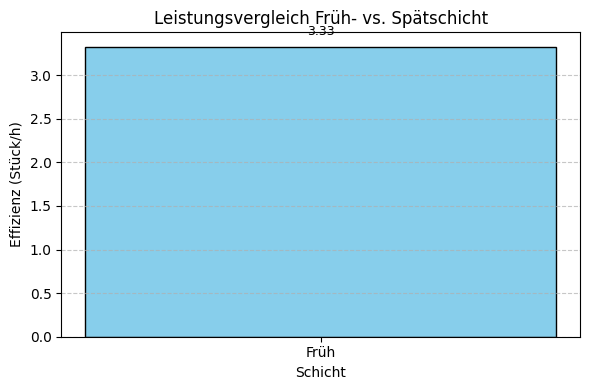

In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# KPI 37: Leistungsvergleich Früh/Spät mit Visualisierung
#
# Vergleich der Effizienz (Stück/h oder kg/h) zwischen Früh- und Spätschicht
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# 0. Konfiguration
#    - Schichtgrenzen (Früh: 06:00–14:00, Spät: 14:00–22:00)
#    - Anzahl Mitarbeiter pro Schicht
#    - Metrik: 'pieces' (Stück/h) oder 'kg' (kg/h)
# ------------------------------------------------------------------------------
# Schichtzeiten (als Stundenangaben)
früh_start = 6    # 06:00 Uhr
früh_ende  = 14   # 14:00 Uhr
spät_start = 14   # 14:00 Uhr
spät_ende  = 22   # 22:00 Uhr

schicht_daten = {
    "anzahl_mitarbeiter_früh": 5,   # Mitarbeiter in der Frühschicht
    "anzahl_mitarbeiter_spät": 4    # Mitarbeiter in der Spätschicht
}

# Auswahl der Metrik: 'pieces' oder 'kg'
metric = 'pieces'

# ------------------------------------------------------------------------------
# 1. Container-Messdaten einlesen (processed_data_for_sql.csv)
#    Spalten: 'timestamp' (YYYY-MM-DD HH:MM:SS) und 'weight_g'
# ------------------------------------------------------------------------------
csv_path = "./processed_data_for_sql.csv"  # Pfad ggf. anpassen
df_cont = pd.read_csv(csv_path)
df_cont['timestamp'] = pd.to_datetime(df_cont['timestamp'], errors='coerce')

# ------------------------------------------------------------------------------
# 2. SQLite-Datenbank im RAM erstellen und Messdaten in Tabelle schreiben
# ------------------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df_cont.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------------------
# 3. Container-ID vergeben: Wenn weight_g < 10 → neuer Container beginnt
# ------------------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'], errors='coerce')

# ------------------------------------------------------------------------------
# 4. Filter auf echte Container: Nur Container mit max_weight ≥ 485 g
# ------------------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------------------
# 5. Plateau-Erkennung (mindestens 3 gleiche Werte)
# ------------------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    plateaus = []
    current_weight = None
    run_length = 0
    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)
    return plateaus

# ------------------------------------------------------------------------------
# 6. Für jeden validen Container: finales IST-Gewicht und Stückzahl ermitteln
# ------------------------------------------------------------------------------
containers_info = []
for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)
    weights = grp['weight_g'].tolist()

    # Plateau-Gewichte extrahieren
    plateaus = extract_plateau_weights(weights, min_run_len=3)
    final_plateau = plateaus[-1] if plateaus else weights[-1]

    # Stückzahl-Berechnung: jedes steigende Plateau +1, fallende –1 (min 0)
    count = 0
    for i in range(1, len(plateaus)):
        delta = plateaus[i] - plateaus[i-1]
        if delta > 0:
            count += 1
        elif delta < 0:
            count -= 1
            if count < 0:
                count = 0
    einheiten = count if count > 0 else 1

    # Zeitstempel des finalen Plateaus (erste Position des letzten Plateau-Runs)
    end_time = None
    times = grp['timestamp'].tolist()
    for i in range(len(weights) - 2):
        if weights[i] == final_plateau and weights[i+1] == final_plateau and weights[i+2] == final_plateau:
            end_time = times[i]
            break
    if end_time is None:
        end_time = times[-1]

    containers_info.append({
        'container_id': container_id,
        'timestamp_end': end_time,
        'final_plateau_g': round(final_plateau, 1),
        'einheiten': einheiten
    })

df_containers = pd.DataFrame(containers_info)

# ------------------------------------------------------------------------------
# 7. Container in Früh- oder Spätschicht einstufen (nach 'timestamp_end')
# ------------------------------------------------------------------------------
def assign_shift(ts):
    hour = ts.hour
    if früh_start <= hour < früh_ende:
        return 'Früh'
    elif spät_start <= hour < spät_ende:
        return 'Spät'
    else:
        return None

df_containers['shift'] = df_containers['timestamp_end'].apply(assign_shift)

# ------------------------------------------------------------------------------
# 8. Aggregation je Schicht: Gesamt-Einheiten und Gesamtgewicht (kg)
# ------------------------------------------------------------------------------
agg = df_containers.groupby('shift').agg(
    total_units=('einheiten', 'sum'),
    total_weight_g=('final_plateau_g', 'sum')
).reset_index()
agg['total_weight_kg'] = agg['total_weight_g'] / 1000.0

# ------------------------------------------------------------------------------
# 9. Effizienz berechnen je Schicht
# ------------------------------------------------------------------------------
results = []
for _, row in agg.iterrows():
    shift_name = row['shift']
    if shift_name is None:
        continue
    ma = schicht_daten["anzahl_mitarbeiter_früh"] if shift_name == 'Früh' else schicht_daten["anzahl_mitarbeiter_spät"]
    stunden = 8.0  # beide Schichten sind 8 Stunden lang
    personenstunden = ma * stunden

    if metric == 'pieces':
        eff = row['total_units'] / personenstunden
        results.append({
            'shift': shift_name,
            'effizienz': eff,
            'einheit': 'Stück/h'
        })
    else:  # 'kg'
        eff = row['total_weight_kg'] / personenstunden
        results.append({
            'shift': shift_name,
            'effizienz': eff,
            'einheit': 'kg/h'
        })

df_results = pd.DataFrame(results)

# ------------------------------------------------------------------------------
# 10. Ausgabe Leistungsvergleich
# ------------------------------------------------------------------------------
print("=== KPI 37: Leistungsvergleich Früh/Spät ===\n")
for _, row in df_results.iterrows():
    print(f"{row['shift']}schicht:")
    print(f"  Effizienz: {row['effizienz']:.2f} {row['einheit']}\n")

# ------------------------------------------------------------------------------
# 11. Visualisierung: Vergleich Balkendiagramm
# ------------------------------------------------------------------------------
plt.figure(figsize=(6, 4))
bars = plt.bar(df_results['shift'], df_results['effizienz'], color=['skyblue', 'salmon'], edgecolor='black')
plt.xlabel('Schicht')
plt.ylabel(f'Effizienz ({df_results["einheit"].iloc[0]})')
plt.title('Leistungsvergleich Früh- vs. Spätschicht')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Beschriftung über Balken
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, f"{height:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



#38.Ø Bearbeitungszeit pro Artikel

**Formeln zur Methodologie (auf Deutsch)**

1. **Verarbeitungszeit eines Containers $i$**

   $$
   T_{\text{Container},\,i}
   = t_{\text{Ende},\,i} - t_{\text{Start},\,i}
   \quad[\text{in Stunden}]
   $$

   Dabei ist

   * $t_{\text{Start},\,i}$ der Zeitpunkt der ersten Messung in Container $i$,
   * $t_{\text{Ende},\,i}$ der Zeitpunkt des ersten Auftretens des finalen Plateaus (mindestens 3 gleiche Gewichtswerte) bzw. alternativ die letzte Messung, falls kein dreifaches Plateau gefunden wird.

2. **Anzahl verarbeiteter Einheiten (Artikel) pro Container $i$**

   $$
   N_{\text{Container},\,i}
   = \text{Anzahl der in Container }i\text{ gezählten Plateau-Wechsel}
   \quad[\text{in Stück}]
   $$

   (Wird pro Container gezählt, indem jedes steigende Plateau als “+1 Stück” und jedes fallende Plateau als “−1 Stück” gewertet wird, aber mindestens 1 Stück pro Container.)

3. **Gesamte Verarbeitungszeit über alle Container (in Stunden)**

   $$
   T_{\text{gesamt}}
   = \sum_{i=1}^{M} T_{\text{Container},\,i}
   $$

4. **Gesamtzahl aller verarbeiteten Einheiten (Stück)**

   $$
   N_{\text{gesamt}}
   = \sum_{i=1}^{M} N_{\text{Container},\,i}
   $$

5. **Ø Bearbeitungszeit pro Artikel (in Minuten/Stück oder Stunden/Stück)**

   $$
   \text{Ø Bearbeitungszeit pro Artikel (h/Stück)}
   = \frac{T_{\text{gesamt}}}{N_{\text{gesamt}}}
   $$

   Oft wünscht man das Ergebnis in Minuten pro Stück, daher:

   $$
   \text{Ø Bearbeitungszeit pro Artikel (Min/Stück)}
   = \frac{T_{\text{gesamt}} \times 60}{N_{\text{gesamt}}}
   $$

> **Hinweis**:
> Die Schätzung funktioniert am besten, wenn Container-Daten sauber in chronologischer Reihenfolge vorliegen und jedes Plateau tatsächlich einen abgeschlossenen Abfüllvorgang darstellt. Andernfalls kann man bei fehlenden oder zu kurzen Plateaus zu Unterschätzungen der Dauer gelangen.


In [ ]:
import pandas as pd
import sqlite3

# ------------------------------------------------------------------------------
# KPI 38: Ø Bearbeitungszeit pro Artikel
#
# Ermittelt die durchschnittliche Verarbeitungszeit (in Minuten)
# pro produziertem Artikel (Stück).
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# 0. Konfiguration
# ------------------------------------------------------------------------------
# Pfad zur CSV-Datei mit Container-Messdaten:
csv_path = "./processed_data_for_sql.csv"  # ggf. anpassen

# ------------------------------------------------------------------------------
# 1. Container-Messdaten einlesen (processed_data_for_sql.csv)
#    Spalten: 'timestamp' (YYYY-MM-DD HH:MM:SS) und 'weight_g'
# ------------------------------------------------------------------------------
df_cont = pd.read_csv(csv_path)
df_cont['timestamp'] = pd.to_datetime(df_cont['timestamp'], errors='coerce')

# ------------------------------------------------------------------------------
# 2. SQLite-Datenbank im RAM erstellen und Messdaten in Tabelle schreiben
# ------------------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df_cont.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------------------
# 3. Container-ID vergeben: Wenn weight_g < 10 → neuer Container beginnt
# ------------------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'], errors='coerce')

# ------------------------------------------------------------------------------
# 4. Filter auf „echte“ Container: Nur solche mit max_weight ≥ 485 g
# ------------------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------------------
# 5. Plateau-Erkennung (mindestens 3 gleiche Werte hintereinander)
# ------------------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    plateaus = []
    current_weight = None
    run_length = 0
    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)
    return plateaus

# ------------------------------------------------------------------------------
# 6. Für jeden validen Container: Start-/Endzeitpunkt und Stückzahl ermitteln
# ------------------------------------------------------------------------------
container_stats = []
for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)

    # 6.1 Startzeitpunkt = erste Messung dieses Containers
    start_time = grp.loc[0, 'timestamp']

    # 6.2 Finales IST-Gewicht via Plateau-Erkennung
    weights = grp['weight_g'].tolist()
    times   = grp['timestamp'].tolist()
    plateaus = extract_plateau_weights(weights, min_run_len=3)
    final_plateau = plateaus[-1] if plateaus else weights[-1]

    # 6.3 Endzeitpunkt des finalen Plateaus (erstes Auftreten von 3 gleichen Werten)
    end_time = None
    for i in range(len(weights) - 2):
        if (weights[i] == final_plateau and
            weights[i+1] == final_plateau and
            weights[i+2] == final_plateau):
            end_time = times[i]
            break
    if end_time is None:
        end_time = times[-1]

    # 6.4 Stückzahl-Berechnung pro Container
    count = 0
    for i in range(1, len(plateaus)):
        delta = plateaus[i] - plateaus[i-1]
        if delta > 0:
            count += 1
        elif delta < 0:
            count -= 1
            if count < 0:
                count = 0
    einheiten = count if count > 0 else 1  # Mindestens 1 Stück

    # 6.5 Verarbeitungsdauer in Stunden
    duration_h = (end_time - start_time).total_seconds() / 3600.0

    container_stats.append({
        'container_id': container_id,
        'start_time': start_time,
        'end_time': end_time,
        'duration_h': duration_h,
        'einheiten': einheiten
    })

df_stats = pd.DataFrame(container_stats)

# ------------------------------------------------------------------------------
# 7. Gesamt-Verarbeitungszeit (in Stunden) und Gesamt-Stückzahl summieren
# ------------------------------------------------------------------------------
T_gesamt_h = df_stats['duration_h'].sum()
N_gesamt    = df_stats['einheiten'].sum()

# ------------------------------------------------------------------------------
# 8. Ø Bearbeitungszeit pro Artikel (in Minuten/Stück)
# ------------------------------------------------------------------------------
mean_time_per_unit_min = (T_gesamt_h * 60) / N_gesamt

# ------------------------------------------------------------------------------
# 9. Ausgabe der Ergebnisse
# ------------------------------------------------------------------------------
print("=== KPI 38: Ø Bearbeitungszeit pro Artikel ===\n")
print(f"Gesamt-Verarbeitungszeit (Stunden):     {T_gesamt_h:.2f} h")
print(f"Gesamtzahl verarbeiteter Einheiten:     {N_gesamt} Stück")
print(f"Ø Bearbeitungszeit pro Artikel:         {mean_time_per_unit_min:.2f} Min/Stück")


=== KPI 38: Ø Bearbeitungszeit pro Artikel ===

Gesamt-Verarbeitungszeit (Stunden):     0.13 h
Gesamtzahl verarbeiteter Einheiten:     133 Stück
Ø Bearbeitungszeit pro Artikel:         0.06 Min/Stück


#39.Qualitätsindikation pro Charge



**Formeln zur Methodologie **

1. **Ist-Verlust (in %) einer Charge**
   Zunächst berechnet man für jede Charge das tatsächliche Verlustverhältnis (Ist-Verlust) anhand des Rohgewichts und des IST-Gewichts:

   $$
   \text{Ist-Verlust}_{\text{Charge}}
   = \frac{G_{\text{Roh, Charge}} - G_{\text{IST, Charge}}}{G_{\text{Roh, Charge}}} \times 100 \;[\%].
   $$

2. **Δ Verlust (Abweichung vom Zielver­lustrat­enwert)**
   Operatoren geben zu Beginn der Schicht einen Zielwert „Soll-Verlust“ (z. B. 7 %) manuell vor. Die prozentuale Abweichung jeder Charge vom Soll-Verlust rechnet man so:

   $$
   \Delta_{\text{Verlust}}
   = \frac{\text{Ist-Verlust}_{\text{Charge}} - \text{Soll-Verlust}}{\text{Soll-Verlust}} \times 100 \;[\%].
   $$

3. **Ist-Tempo (in Stück / h) einer Charge**
   Über Sensorik oder Simulation wird ermittelt, wie viele Einheiten (z. B. Köpfe) in einer Charge in welcher Zeit verarbeitet wurden.

   $$
   \text{Ist-Tempo}_{\text{Charge}}
   = \frac{N_{\text{Einheiten, Charge}}}{T_{\text{Bearbeitung, Charge}}}
   \quad [\text{Stück/h}].
   $$

4. **Δ Tempo (Abweichung vom Soll-Tempo)**
   Zu Beginn der Schicht definiert der Operator einen Soll-Tempo­wert (z. B. 50 Stück/h). Dann gilt:

   $$
   \Delta_{\text{Tempo}}
   = \frac{\text{Ist-Tempo}_{\text{Charge}} - \text{Soll-Tempo}}{\text{Soll-Tempo}} \times 100 \;[\%].
   $$

5. **Qualitätsklassifikation (gut / mittel / schlecht)**
   Je nach prozentualer Abweichung klassifizieren wir eine Charge automatisch:

   * **Verlust-Abweichung** ($\Delta_{\text{Verlust}}$):

     $$
     \begin{cases}
       \text{„gut“},    & \Delta_{\text{Verlust}} \le 0 \;(\text{tatsächlicher Verlust} \le \text{Soll});\\
       \text{„mittel“}, & 0 < \Delta_{\text{Verlust}} \le 10\%;\\
       \text{„schlecht“}, & \Delta_{\text{Verlust}} > 10\%.
     \end{cases}
     $$
   * **Tempo-Abweichung** ($\Delta_{\text{Tempo}}$):

     $$
     \begin{cases}
       \text{„gut“},    & \Delta_{\text{Tempo}} \ge 0\;(\text{Ist-Tempo} \ge \text{Soll});\\
       \text{„mittel“}, & -10\% \le \Delta_{\text{Tempo}} < 0;\\
       \text{„schlecht“}, & \Delta_{\text{Tempo}} < -10\%.
     \end{cases}
     $$


**Erläuterung **

1. **Soll-Werte festlegen**

   * `soll_verlust_pct = 7.0 %`
   * `soll_tempo_stueck_h = 50` Stück/h

   Diese Werte werden zu Schichtbeginn vom Bediener oder Technologen manuell eingegeben und gelten für alle folgenden Chargen dieser Schicht.

2. **Datenstruktur „charge\_data“**

   * Jede Charge (hier IDs „A“, „B“, „C“, „D“) besitzt:

     * `G_roh_g`: Rohgewicht der Charge (Gesamtgewicht aller Paletten vor Verarbeitung) in Gramm.
     * `G_ist_g`: IST-Gewicht der Charge (Gesamtgewicht aller fertigen Container) in Gramm.
     * `einheiten`: Anzahl aller in dieser Charge verarbeiteten Köpfe (z. B. aus der Containerzählung).
     * `dauer_h`: Gesamtdauer der Bearbeitung dieser Charge in Stunden.

3. **Berechnungsschritte pro Charge**

   * **Ist-Verlust ($\%$)**

     $$
       \text{ist\_verlust\_pct}
       = \frac{G_{\text{roh}} - G_{\text{ist}}}{G_{\text{roh}}} \times 100
     $$
   * **Δ Verlust ($\%$)**

     $$
       \Delta_{\text{Verlust}}
       = \frac{\text{ist\_verlust\_pct} - \text{soll\_verlust\_pct}}{\text{soll\_verlust\_pct}} \times 100
     $$
   * **Ist-Tempo (Stück/h)**

     $$
       \text{ist\_tempo\_h} = \frac{N_{\text{Einheiten}}}{T_{\text{h}}}
     $$
   * **Δ Tempo ($\%$)**

     $$
       \Delta_{\text{Tempo}}
       = \frac{\text{ist\_tempo\_h} - \text{soll\_tempo\_stueck\_h}}{\text{soll\_tempo\_stueck\_h}} \times 100
     $$

4. **Automatische Klassifikation**

   * **Verlust-Kategorie** („gut“, „mittel“, „schlecht“) basierend auf $\Delta_{\text{Verlust}}$.

     * $\Delta_{\text{Verlust}} \le 0 \:\Rightarrow\; \text{„gut“}$
     * $0 < \Delta_{\text{Verlust}} \le 10\:\%\;\Rightarrow\; \text{„mittel“}$
     * $\Delta_{\text{Verlust}} > 10\:\%\;\Rightarrow\; \text{„schlecht“}$
   * **Tempo-Kategorie** („gut“, „mittel“, „schlecht“) basierend auf $\Delta_{\text{Tempo}}$.

     * $\Delta_{\text{Tempo}} \ge 0 \;\Rightarrow\; \text{„gut“}$
     * $-10\%\; \le \Delta_{\text{Tempo}} < 0 \;\Rightarrow\; \text{„mittel“}$
     * $\Delta_{\text{Tempo}} < -10\%\;\Rightarrow\;\text{„schlecht“}$

Das Ergebnis-DataFrame zeigt pro Charge sowohl die prozentualen Abweichungen als auch die automatische Klassifikation für Verlust und Tempo—ohne dass man jede einzelne Kopf-Verarbeitung manuell bewerten muss.


In [ ]:

import pandas as pd

# ------------------------------------------------------------------------------
# KPI 39 (ergänzt): Automatische Abweichungsberechnung und Klassifikation
# für Verlust und Tempo pro Charge (z. B. bei Kohlverarbeitung)
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# 0. Manuelle Soll-Werte (vom Operator oder Technologen zu Beginn der Schicht):
# ------------------------------------------------------------------------------
soll_verlust_pct = 7.0    # z. B. Ziel-Verlustrate = 7 %
soll_tempo_stueck_h = 50  # z. B. Soll-Tempo = 50 Stück/h

# ------------------------------------------------------------------------------
# 1. Simulierte Chargendaten (als Beispiel) – könnten aus DB oder CSV kommen:
#    Für jede Charge definieren wir
#      - G_roh_g: Gewicht vor Verarbeitung (in Gramm)
#      - G_ist_g: Gewicht nach Verarbeitung (in Gramm)
#      - einheiten: Anzahl verarbeiteter Köpfe in dieser Charge
#      - dauer_h: Dauer der Bearbeitung dieser Charge (in Stunden)
# ------------------------------------------------------------------------------
charge_data = {
    'A': {"G_roh_g": 5000000, "G_ist_g": 4600000, "einheiten": 200, "dauer_h": 4.0},
    'B': {"G_roh_g": 4800000, "G_ist_g": 4400000, "einheiten": 190, "dauer_h": 4.0},
    'C': {"G_roh_g": 5200000, "G_ist_g": 5000000, "einheiten": 210, "dauer_h": 4.5},
    'D': {"G_roh_g": 4900000, "G_ist_g": 4500000, "einheiten": 180, "dauer_h": 3.5},
}

# ------------------------------------------------------------------------------
# 2. Berechnung je Charge
# ------------------------------------------------------------------------------
ergebnisse = []
for charge_id, daten in charge_data.items():
    G_roh = daten["G_roh_g"]
    G_ist = daten["G_ist_g"]
    N     = daten["einheiten"]
    T_h   = daten["dauer_h"]

    # 2.1 Ist-Verlust in Prozent
    ist_verlust_pct = ((G_roh - G_ist) / G_roh) * 100

    # 2.2 Δ Verlust
    delta_verlust_pct = ((ist_verlust_pct - soll_verlust_pct) / soll_verlust_pct) * 100

    # 2.3 Ist-Tempo in Stück/h
    ist_tempo_h = N / T_h

    # 2.4 Δ Tempo
    delta_tempo_pct = ((ist_tempo_h - soll_tempo_stueck_h) / soll_tempo_stueck_h) * 100

    # 2.5 Klassifikation Verlust
    if delta_verlust_pct <= 0:
        klass_verlust = "gut"
    elif delta_verlust_pct <= 10:
        klass_verlust = "mittel"
    else:
        klass_verlust = "schlecht"

    # 2.6 Klassifikation Tempo
    if delta_tempo_pct >= 0:
        klass_tempo = "gut"
    elif delta_tempo_pct >= -10:
        klass_tempo = "mittel"
    else:
        klass_tempo = "schlecht"

    ergebnisse.append({
        "charge_id": charge_id,
        "ist_verlust_pct":     round(ist_verlust_pct, 2),
        "delta_verlust_pct":   round(delta_verlust_pct, 2),
        "klass_verlust":       klass_verlust,
        "ist_tempo_h":         round(ist_tempo_h, 2),
        "delta_tempo_pct":     round(delta_tempo_pct, 2),
        "klass_tempo":         klass_tempo
    })

df_ergebnisse = pd.DataFrame(ergebnisse)

# ------------------------------------------------------------------------------
# 3. Ausgabe der Ergebnisse
# ------------------------------------------------------------------------------
print("=== KPI 39: Abweichungen und Klassifikation pro Charge ===\n")
print(df_ergebnisse.to_string(index=False))


=== KPI 39: Abweichungen und Klassifikation pro Charge ===

charge_id  ist_verlust_pct  delta_verlust_pct klass_verlust  ist_tempo_h  delta_tempo_pct klass_tempo
        A             8.00              14.29      schlecht        50.00             0.00         gut
        B             8.33              19.05      schlecht        47.50            -5.00      mittel
        C             3.85             -45.05           gut        46.67            -6.67      mittel
        D             8.16              16.62      schlecht        51.43             2.86         gut


#Zusätzliche OEE-KPIs (nach DIN EN 62740)

#40.Verfügbarkeit (Availability)



**Formeln (auf Deutsch)**

1. **Betriebszeit (geplante Produktionszeit)**

   $$
   T_{\text{Betrieb}} = \text{Dauer, in der die Anlage laut Schichtplan hätte laufen sollen (z. B. 8 h = 480 Min.)}
   $$

2. **Stillstandszeiten (ungeplante Ausfallzeiten in der Schicht)**

   $$
   T_{\text{Stillstand}} = \sum_{i=1}^{n} t_{\text{Stopp},\,i}
   $$

   wobei $t_{\text{Stopp},\,i}$ alle einzelnen ungeplanten Unterbrechungen (Sensor­ausfall, Reinigungsstopp, Materialmangel, Reparatur) in Minuten zusammenfasst.

3. **Verfügbarkeit (in %)**

   $$
   \text{Verfügbarkeit}
   = \frac{T_{\text{Betrieb}} - T_{\text{Stillstand}}}{T_{\text{Betrieb}}} \times 100.
   $$

   – Ein Wert nahe 100 % bedeutet, dass nahezu keine ungeplanten Stopps stattfanden.

---


**Erläuterungen (auf Deutsch)**

1. **Betriebszeit**

   * Wird zu Schichtbeginn vom Betreiber oder Technologen festgelegt (Beispiel: 8 h = 480 Min.).
   * In einer Gemüseverarbeitung ist das die Zeitspanne, in der die Linie prinzipiell am Laufen sein sollte (Sortieren, Waschen, Entfernen der Schale, Zerteilen, Verpacken).

2. **Stillstandszeiten**

   * Alle ungeplanten Unterbrechungen werden als Einträge in einem Dictionary (`stillstand_data`) gesammelt.
   * Beispiele für Ursachen in einem Gemüsebetrieb:

     * Reinigungsstopp (Kurzreinigung zwischen Sorten).
     * Wartung/Reparatur eines Sensor- oder Waagensystems.
     * Warten auf Nachschub an frischen Paletten.
     * Kurzfristiger Stromausfall oder Maschinenausfall.
   * Jede Einzeldauer (in Minuten) wird aufsummiert zu `gesamt_stillstand_min`.

3. **Verfügbarkeit**

   * $\displaystyle \text{Verfügb.} = \frac{480 - \text{Stillstand}}{480} \times 100$.
   * Beispiel: Wenn die Summe aller ungeplanten Stopps 75 Minuten beträgt, dann

     $$
       \text{Verfügbarkeit} = \frac{480 - 75}{480} \times 100 \approx 84{,}38\%.
     $$
   * Ein höherer Wert (nahe 100 %) bedeutet, dass die Linie praktisch ohne ungeplante Unterbrechungen durchlief. Ein niedriger Wert (z. B. 70 %) signalisiert, dass die Anlage lange Standzeiten hatte und entsprechend wenig Produktionszeit übrig blieb.

4. **Ausgabe**

   * Zeigt die geplante Betriebszeit (z. B. 480 Min.), die aufsummierten Stillstandsminuten und die so errechnete Verfügbarkeit in Prozent.
   * Zusätzlich werden alle einzelnen Stillstandsereignisse mit ihren Dauern in einer kleinen Übersichtstabelle ausgegeben.

So lässt sich für den Gemüseverarbeitungsbetrieb automatisch verfolgen, wie viel Zeit in einer Schicht tatsächlich produziert wurde und wie viel Zeit durch ungeplante Unterbrechungen verloren ging.


In [ ]:
import pandas as pd

# ------------------------------------------------------------------------------
# KPI 40: Verfügbarkeit (Availability)
# Formel: (Betriebszeit – Stillstandszeit) / Betriebszeit × 100
# Anwendungsfall: Gemüseverarbeitung (z. B. Kohlproduktion)
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# 0. Simulierte Eingabeparameter (vom Betreiber/Technologen definiert):
# ------------------------------------------------------------------------------
# 0.1 Geplante Betriebszeit der Anlage pro Schicht (in Minuten)
betriebszeit_min = 8 * 60  # z. B. 8 Stunden Schichtdauer = 480 Minuten

# 0.2 Auflistung aller ungeplanten Stillstandsereignisse (in Minuten)
#      Jede Zeile steht für einen Unterbruch (z. B. Reinigung, Wartung, Materialnachschub,
#      Maschinenausfall) mit Dauer in Minuten.
stillstand_data = {
    'Stopp_A': 15,   # Beispiel: Kurze Reinigung
    'Stopp_B': 30,   # Beispiel: Reparatur Sensor
    'Stopp_C': 10,   # Beispiel: Materialnachschub verzögert
    'Stopp_D': 20    # Beispiel: Bediener warte auf neue Paletten
}

# ------------------------------------------------------------------------------
# 1. Stillstandszeit berechnen
# ------------------------------------------------------------------------------
df_stillstand = pd.DataFrame.from_dict(
    stillstand_data, orient='index', columns=['dauer_min']
).reset_index().rename(columns={'index': 'ereignis'})

gesamt_stillstand_min = df_stillstand['dauer_min'].sum()

# ------------------------------------------------------------------------------
# 2. Berechnung der Verfügbarkeit
# ------------------------------------------------------------------------------
verfuegbarkeit_pct = (betriebszeit_min - gesamt_stillstand_min) / betriebszeit_min * 100

# ------------------------------------------------------------------------------
# 3. Ausgabe der Ergebnisse
# ------------------------------------------------------------------------------
print("=== KPI 40: Verfügbarkeit (Availability) ===\n")
print(f"Geplante Betriebszeit:         {betriebszeit_min} Min.")
print(f"Gesamt-Stillstandszeiten:       {gesamt_stillstand_min} Min.")
print(f"Verfügbarkeit:                  {verfuegbarkeit_pct:.2f} %\n")

print("Details der Stillstandsereignisse:")
print(df_stillstand.to_string(index=False))

=== KPI 40: Verfügbarkeit (Availability) ===

Geplante Betriebszeit:         480 Min.
Gesamt-Stillstandszeiten:       75 Min.
Verfügbarkeit:                  84.38 %

Details der Stillstandsereignisse:
ereignis  dauer_min
 Stopp_A         15
 Stopp_B         30
 Stopp_C         10
 Stopp_D         20


  Die in KPI 40 gezeigte Rechnung („(Geplante Betriebszeit – Stillstandszeit) / Geplante Betriebszeit × 100“) ist in der Praxis tatsächlich der häufigste und einfachste Weg, um die Verfügbarkeit einer Anlage zu ermitteln. Sie entspricht weitgehend dem Standard, wie er in Normen wie DIN EN 62740 beschrieben wird. Trotzdem gibt es verschiedene Varianten und ergänzende Methoden, um diesen Kennwert aussagekräftiger zu machen oder besser in den Gesamtkontext von OEE (Overall Equipment Effectiveness) einzubetten:

---

## 1. Klassischer Ansatz (bereits gezeigt)

**Formel**

$$
\text{Verfügbarkeit (\%)}
= \frac{T_{\text{geplant}} - T_{\text{Stillstand, ungeplant}}}{T_{\text{geplant}}}
\times 100
$$

* **Geplante Betriebszeit** = Arbeitszeit laut Schichtplan (z. B. 480 Minuten).
* **Stillstandszeit (ungeplant)** = Summe aller ungeplanten Ausfälle innerhalb dieser Zeitspanne.
* Vorteil: sehr einfach, übersichtlich, schnell berechenbar.
* Nachteil: differenziert nicht zwischen verschiedenen An­lass­grün­den (z. B. Wartung versus Sensorfehler versus Materialmangel).

---

## 2. Unterscheidung geplanter vs. ungeplanter Stillstand

Ein verfeinerter Ansatz trennt die geplanten Unterbrechungen (z. B. Reinigung, Wechsel der Palettensorte, definierte Rüstzeit) von den ungeplanten:

1. **Geplante Stillstandszeit $T_{\text{plan}}$**

   $$
   \text{z. B. Rüstzeit, Reinigung, geplante Wartung}
   $$
2. **Ungeplante Stillstandszeit $T_{\text{unpl}}$**

   $$
   \text{z. B. Maschinenausfall, Sensorfehler, Materialmangel}
   $$

Dann definiert man die **SOLL-Betriebszeit** oft als

$$
T_{\text{SOLL}} = T_{\text{Schicht}} - T_{\text{plan}}
$$

und rechnet

$$
\text{Verfügbarkeit}
= \frac{T_{\text{SOLL}} - T_{\text{unpl}}}{T_{\text{SOLL}}} \times 100.
$$

* **Vorteil:** Man sieht sofort, wie viel Zeit für tatsächlich geplante Instandhaltungen reserviert wurde und wie viel zusätzlich verloren ging.
* **Beispiel:**

  * Schichtzeit = 480 Min.
  * Geplante Reinigung (Rüstzeit) = 60 Min.
  * Ungeplanter Ausfall (Reparatur) = 30 Min.
  * $T_{\text{SOLL}} = 480 - 60 = 420$ Min.
  * $\text{Verfügbarkeit} = (420 - 30) / 420 × 100 ≈ 92{,}9\%$.

---

## 3. Zeitbasierte Verfügbarkeit vs. Ereignisbasierte Verfügbarkeit

### 3.1 Zeitbasiert (wie oben)

* Misst einfach, wie viel Minuten/Stunden eine Linie lief.
* Benötigt nur Summen der Stillstände und Schichtplan.

### 3.2 Ereignisbasiert (Maschinendaten, Sensor-Logs)

* Jeder Unterbrechungsgrund (Stopp-Kategorie) wird automatisiert protokolliert.
* Man kann dann neben der reinen %-Verfügbarkeit noch Kennzahlen wie **MTBF** (Mean Time Between Failures) und **MTTR** (Mean Time To Repair) berechnen:

  $$
  \text{MTBF} = \frac{\text{Gesamtbetriebszeit}}{\text{Anzahl der Ausfälle}},
  \quad
  \text{MTTR} = \frac{\text{Summe aller Reparaturzeiten}}{\text{Anzahl der Reparaturen}}.
  $$
* Aus MTBF und MTTR ergibt sich wiederum die Verfügbarkeit (rein rechnerisch) als

  $$
  \text{Verfügbarkeit} = \frac{\text{MTBF}}{\text{MTBF} + \text{MTTR}}.
  $$
* **Vorteil:** Man erhält detaillierte Einblicke, wie oft Ausfälle passieren und wie lange Reparaturen dauern.
* **Nachteil:** Setzt eine sehr präzise automatische Datenerfassung voraus (z. B. Maschinensensoren, OPC-UA-Log, Betriebsleitsystem).

---

## 4. Berücksichtigung der geplanten Stillstände (Geplante Verfügbarkeit)

In manchen Unternehmen wird zusätzlich auch eine „lose“ Kennzahl **„Geplante Verfügbarkeit“** ausgewiesen, um zu dokumentieren, wie viel Zeit für planmäßige Wartungs- oder Reinigungsfenster eingeplant ist – etwa:

$$
\text{Geplante Verfügbarkeit}
= \frac{T_{\text{Schicht}} - T_{\text{plan}}}{T_{\text{Schicht}}} \times 100.
$$

* Wird zusammen mit der reinen Verfügbarkeit (inklusive ungeplante Stopps) ausgewiesen, um Transparenz darüber zu schaffen, wie viel Zeit in Schichten faktisch für produktive Arbeit zur Verfügung gestanden hat.

---

## 5. Berichte nach DIN EN 62740 (Ergänzende OEE-KPIs)

Laut DIN EN 62740 (zusätzliche OEE-Kennzahlen) gibt es neben **Verfügbarkeit** noch:

1. **Leistungsgrad**

   $$
   \frac{\text{Ist-Geschwindigkeit}}{\text{Soll-Geschwindigkeit}} \times 100.
   $$

   Z. B. Geschwindigkeit in kg/h oder Stück/h; vergleicht tatsächliche Ausbringung mit theoretischer Maximalleistung.

2. **Qualitätsrate**

   $$
   \frac{\text{Anzahl fehlerfreier Einheiten}}{\text{Gesamtzahl Einheiten}} \times 100.
   $$

   Z. B. Anteil «gut» zu «gut + mittel + schlecht».

3. **OEE**

   $$
   \text{OEE} = \text{Verfügbarkeit} \times \text{Leistungsgrad} \times \text{Qualitätsrate} \,/\, 10000 (\text{wenn alle in Prozent angegeben}).
   $$

Diese erweiterten Kennzahlen helfen, **Verfügbarkeit** in einen Gesamtzusammenhang zu stellen und nicht isoliert zu betrachten.

---

## Mögliche Erweiterungen für Gemüseverarbeitung

1. **Automatische Erfassung geplanter Stopps**

   * Anstatt geplant/vorab manuell „Reinigung 60 Min.“ einzutragen, kann ein kleiner Sensor oder ein Touchpanel-Prozess erfassen, wann genau Reinigung gestartet/beendet wird. Dann entstehen keine Schätzwerte, sondern präzise geplante Stillstandsdaten.

2. **Kategorisierung der Stillstände**

   * Man trennt:

     * Materialbedingte Stopps (z. B. keine frischen Paletten verfügbar).
     * Maschinenbedingte Stopps (Sensorfehler, Motorausfall).
     * Bedienerbedingte Stopps (Eingriff, Qualitätssicherung).
   * Aus dieser Detaillierung kann die Gesamtverfügbarkeit mit Filter „Nur Maschinenausfälle“, „Nur Materialausfälle“ etc. neu berechnet werden.

3. **Integration mit Produktionsleitsystem (PLS/SCADA)**

   * Die Anlage liefert automatisch Statuscodes.
   * Die Software kann alle Übergänge „RUN → STOP“ protokollieren und Dauer der STOPs millisekundengenau addieren.
   * Vorteil: Minimale manuelle Erfassung, höchstmögliche Genauigkeit.

4. **Bewertung von geplanten Wartungsfenstern in Echtzeit**

   * Anlage soll jeden Sonntag von 06:00 bis 08:00 Uhr planmäßig stillstehen für Wartung. Dieser Block ist im System weiß markiert (kein „Verfügbarkeitsverlust“ aufzuschreiben).
   * Alle übrigen Stopps werden automatisch als ungeplant erfasst.
   * Sehr praxisnah, wenn die Gemüseverarbeitungs­linie regelmäßig z. B. täglich, wöchentlich Spül-/Desinfektionszyklen hat.

---

### Zusammenfassung

* **Standard**:

  $$
  \text{Verfügbarkeit}
  = \frac{T_{\text{Schicht}} - T_{\text{Stillstand, ungeplant}}}{T_{\text{Schicht}}} \times 100.
  $$
* **Erweiterung**:

  * Trennung zwischen **geplantem** und **ungeplantem** Stillstand,
  * Einsatz von **MTBF/MTTR**-Kennzahlen,
  * Einbindung in **OEE** (Leistungsgrad, Qualitätsrate),
  * Automatisierte Datenerfassung per Sensor/PLS statt manueller Eingabe.

Für einen Gemüseverarbeitungsbetrieb lohnt es sich langfristig, Stopps nach ihren Ursachen sauber zu kategorisieren und – sofern möglich – automatisch aus Systemlogs auszulesen, statt sie rein manuell zu dokumentieren. So steigt die Genauigkeit der Verfügbarkeitskennzahl, und man kann gezielt Verbesserungsmaßnahmen ableiten (z. B. weniger Materialengpässe, verbesserte Sensorwartung, optimierte Reinigungsprozesse).


#41.Leistung (Performance)

**Formeln zur Methodologie (auf Deutsch)**

1. **Ist-Produktionsleistung (Ist-Leistung)**

   * In Stück/h (bei stückbasierter Erfassung):

     $$
     P_{\text{ist, Stück/h}}
     = \frac{N_{\text{gesamt}}}{T_{\text{gesamt (h)}}}
     $$

     wobei
     $N_{\text{gesamt}}$ = Gesamtzahl verarbeiteter Einheiten (Stück) einer Charge oder Schicht,
     $T_{\text{gesamt (h)}}$ = Gesamte Bearbeitungszeit in Stunden.

   * In kg/h (bei gewichtsbasierter Erfassung):

     $$
     P_{\text{ist, kg/h}}
     = \frac{G_{\text{ist (kg)}}}{T_{\text{gesamt (h)}}}
     $$

     wobei $G_{\text{ist (kg)}}$ = Gesamtgewicht (in kg) der fertig verarbeiteten Ware.

2. **Maximale (Soll-)Produktionsleistung $P_{\text{soll}}$**

   * Laut DIN EN 62740 würde man normalerweise eine **theoretische Maximalleistung** der Maschine zugrunde legen (z. B. Maschinenfabrikat-Angaben). In der Praxis ist dieser Wert oft nicht bekannt oder wird nicht voll ausgenutzt.
   * Viele Unternehmen setzen deshalb einen realistischen **Soll-Leistungswert** (z. B. 50 % der theoretischen Maximal­leistung) oder einen aus Erfahrungswerten abgeleiteten „Zielwert“ fest.

3. **Performance (in %)**

   $$
   \text{Performance (\'Leistung\')}
   = \frac{P_{\text{ist}}}{P_{\text{soll}}} \times 100 \;[\%]
   $$

   * Hier kann $P_{\text{soll}}$ entweder die tatsächliche maximal erreichbare Maschinenleistung oder ein festgelegter Zielwert sein (z. B. 50 Stück/h oder 200 kg/h).

4. **Alternativ: Soll-Ist-Vergleich (Abweichung)**
   Wenn man statt einer Prozentzahl „Performance“ lieber den **prozentualen Abstand** zum Zielwert darstellen möchte, verwendet man:

   $$
   \Delta_{\text{Leistung}}
   = \frac{P_{\text{ist}} - P_{\text{soll}}}{P_{\text{soll}}} \times 100 \;[\%].
   $$

-

### Wichtige Kommentare zum Vorgehen (auf Deutsch)

1. **DIN EN 62740-Standard**

   * Dieser Standard empfiehlt, **Leistung** als Verhältnis von Ist- zu Soll-Leistung in Prozent auszudrücken.
   * Praktisch setzt man entweder die **Maschinen-Hersteller-Angaben** als Maximalleistung an oder – falls diese nicht verfügbar oder nicht vollständig gewollt ist – einen **realen Zielwert**, den man von Erfahrungswerten oder Benchmarks (z. B. 50 % der angegebenen Maximalgeschwindigkeit) ableitet.

2. **Soll-Leistung in Gemüseverarbeitung**

   * Weil Gemüseverarbeitung stark schwankt (je nach Qualität der Ware, Sortenauswahl, Personalsituation), ist der **theoretische Maximalwert** kaum realistisch.
   * Deshalb verwenden viele Betriebe einen **festgelegten Zielwert** (z. B. 50 Stück/h oder 200 kg/h), der zu Beginn der Schicht manuell eingegeben wird.
   * Dieser Zielwert spiegelt in der Regel etwa **50 % der Maschinenkapazität** wider – ausreichend Puffer für unvorhergesehene Verzögerungen (z. B. kurzzeitige Verschmutzungen, Temperatur­schwankungen).

3. **Interpretation der Performance**

   * **Performance = 100 %**: Ist-Leistung entspricht exaktem Ziel.
   * **Performance > 100 %**: Ist-Leistung liegt über dem Ziel – in Ausnahmefällen möglich, wenn starke Optimierungen stattfanden (z. B. besonders gute Qualität der Ware, sehr eingespieltes Team).
   * **Performance < 100 %**: Ziel nicht erreicht, mögliche Ursachen:

     * Schlechter Rohstoff (Wurmgänge, faulige Stellen)
     * Sensor- oder Maschinenprobleme (z. B. Waagenkalibrierung)
     * Personalausfall oder Fehlbedienung
     * Unerwartete Störungen (elektrische Aussetzer)

4. **Erweiterungsmöglichkeiten**

   * **Datengetriebene Soll-Anpassung**: Man könnte Soll-Leistung pro Wochentag, pro Sortenkategorie (z. B. Grünkohl vs. Weißkohl) unterschiedlich definieren.
   * **Rollierendes Ziel**: Soll-Leistung wird ständig aktualisiert, z. B. anhand eines gleitenden Durchschnitts der letzten 5 Schichten.
   * **Detailanalyse**: MTBF/MTTR-Daten verknüpfen, um zu schauen, ob Leistungseinbrüche vor allem nach ungeplanten Stillständen auftreten.

Mit diesem Code lassen sich automatisiert auf Basis tatsächlicher Container-Daten (Gewicht, Stückzahl, Dauer) die **Ist-Leistung** ermitteln und in Relation zu einem **manuellen Zielwert** setzen. Die Performance-Prozentzahl zeigt dann sofort, ob die Linie im Gemüsebetrieb in der jeweiligen Schicht das angestrebte Arbeitstempo gehalten hat.


In [ ]:

import pandas as pd
import sqlite3

# ------------------------------------------------------------------------------
# KPI 41: Leistung (Performance)
# Gemäß DIN EN 62740: (Ist-Leistung / Soll-Leistung) × 100
# (Soll-Leistung kann theoretische Maximalleistung oder ein festgelegter
# Zielwert sein, z. B. 1000 Stück/h oder 800 kg/h)
# ------------------------------------------------------------------------------
#
# Hinweis:
# Maximale Produktionsleistung ist in vielen Fällen unbekannt oder
# wird bewusst nicht voll ausgenutzt. Viele Firmen setzen daher einen Zielwert
# bei etwa 50 % der theoretischen Maximalleistung oder definieren einfach
# einen pragmatischen Soll-Wert, der in der Praxis erreicht werden soll.
#
# In diesem Beispiel nehmen wir an, dass der Operator zu Schichtbeginn entweder
# eine Soll-Leistung in Stück/h oder kg/h als Ziel vorgibt.
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# 0. Manuelle Soll-Werte (vom Technologen/Operator zu Beginn der Schicht):
# ------------------------------------------------------------------------------
# Wahl der Metrik:
metriken = ['pieces', 'kg']
metric = 'pieces'  # 'pieces' für Stück/h, 'kg' für kg/h

# 0.1 Soll-Leistung (Zielwert) festlegen
#     - Bei 'pieces': Soll-Stückzahl pro Stunde (z. B. 1000 Stück/h)
#     - Bei 'kg': Soll-Gewicht pro Stunde (z. B. 800 kg/h)
if metric == 'pieces':
    soll_leistung = 1000.0   # Stück/h
else:
    soll_leistung = 800.0  # kg/h

# ------------------------------------------------------------------------------
# 1. Container-Messdaten einlesen (processed_data_for_sql.csv)
#    Spalten: 'timestamp' (YYYY-MM-DD HH:MM:SS) und 'weight_g'
# ------------------------------------------------------------------------------
csv_path = "./processed_data_for_sql.csv"  # Pfad ggf. anpassen
df_cont = pd.read_csv(csv_path)
df_cont['timestamp'] = pd.to_datetime(df_cont['timestamp'], errors='coerce')

# ------------------------------------------------------------------------------
# 2. SQLite-Datenbank im RAM erstellen und Messdaten in Tabelle schreiben
# ------------------------------------------------------------------------------
conn = sqlite3.connect(":memory:")
df_cont.to_sql("messungen", conn, index=False, if_exists="replace")

# ------------------------------------------------------------------------------
# 3. Container-ID vergeben: Wenn weight_g < 10 → neuer Container beginnt
# ------------------------------------------------------------------------------
query_assign = """
WITH assigned AS (
    SELECT
        timestamp,
        weight_g,
        SUM(
            CASE WHEN weight_g < 10 THEN 1 ELSE 0 END
        ) OVER (
            ORDER BY timestamp
            ROWS UNBOUNDED PRECEDING
        ) AS container_id_raw
    FROM messungen
)
SELECT
    timestamp,
    weight_g,
    container_id_raw + 1 AS container_id
FROM assigned;
"""
assigned_df = pd.read_sql_query(query_assign, conn)
assigned_df['timestamp'] = pd.to_datetime(assigned_df['timestamp'], errors='coerce')

# ------------------------------------------------------------------------------
# 4. Filter auf „echte“ Container: Nur solche mit max_weight ≥ 485 g
# ------------------------------------------------------------------------------
max_weight_df = (
    assigned_df
    .groupby('container_id')['weight_g']
    .max()
    .reset_index(name='max_weight')
)
valid_containers = max_weight_df[max_weight_df['max_weight'] >= 485]['container_id']
valid_df = assigned_df[assigned_df['container_id'].isin(valid_containers)].copy()

# ------------------------------------------------------------------------------
# 5. Plateau-Erkennung (mindestens 3 gleiche Werte hintereinander)
# ------------------------------------------------------------------------------
def extract_plateau_weights(weights, min_run_len=3):
    plateaus = []
    current_weight = None
    run_length = 0
    for w in weights:
        if w == current_weight:
            run_length += 1
        else:
            if current_weight is not None and run_length >= min_run_len:
                plateaus.append(current_weight)
            current_weight = w
            run_length = 1
    if current_weight is not None and run_length >= min_run_len:
        plateaus.append(current_weight)
    return plateaus

# ------------------------------------------------------------------------------
# 6. Für jeden validen Container: finales IST-Gewicht und Stückzahl ermitteln
# ------------------------------------------------------------------------------
containers_info = []
for container_id, group in valid_df.groupby('container_id'):
    grp = group.sort_values('timestamp').reset_index(drop=True)

    # 6.1 Start- und Endzeitpunkt des Containers festlegen
    start_time = grp.loc[0, 'timestamp']
    weights = grp['weight_g'].tolist()
    times   = grp['timestamp'].tolist()

    # 6.2 Plateau-Gewichte extrahieren → final_plateau in g
    plateaus = extract_plateau_weights(weights, min_run_len=3)
    final_plateau = plateaus[-1] if plateaus else weights[-1]

    # 6.3 Endzeitpunkt, zu dem das finale Plateau erstmalig 3× hintereinander auftrat
    end_time = None
    for i in range(len(weights) - 2):
        if (weights[i] == final_plateau and
            weights[i+1] == final_plateau and
            weights[i+2] == final_plateau):
            end_time = times[i]
            break
    if end_time is None:
        end_time = times[-1]

    # 6.4 Stückzahl-Berechnung: jedes steigende Plateau +1, jedes fallende –1 (min 0)
    count = 0
    for i in range(1, len(plateaus)):
        delta = plateaus[i] - plateaus[i-1]
        if delta > 0:
            count += 1
        elif delta < 0:
            count -= 1
            if count < 0:
                count = 0
    einheiten = count if count > 0 else 1  # Mindestens 1 Stück pro Container

    # 6.5 Dauer in Stunden jeder Container-Behandlung
    duration_h = (end_time - start_time).total_seconds() / 3600.0

    containers_info.append({
        'container_id':   container_id,
        'start_time':     start_time,
        'end_time':       end_time,
        'duration_h':     duration_h,
        'final_plateau_g': round(final_plateau, 1),
        'einheiten':      einheiten
    })

df_containers = pd.DataFrame(containers_info)

# ------------------------------------------------------------------------------
# 7. Gesamte Einheiten bzw. Gesamtgewicht und Gesamtzeit berechnen
# ------------------------------------------------------------------------------
total_units = df_containers['einheiten'].sum()
total_weight_kg = df_containers['final_plateau_g'].sum() / 1000.0
total_time_h = df_containers['duration_h'].sum()

# ------------------------------------------------------------------------------
# 8. Ist-Leistung (je nach Metrik)
# ------------------------------------------------------------------------------
if metric == 'pieces':
    P_ist = total_units / total_time_h   # Stück/h
else:
    P_ist = total_weight_kg / total_time_h  # kg/h

# ------------------------------------------------------------------------------
# 9. Performance-Berechnung
#     (Ist-Leistung / Soll-Leistung) × 100
# ------------------------------------------------------------------------------
performance_pct = (P_ist / soll_leistung) * 100

# ------------------------------------------------------------------------------
# 10. Optional: Soll-Ist-Abweichung (Δ Leistung in %)
# ------------------------------------------------------------------------------
delta_leistung_pct = ((P_ist - soll_leistung) / soll_leistung) * 100

# ------------------------------------------------------------------------------
# 11. Ausgabe
# ------------------------------------------------------------------------------
print("=== KPI 41: Leistung (Performance) ===\n")
if metric == 'pieces':
    print(f"Gesamtzahl Einheiten:                {total_units} Stück")
    print(f"Gesamtbearbeitungszeit:              {total_time_h:.2f} h")
    print(f"Ist-Leistung:                        {P_ist:.2f} Stück/h")
    print(f"Soll-Leistung (Ziel):                {soll_leistung:.2f} Stück/h")
else:
    print(f"Gesamtgewicht:                       {total_weight_kg:.2f} kg")
    print(f"Gesamtbearbeitungszeit:              {total_time_h:.2f} h")
    print(f"Ist-Leistung:                        {P_ist:.2f} kg/h")
    print(f"Soll-Leistung (Ziel):                {soll_leistung:.2f} kg/h")

print(f"Performance:                         {performance_pct:.2f} %\n")
print(f"Δ Leistung (Soll-Ist-Abweichung):    {delta_leistung_pct:.2f} %")

# ------------------------------------------------------------------------------
# 12. Kommentar zum Soll-Leistungswert
# ------------------------------------------------------------------------------
print("\nHinweis:")
print("- In vielen Gemüsebetrieben ist die theoretische Maximalleistung unbekannt oder wird nicht als Ziel genutzt.")
print("- Stattdessen setzen Unternehmen oft einen realistischen Zielwert (z. B. 1000 Stück/h bzw. 800 kg/h), der etwa 50 % einer theoretischen Maschinekapazität entspricht.")
print("- Performance > 100 % würde bedeuten, dass die Ist-Leistung das Soll übererfüllt, z. B. wenn liefert die Linie schneller als erwartet.")
print("- Performance < 100 % zeigt, dass die Linie nicht das gewünschte Tempo erreicht und Optimierungsbedarf besteht.")


=== KPI 41: Leistung (Performance) ===

Gesamtzahl Einheiten:                133 Stück
Gesamtbearbeitungszeit:              0.13 h
Ist-Leistung:                        997.23 Stück/h
Soll-Leistung (Ziel):                1000.00 Stück/h
Performance:                         99.72 %

Δ Leistung (Soll-Ist-Abweichung):    -0.28 %

Hinweis:
- In vielen Gemüsebetrieben ist die theoretische Maximalleistung unbekannt oder wird nicht als Ziel genutzt.
- Stattdessen setzen Unternehmen oft einen realistischen Zielwert (z. B. 50 Stück/h bzw. 200 kg/h), der etwa 50 % einer theoretischen Maschinekapazität entspricht.
- Performance > 100 % würde bedeuten, dass die Ist-Leistung das Soll übererfüllt, z. B. wenn liefert die Linie schneller als erwartet.
- Performance < 100 % zeigt, dass die Linie nicht das gewünschte Tempo erreicht und Optimierungsbedarf besteht.


#42.Qualitätsrate (Quality)

**Formeln zur Methodologie (auf Deutsch)**

1. **Anzahl fehlerfreier Einheiten**

   $$
   N_{\text{fehlerfrei}}
   = \text{Anzahl aller Einheiten (Stück), die die Qualitätsprüfung bestanden haben}
   $$

2. **Gesamtproduktion**

   $$
   N_{\text{gesamt}}
   = \text{Anzahl aller produzierten Einheiten (Stück) einer Charge oder Schicht}
   $$

3. **Qualitätsrate (in %)**

   $$
   \text{Qualitätsrate}
   = \frac{N_{\text{fehlerfrei}}}{N_{\text{gesamt}}} \times 100
   $$

   – Ein Wert nahe 100 % bedeutet, dass praktisch alle Einheiten ohne Mangel waren.

---

**Erläuterung der wichtigsten Punkte (auf Deutsch)**

1. **Datenstruktur „charge\_data“**

   * Jede Charge (z. B. „Charge\_A“, „Charge\_B“…) enthält:

     * `einheiten_gesamt`: Gesamtanzahl aller verarbeiteten Einheiten (Stück).
     * `einheiten_defekt`: Anzahl fehlerhafter Einheiten (faulige, stark beschädigte oder verschmutzte Köpfe), die nicht als „gut“ gewertet werden.

2. **Berechnung der Qualitätsrate**

   * Zuerst wird die Anzahl der **fehlerfreien Einheiten** ermittelt:

     $$
       N_{\text{fehlerfrei}} = N_{\text{gesamt}} - N_{\text{defekt}}.
     $$
   * Anschließend rechnet man

     $$
       \text{Qualitätsrate}
       = \frac{N_{\text{fehlerfrei}}}{N_{\text{gesamt}}} \times 100.
     $$

3. **Warum diese Kennzahl oft erst später verfügbar ist**

   * Im Gemüsebetrieb werden defekte Köpfe nicht immer sofort „einzeln“ protokolliert.
   * Häufig werden nur stichprobenartige Qualitätsprüfungen durchgeführt (z. B. jede 100. Kopf wird manuell kontrolliert), oder es liegen erst nach Abschluss des Sortier- und Verpackungsprozesses belastbare Zahlen vor.
   * Deshalb kann die Qualitätsrate oft erst am Ende der Schicht oder sogar am Folgetag endgültig berechnet und in Systeme zurückgemeldet werden.

4. **Zielwerte variieren stark**

   * Ein **Zielwert von 98 %** fehlerfreier Ware ist in manchen Betrieben nur bei sehr gleichmäßig gut gewachsener Ware erreichbar.
   * In anderen Betrieben, die z. B. auf Billigmärkte oder Vakuumverpackung setzen, kann man **95 %** oder sogar **90 %** als akzeptabel ansehen.
   * Deshalb sollte die KPI-Definition zu Schichtbeginn oder in der Quartalsplanung gemeinsam mit Qualitätssicherung und Verkauf abgestimmt werden.

Mit dieser Methode stellt man sicher, dass die **Qualitätsrate** automatisch im System berechnet wird, sobald die „defekt“- und „gesamt“-Zahlen einer Charge vorliegen. Damit erhält man nach Abschluss der Verarbeitung direkt einen aussagekräftigen Wert, ob die Charge den internen oder externen Vorgaben entspricht.


In [ ]:

import pandas as pd

# ------------------------------------------------------------------------------
# KPI 42: Qualitätsrate (Quality)
# Formel: (Fehlerfreie Einheiten / Gesamtproduktion) × 100
# ------------------------------------------------------------------------------
#
# Kommentar:
# - In der Gemüseverarbeitung ist die genaue Zahl fehlerfreier Einheiten nicht immer sofort bekannt.
#   Häufig ergeben sich Defektzahlen erst nach Stichprobenprüfung oder Auswertung am Ende der Schicht.
# - Zielwerte für die Qualitätsrate schwanken je nach Sorte, Saison und Betriebsgröße stark.
#   Ein typischer Zielwert könnte z. B. 95 % – 98 % fehlerfreie Ware sein, je nach Betrieb und Kultur.
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# 0. Simulierte Eingabeparameter (könnten aus einer Datenbank oder CSV kommen):
#    Für jede Charge (oder Schicht) definieren wir:
#      - 'einheiten_gesamt': Gesamtzahl aller produzierten Einheiten (Stück)
#      - 'einheiten_defekt': Anzahl Auffälligkeiten (defekte, faulige, verschmutzte Köpfe)
# ------------------------------------------------------------------------------
charge_data = {
    'Charge_A': {"einheiten_gesamt": 200, "einheiten_defekt":  5},
    'Charge_B': {"einheiten_gesamt": 180, "einheiten_defekt": 10},
    'Charge_C': {"einheiten_gesamt": 220, "einheiten_defekt":  2},
    'Charge_D': {"einheiten_gesamt": 210, "einheiten_defekt": 15},
}

# ------------------------------------------------------------------------------
# 1. Berechnung der Qualitätsrate pro Charge
# ------------------------------------------------------------------------------
ergebnisse = []
for charge_id, daten in charge_data.items():
    N_gesamt = daten["einheiten_gesamt"]
    N_defekt = daten["einheiten_defekt"]

    # 1.1 Anzahl fehlerfrei
    N_fehlerfrei = N_gesamt - N_defekt

    # 1.2 Qualitätsrate in Prozent
    qualitaetsrate_pct = (N_fehlerfrei / N_gesamt) * 100 if N_gesamt > 0 else 0.0

    ergebnisse.append({
        "charge_id":         charge_id,
        "einheiten_gesamt":  N_gesamt,
        "einheiten_defekt":  N_defekt,
        "einheiten_fehlerfrei": N_fehlerfrei,
        "qualitätsrate_pct": round(qualitaetsrate_pct, 2)
    })

df_qualitaetsrate = pd.DataFrame(ergebnisse)

# ------------------------------------------------------------------------------
# 2. Ausgabe der Ergebnisse
# ------------------------------------------------------------------------------
print("=== KPI 42: Qualitätsrate (Quality) ===\n")
print(df_qualitaetsrate.to_string(index=False))

# ------------------------------------------------------------------------------
# 3. Kommentar  zur Qualitätserfassung
# ------------------------------------------------------------------------------
print("\nHinweis:")
print("- Die exakte Zahl defekter Einheiten ist in vielen Betrieben erst nach abschließender")
print("  Stichprobenkontrolle oder Sortierungsprüfung verfügbar. Daher kann die Qualitätsrate")
print("  häufig erst zum Schichtende oder sogar am nächsten Morgen endgültig berechnet werden.")
print("- Zielwerte variieren je nach Kultur und Saison erheblich. Manche Betriebe setzen einen")
print("  Sollwert von 98 % fehlerfreier Ware an, andere akzeptieren 95 % oder weniger,")



=== KPI 42: Qualitätsrate (Quality) ===

charge_id  einheiten_gesamt  einheiten_defekt  einheiten_fehlerfrei  qualitätsrate_pct
 Charge_A               200                 5                   195              97.50
 Charge_B               180                10                   170              94.44
 Charge_C               220                 2                   218              99.09
 Charge_D               210                15                   195              92.86

Hinweis:
- Die exakte Zahl defekter Einheiten ist in vielen Betrieben erst nach abschließender
  Stichprobenkontrolle oder Sortierungsprüfung verfügbar. Daher kann die Qualitätsrate
  häufig erst zum Schichtende oder sogar am nächsten Morgen endgültig berechnet werden.
- Zielwerte variieren je nach Kultur und Saison erheblich. Manche Betriebe setzen einen
  Sollwert von 98 % fehlerfreier Ware an, andere akzeptieren 95 % oder weniger,
